# Urban Sound Classification using Recurrent Neural Networks (RNN)

**Machine Learning II Project — 2025/2026**   
**Group:** Beatriz Pereira, Carolina Leite, Lara Gonçalves

---

## Table of Contents  <a name = "toc"></a>
1. [RNN](#rnn)
    - [Pre-Processing - RNN](#rnn_pp)
    - [Model Architecture - RNN](#rnn_am)
    - [Training Strategy - RNN](#rnn_et)
    - [Model Testing - RNN](#rnn_tm)
    - [Improvements Implemented - RNN](#rnn_mi)
2. [DeepFool Implementation](#deepfool)
3. [Conclusion](#conc)

## RNN <a name = "rnn"></a>
[[back to index]](#toc)

**Recurrent Neural Networks (RNNs)** are neural networks designed to work with **sequential data**, such as audio, text, or time series. Unlike traditional networks, RNNs have an internal memory that allows them to use information from previous steps to interpret the current one. This makes them especially useful for tasks where the order of the data is important, such as sound classification, as they are able to capture patterns that evolve over time.

<figure style="text-align: center;">
  <img src="images/basic_rnn_architecture.jpg" alt="RNN Architecture">
  <figcaption><em>Figure 1 – Basic RNN Architecture</em></figcaption>
</figure>

More advanced variants, such as LSTM and GRU, were developed to enhance this capability and overcome the limitations of simple RNNs. [(Barua et al., 2023)](Research/A_Deep_Learning_Approach_for_Urban_Sound.pdf), [(Mienye et al., 2024)](Research/rnn_architecture.pdf), [(Phan et al., 2017)](Research/Audio_Scene_Classif_RNN.pdf)

<figure style="text-align: center;">
  <img src="images/rnn_gru_lstm.png" alt="RNN Architecture">
  <figcaption><em>Figure 2 – Variants of RNN Architecture</em></figcaption>
</figure>

### Imports

In [51]:
!pip install librosa

Defaulting to user installation because normal site-packages is not writeable


In [52]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
import os
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, GRU, Bidirectional, Dense, Dropout,
    LayerNormalization, Attention, GlobalAveragePooling1D, MultiHeadAttention
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

### Pre-Processing - RNN <a name = "rnn_pp"></a>
[[back to RNN]](#rnn)

The **Mel-Frequency Cepstral Coefficients (MFCC)** were used as the input *features* for this model, extracted directly from the original audio data. To capture the temporal evolution of the signal, the audio was segmented into windows of **0.25 seconds** with a *hop size* of **0.125 seconds**, following the configuration suggested by [(Phan et al., 2017)](Research/Audio_Scene_Classif_RNN.pdf).

With this setup, each audio file is divided into **33 segments**, where each segment represents the state of the audio at a particular moment in time.

The implemented function extracts the MFCCs from a given audio file and generates these 33 segments, producing the feature sequence that will be used as the model’s input.


In [53]:
def extract_MFCC_segments(audio_path, sample_rate=22050, segment_duration=0.25, hop_duration=0.125, n_mfcc=60):
    # load 4s audio
    audio, sr = librosa.load(audio_path, sr=sample_rate)

    segment_len = int(segment_duration * sample_rate)
    hop_len = int(hop_duration * sample_rate)

    segments = []
    start = 0

    target_segments = 33  # defined in the article

    for _ in range(target_segments):
        end = start + segment_len
        
        # No need padding because the audio files have a fixed 4.0s time
        segment = audio[start:end]

        # Extraction of MFCC by segment
        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)

        segments.append(mfcc_mean)

        start += hop_len

    return np.array(segments)  # (33, 60)

In [54]:
def get_mfcc_dataset_RNN(audio_dir, metadata_path, output_path):
    # Metadata UrbanSound8K
    df_metadata = pd.read_csv(metadata_path)

    # Prepare columns from final DataFrame
    columns = ['fold', 'classID', 'audio_name'] + [f'mfcc_{i}' for i in range(60)]
    data = []

    # Loop by folds
    for fold in range(1, 11):
        folder_path = os.path.join(audio_dir, f"fold{fold}")

        if os.path.exists(folder_path):
            print(f"\nProcessing fold {fold}...")
            
            for file in tqdm(os.listdir(folder_path)):
                if file.endswith(".wav"):

                    audio_path = os.path.join(folder_path, file)

                    # Extract segmented MFCC (33 segments × 60 coefficients)
                    segments_features = extract_MFCC_segments(audio_path)

                    # Find matching metadata
                    info = df_metadata[df_metadata["slice_file_name"] == file]

                    if info.empty:
                        continue  # ignore files that do not exist in the metadata.

                    class_id = int(info.iloc[0]["classID"])
                    fold_number = int(info.iloc[0]["fold"])
                    audio_name = info.iloc[0]["slice_file_name"]

                    # Create a line for each segment.
                    for segment in segments_features:
                        row = {
                            "fold": fold_number,
                            "classID": class_id,
                            "audio_name": audio_name,
                        }
                        row.update({f"mfcc_{i}": segment[i] for i in range(60)})
                        data.append(row)

    # Create DataFrame and save
    df_dataset = pd.DataFrame(data, columns=columns)
    save_path = os.path.join(output_path, "mfcc_for_RNN.csv")
    df_dataset.to_csv(save_path, index=False)

    print(f"\nDataset saved to: {save_path}")
    return df_dataset


In [55]:
df_mfcc = get_mfcc_dataset_RNN(
    audio_dir="UrbanSound8K/audio_processed",                  
    metadata_path="UrbanSound8K/metadata/UrbanSound8K.csv",  
    output_path="UrbanSound8K/metadata"                                 
)


Processing fold 1...


  0%|          | 0/873 [00:00<?, ?it/s]c:\ProgramData\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
C:\Users\Utilizador\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=8
  warnings.warn(
100%|██████████| 873/873 [03:50<00:00,  3.79it/s]



Processing fold 2...


100%|██████████| 888/888 [04:05<00:00,  3.61it/s]



Processing fold 3...


100%|██████████| 925/925 [04:13<00:00,  3.65it/s]



Processing fold 4...


100%|██████████| 990/990 [04:29<00:00,  3.68it/s]



Processing fold 5...


100%|██████████| 936/936 [04:13<00:00,  3.69it/s]



Processing fold 6...


100%|██████████| 823/823 [03:41<00:00,  3.72it/s]



Processing fold 7...


100%|██████████| 838/838 [03:49<00:00,  3.65it/s]



Processing fold 8...


100%|██████████| 806/806 [03:39<00:00,  3.67it/s]



Processing fold 9...


100%|██████████| 816/816 [03:42<00:00,  3.67it/s]



Processing fold 10...


100%|██████████| 837/837 [03:45<00:00,  3.71it/s]



Dataset saved to: UrbanSound8K/metadata\mfcc_for_RNN.csv


Once the data has been extracted, we move on to reading the created CSV file.

#### Read the created CSV file

In [56]:
df_mfcc = pd.read_csv('UrbanSound8K/metadata/mfcc_for_RNN.csv')

In [57]:
df_mfcc.head()

fold  classID        audio_name     mfcc_0     mfcc_1     mfcc_2  \
0     1        3  101415-3-0-2.wav -453.56300  117.05657  13.528964   
1     1        3  101415-3-0-2.wav -331.42860  165.98656  -9.015431   
2     1        3  101415-3-0-2.wav -427.55652  144.75357  10.944602   
3     1        3  101415-3-0-2.wav -602.04614  147.65944  10.409507   
4     1        3  101415-3-0-2.wav -666.96550  138.00640  28.807978   

      mfcc_3     mfcc_4     mfcc_5     mfcc_6  ...   mfcc_50   mfcc_51  \
0 -14.669173  -0.444877   7.370026 -13.528390  ... -2.961487 -1.577231   
1 -39.910366 -18.887604  -5.412030 -34.820940  ... -6.170475 -2.565945   
2  -7.468174  -6.224545  -5.990418 -13.361083  ... -7.164290 -2.828632   
3   8.791451   3.895717   5.907481   4.938591  ... -8.777754 -4.251200   
4   9.505721  11.236222  10.922768   8.751998  ... -7.666019 -3.864321   

    mfcc_52   mfcc_53   mfcc_54   mfcc_55   mfcc_56   mfcc_57   mfcc_58  \
0 -2.605381 -1.561487 -1.790304 -2.338786 -1.914598 -1.112039 -1.154101   
1 -2.863710 -1.049180 -0.990644  0.491482 -4.392341 -1.046770 -0.865129   
2 -0.170411 -1.148738 -1.493358  3.177762 -2.938912 -1.548875 -0.805051   
3 -1.152711  0.130814 -0.835157  3.964458  0.432533 -1.403586 -3.892276   
4 -1.856921  0.440216  0.064126  1.518500 -1.048186 -0.580486 -5.227286   

    mfcc_59  
0 -0.758382  
1 -1.788776  
2 -1.845005  
3 -3.242209  
4 -4.355827  

[5 rows x 63 columns]

In [58]:
df_mfcc.groupby("audio_name").size().value_counts()

33    8732
Name: count, dtype: int64

### Model Architecture - RNN <a name = "rnn_am"></a>
[[back to RNN]](#rnn)

The architecture of our RNN model follows the approach presented by [(Phan et al., 2017)](Research/Audio_Scene_Classif_RNN.pdf).

The idea behind this architecture is to use an **auxiliary model** that generates *embeddings* to be used as features for the RNN. These *embeddings* represent the probability that an audio sample belongs to a given **metaclass**.

To keep the system simple and reduce computational complexity, we chose to use an **MLP** to generate these embeddings.

**Main Components of the RNN Architecture**

| Component                                      | Description                                                                                                                     |
| ---------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------- |
| **Bidirectional GRU Layers**                   | Capture temporal dependencies in both forward and backward directions of the sequence.                                           |
| **Regularization (Dropout)**                   | Applied to reduce overfitting and improve the model’s generalization ability.                                                   |
| **Loss Function: Categorical Crossentropy**    | Suitable for multiclass classification problems, ensuring consistent optimization of predicted probabilities.                   |
| **EarlyStopping and ReduceLROnPlateau**        | Training techniques used to stop training when no further improvement is observed and to automatically adjust the learning rate. |


#### Meta-Labels

The metaclasses used in this work were defined based on the taxonomy of the UrbanSound8K dataset, as described in [(Salamon et al., 2014)](Research/salamon_urbansound_acmmm14.pdf).

<figure style="text-align: center;">
  <img src="images/urban_sound_taxonomy.png" alt="Taxonomy_UrbanSound8K">
  <figcaption><em>Figure 3 - Taxonomy of UrbanSound8K</em></figcaption>
</figure>

In [59]:
def get_meta_classes(df_labels):
    # Labels originals
    original_labels = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music'
    }

    # Mapping para as metaclass
    label_mapping = {
    'dog_bark': 0,
    'children_playing': 1,
    'car_horn': 2,
    'air_conditioner': 2,
    'street_music': 3,
    'gun_shot': 2,
    'siren': 2,
    'engine_idling': 2,  
    'jackhammer': 2,
    'drilling': 2,
    }

    df_labels= df_labels.map(lambda x: original_labels[x])
    df_labels= df_labels.map(label_mapping)

    return df_labels

These metaclasses serve as inputs for the auxiliary model described below.

#### Auxiliary Model (LTE - Label Tree Embedding)

Before training the RNN, we built our auxiliary model by implementing a **simple MLP**, composed of a single hidden layer. This model is trained on a separate fold of the dataset to avoid *data leakage*. Additionally, part of that same fold is used as a validation set, allowing us to check whether *overfitting* occurs.

Although in the study by [(Phan et al., 2017)](Research/Audio_Scene_Classif_RNN.pdf) the use of *embeddings* had a positive impact on the performance of the RNN, in our case this benefit was not observed.

This may be related to differences between the two datasets: in the **original study**, the audio recordings were collected in **more controlled environments**, whereas in **our study**, the sounds were captured in **real-world environments**, presenting much more noise.

This increase in variability and noise may **make it more difficult for the MLP to learn embeddings** that are truly representative of the classes, reducing the expected positive impact of this step.

In [60]:
def build_LTE_model(input_dim, embedding_dim, num_meta_classes):
    tf.keras.backend.clear_session()
    inputs = Input(shape=(input_dim,), name='Input_layer')
    embeddings = Dense(embedding_dim, activation='relu', name='Embedding_layer')(inputs)
    outputs = Dense(num_meta_classes, activation='softmax', name='Output_layer')(embeddings)
    model = Model(inputs=inputs, outputs=outputs, name="LTE_Model")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


**Our RNN model** uses **two bidirectional GRU layers**, chosen for being more efficient than LSTMs while still maintaining a strong ability to capture temporal dependencies. The bidirectionality allows the model to use both past and future information from the MFCC sequence, improving the contextual understanding needed for classification. Although the model outputs logits without an explicit final Softmax layer, Softmax is applied internally during training and inference to obtain class probabilities.


In [61]:
def create_model(input_dim, hidden_dim, output_dim, num_layers, dropout_rate = 0.5):
    tf.keras.backend.clear_session()
    inputs = tf.keras.Input(shape = (None, input_dim))  # Define the input shape
    x = inputs
    for i in range(num_layers):
        x = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                hidden_dim, 
                return_sequences = (i < num_layers - 1), 
                kernel_regularizer = tf.keras.regularizers.l2(1e-2),
            )
        )(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(output_dim ,kernel_regularizer=tf.keras.regularizers.l2(1e-2))(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy'],
    )
    return model

### Training Strategy - RNN <a name = "rnn_et"></a>
[[back to RNN]](#rnn)

#### Hyperparemeter tunning

To find the ideal hyperparameters, we initially planned to perform a grid search over the most relevant parameters. This choice was based on the fact that the model uses ``Early Stopping`` and ``ReduceLROnPlateau``, reducing the need to exhaustively search for the optimal number of epochs and making the learning rate less critical. Additionally, the number of layers was fixed at 2, based on preliminary tests and in alignment with study [(Phan et al., 2017)](Research/Audio_Scene_Classif_RNN.pdf), which indicates this depth as a good balance between performance and complexity.

**Note:** However, this process turned out to be too time-consuming. Therefore, we opted to use values reported in the literature.

[skip code](#skip_code)

In [ ]:
num_layers_list=[2]
hidden_dims_list=[128,256,512]
rnn_patience_list=[1,5,10]
dropout_rates_list=[0,0.3,0.5]
rnn_epoch_list=[50]
rnn_batch_list=[64,256]

lte_epoch_list=[100]

max_accuracy=-1
max_parameters={}

for num_layer in num_layers_list:
    for hidden_dim_ in hidden_dims_list:
        for pat in rnn_patience_list:
            for dpr in dropout_rates_list:
                for epo_rnn in rnn_epoch_list:
                    for bat_rnn in rnn_batch_list:
                        for epo_lte in lte_epoch_list:

                            #---------------------------------------------------------------------------------------------------------------#

                            input_dim_lte=60
                            embedding_dim=8
                            num_meta_classes=6

                            train_lte=df_mfcc[df_mfcc['fold']== 1]
                            x_train_lte=train_lte.iloc[:,3:]
                            y_train_lte=train_lte.iloc[:,1]

                            test_rnn=df_mfcc[df_mfcc['fold']== 2]
                            x_test_rnn=test_rnn.iloc[:,3:]
                            y_test_rnn=test_rnn.iloc[:,1]

                            y_train_lte=get_meta_classes(y_train_lte).astype('int64')
                            y_train_lte_one_hot=tf.keras.utils.to_categorical(
                                y_train_lte, num_classes=num_meta_classes
                            )

                            #---------------------------------------------------------------------------------------------------------------#
                            # Create and train LTE model
                            #---------------------------------------------------------------------------------------------------------------#

                            LTE_model = build_LTE_model(
                                input_dim=input_dim_lte,
                                embedding_dim=embedding_dim,
                                num_meta_classes=num_meta_classes
                            )

                            print("Training LTE...")
                            LTE_model.fit(
                                x_train_lte, y_train_lte_one_hot,
                                epochs=epo_lte, batch_size=128,
                                validation_split=0.2,
                                callbacks=[
                                    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                                    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
                                ]
                            )

                            embedding_model = tf.keras.models.Model(
                                inputs=LTE_model.input, outputs=LTE_model.layers[1].output
                            )

                            #---------------------------------------------------------------------------------------------------------------#
                            # Prepare RNN training dataset
                            #---------------------------------------------------------------------------------------------------------------#

                            train_rnn = df_mfcc[~df_mfcc['fold'].isin([1, 2])]
                            df_files_names = pd.DataFrame(train_rnn['audio_name'], columns=['audio_name'])

                            x_train_rnn = train_rnn.iloc[:,3:]
                            y_train_rnn = train_rnn.iloc[:,1]

                            x_train_rnn = embedding_model.predict(x_train_rnn)
                            print(f"LTE feature shape: {x_train_rnn.shape}")

                            x_train_rnn = pd.DataFrame(
                                x_train_rnn,
                                columns=[f"LTE_feature_{i}" for i in range(x_train_rnn.shape[1])]
                            )
                            x_train_rnn['audio_name'] = df_files_names['audio_name'].reset_index(drop=True)

                            y_train_rnn = y_train_rnn.to_frame(name='classID').reset_index(drop=True)
                            y_train_rnn['audio_name'] = df_files_names['audio_name'].values

                            print(f"Training features shape: {x_train_rnn.shape}")
                            print(f"Training labels shape: {y_train_rnn.shape}")

                            # Group labels by file
                            y_train_rnn = y_train_rnn.groupby('audio_name', as_index=False)['classID'].first()
                            y_train_rnn = y_train_rnn['classID']

                            # Reshape features into sequences (samples, 33, embedding_dim)
                            feature_columns = [col for col in x_train_rnn.columns if col != 'audio_name']
                            grouped = x_train_rnn.groupby('audio_name')

                            reshaped_data = []
                            for name, group in grouped:
                                features = group[feature_columns].values
                                if features.shape[0] != 33:
                                    raise ValueError(
                                        f"Audio {name} has {features.shape[0]} timesteps, expected 33."
                                    )
                                reshaped_data.append(features)

                            x_train_rnn = np.stack(reshaped_data, axis=0)
                            print(f"Training features reshaped: {x_train_rnn.shape}")

                            y_train_rnn_one_hot = tf.keras.utils.to_categorical(
                                y_train_rnn, num_classes=10
                            )
                            print(f"Training labels one-hot shape: {y_train_rnn_one_hot.shape}")

                            #---------------------------------------------------------------------------------------------------------------#
                            # Prepare RNN test dataset
                            #---------------------------------------------------------------------------------------------------------------#

                            df_files_names = pd.DataFrame(test_rnn['audio_name'], columns=['audio_name'])

                            x_test_rnn = embedding_model.predict(x_test_rnn)
                            print(f"LTE feature shape (test): {x_test_rnn.shape}")

                            x_test_rnn = pd.DataFrame(
                                x_test_rnn,
                                columns=[f"LTE_feature_{i}" for i in range(x_test_rnn.shape[1])]
                            )
                            x_test_rnn['audio_name'] = df_files_names['audio_name'].reset_index(drop=True)

                            y_test_rnn = y_test_rnn.to_frame(name='classID').reset_index(drop=True)
                            y_test_rnn['audio_name'] = df_files_names['audio_name'].values

                            print(f"Test features shape: {x_test_rnn.shape}")
                            print(f"Test labels shape: {y_test_rnn.shape}")

                            y_test_rnn = y_test_rnn.groupby('audio_name', as_index=False)['classID'].first()
                            y_test_rnn = y_test_rnn['classID']

                            grouped = x_test_rnn.groupby('audio_name')
                            reshaped_data = []
                            for name, group in grouped:
                                features = group[feature_columns].values
                                if features.shape[0] != 33:
                                    raise ValueError(
                                        f"Audio {name} has {features.shape[0]} timesteps, expected 33."
                                    )
                                reshaped_data.append(features)

                            x_test_rnn = np.stack(reshaped_data, axis=0)
                            print(f"Test features reshaped: {x_test_rnn.shape}")

                            y_test_rnn_one_hot = tf.keras.utils.to_categorical(
                                y_test_rnn, num_classes=10
                            )
                            print(f"Test labels one-hot shape: {y_test_rnn_one_hot.shape}")

                            #---------------------------------------------------------------------------------------------------------------#
                            # Train RNN
                            #---------------------------------------------------------------------------------------------------------------#

                            rnn_model = create_model(
                                input_dim=8,
                                hidden_dim=hidden_dim_,
                                output_dim=10,
                                num_layers=num_layer,
                                dropout_rate=dpr
                            )

                            val_size = int(0.2 * len(x_train_rnn))

                            x_val = x_train_rnn[:val_size]
                            y_val = y_train_rnn_one_hot[:val_size]

                            x_train_rnn_final = x_train_rnn[val_size:]
                            y_train_rnn_final = y_train_rnn_one_hot[val_size:]

                            print("Training RNN...")
                            rnn_model.fit(
                                x_train_rnn_final, y_train_rnn_final,
                                batch_size=bat_rnn,
                                epochs=epo_rnn,
                                validation_data=(x_val, y_val),
                                callbacks=[
                                    EarlyStopping(monitor='val_loss', patience=pat, restore_best_weights=True),
                                    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
                                ]
                            )

                            #---------------------------------------------------------------------------------------------------------------#
                            # Evaluate performance
                            #---------------------------------------------------------------------------------------------------------------#

                            y_pred = rnn_model.predict(x_test_rnn)
                            y_pred_labels = np.argmax(y_pred, axis=1)

                            y_test_labels = np.argmax(y_test_rnn_one_hot, axis=1)

                            conf_matrix = confusion_matrix(
                                y_true=y_test_labels,
                                y_pred=y_pred_labels
                            )

                            correct_predictions = np.trace(conf_matrix)
                            total_predictions = np.sum(conf_matrix)
                            average_accuracy = correct_predictions / total_predictions

                            print(f"Average Accuracy: {average_accuracy:.4f}")

                            if average_accuracy > max_accuracy:
                                max_accuracy = average_accuracy
                                max_parameters = {
                                    'num_layers_rnn': num_layer,
                                    'hidden_dim_rnn': hidden_dim_,
                                    'patience_rnn': pat,
                                    'dropout_rate_rnn': dpr,
                                    'epoch_rnn': epo_rnn,
                                    'batch_size_rnn': bat_rnn,
                                    'epoch_lte': epo_lte
                                }

print(f"Best accuracy: {max_accuracy}")
print(max_parameters)

<span style="color:#2196f3">end code</span> <a name = "skip_code"></a>

According to the literature, the selected hyperparameter values were the following:

| **Hyperparameter** | **Value** |
| ------------------ | --------- |
| input_dim          | 60        |
| hidden_dim         | 256       |
| output_dim         | 10        |
| num_layers         | 2         |
| dropout_rate       | 0.3       |
| batch_size         | 64        |

These values reflect configurations commonly used in similar audio classification tasks, offering a good balance between modeling capacity and computational efficiency.

### Model Testing - RNN <a name = "rnn_tm"></a>
[[back to RNN]](#rnn)

In this part of the project, we have the option to perform manual tests as well as run a 10-fold cross-validation to evaluate the model’s performance.

In a **first stage**, we will proceed **step by step, manually**, following the complete data preparation and training pipeline. This procedure is applied to a single fold only and is organized into the following steps:

- [LTE](#lte_rnn)  
- [Creating inputs for the RNN](#cirnn_rnn)  
- [RNN training](#trnn_rnn)  
- [Evaluation of one fold](#a1frnn_rnn)  
- [Conclusion of multiple tests](#crnn_rnn)
- [Results Analysis](#rnn_ar)

In the **second stage**, we move on to the final test using **10-fold cross-validation**, which follows the same process described above, but now repeated systematically for each fold of the dataset.

### First stage

In this first stage, the process was repeated several times, both with and without the use of embeddings.

When testing **with embeddings**, we adopted the following fold distribution:

- **Fold 1** → LTE model training  
- **Fold 2** → RNN testing  
- **Fold 3** → RNN validation  
- **Folds 4 to 10** → RNN training

> **Note:** This split does not yet correspond to the cross-validation process; it was simply a **controlled test** to verify whether the full pipeline ``(LTE → embedding generation → sequence preparation → RNN training)`` was functioning correctly.

The goal of this phase was to apply the hyperparameters obtained from the grid search while also performing additional tests by adjusting some of the values. This allowed us to evaluate how each parameter influences the model’s behavior and to check whether alternative configurations could improve performance.

In the example described below, the use of embeddings was not enabled. However, all the required code for their use was kept, allowing us to easily test both scenarios whenever needed.

#### LTE <a name = "lte_rnn"></a>
[[back to Model Testing - RNN]](#rnn_tm)

Here, the LTE model is created, capable of working with different sets of metaclasses depending on the chosen mapping. The goal is to generate embeddings that represent, for each audio sample, the probability of belonging to each defined metaclass.

Thus, the code below selects the fold that will be used to train the LTE and performs the corresponding training. In this case, **fold 1** was chosen for this purpose.

In [62]:
input_dim_lte = 60
embedding_dim = 8
num_meta_classes = 6

train_lte = df_mfcc[df_mfcc['fold'] == 1]
x_train_lte = train_lte.iloc[:,3:]
y_train_lte = train_lte.iloc[:,1]

y_train_lte=get_meta_classes(y_train_lte).astype('int64')

y_train_lte_one_hot = tf.keras.utils.to_categorical(y_train_lte,num_classes = num_meta_classes)
LTE_model = build_LTE_model(input_dim = input_dim_lte, embedding_dim = embedding_dim, num_meta_classes = num_meta_classes)
LTE_model.fit(x_train_lte, y_train_lte_one_hot, epochs = 100, batch_size = 128, validation_split = 0.2,callbacks = [
    EarlyStopping(monitor = 'val_loss',patience = 10,restore_best_weights = True),
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, min_lr = 1e-6)
])
LTE_model.summary()

embedding_model= tf.keras.models.Model(inputs=LTE_model.input, outputs=LTE_model.layers[1].output)

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3101 - loss: 22.2470 - val_accuracy: 0.5240 - val_loss: 3.7286 - learning_rate: 0.0010
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5816 - loss: 2.3338 - val_accuracy: 0.4391 - val_loss: 2.3692 - learning_rate: 0.0010
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6620 - loss: 1.2466 - val_accuracy: 0.3750 - val_loss: 1.8785 - learning_rate: 0.0010
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7031 - loss: 0.9259 - val_accuracy: 0.4741 - val_loss: 1.4923 - learning_rate: 0.0010
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7299 - loss: 0.7887 - val_accuracy: 0.4387 - val_loss: 1.6131 - learning_rate: 0.0010
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7456 - loss: 0.7322 - val_accuracy: 0.4526 - val_loss: 1.3889 - learning_rate: 0.0010
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7565 - loss: 0

Model: "LTE_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_layer (Dense)         │ (None, 8)              │           488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628 (6.36 KB)

 Trainable params: 542 (2.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,086 (4.25 KB)

In this way, we have now trained the LTE, and we can therefore use it to create the inputs for the RNN.

#### Creating inputs for the RNN <a name = "cirnn_rnn"></a>
[[back to Model Testing - RNN]](#rnn_tm)

We begin by grouping the folds intended for **RNN training** based on the name of the audio file that produced each set of MFCCs.  
If embeddings are being used, they are generated using the LTE model before reorganizing the data. However, in the current configuration of the code, the use of embeddings is disabled, and only the original MFCCs are used.

In [63]:
train_rnn = df_mfcc[~df_mfcc['fold'].isin([1, 2, 3])].reset_index(drop=True)
df_files_names = pd.DataFrame(train_rnn['audio_name'],columns=['audio_name'])
x_train_rnn = train_rnn.iloc[:,3:]
y_train_rnn = train_rnn.iloc[:,1]

#x_train_rnn = embedding_model.predict(x_train_rnn) #-----------------------------------COMMENT THIS LINE TO NOT USING EMBEDDINGS------------------------------------------

#print(f"Shape of LTE features: {x_train_rnn.shape}") #-----------------------------------COMMENT THIS LINE TO NOT USING EMBEDDINGS------------------------------------------
print(f"Shape of MFCC features: {x_train_rnn.shape}")

#x_train_rnn = pd.DataFrame(x_train_rnn, columns=[f"LTE_feature_{i}" for i in range(x_train_rnn.shape[1])]) #-----------------------------------COMMENT THIS LINE TO NOT USING EMBEDDINGS------------------------------------------
# to allow a direct link to exist between x_train rnn and df_files_names
x_train_rnn=x_train_rnn.reset_index(drop=True)
x_train_rnn['audio_name'] = df_files_names['audio_name'].values
y_train_rnn=y_train_rnn.to_frame(name='classID')
# to allow a direct link to exist between y_train rnn and df_files_names
y_train_rnn=y_train_rnn.reset_index(drop=True)
y_train_rnn['audio_name'] = df_files_names['audio_name'].values
print(f"Shape of features of train dataset: {x_train_rnn.shape}")
print(f"Shape of labels of train dataset: {y_train_rnn.shape}")

# change the shape of x_train rnn to make it compatible with the workout
y_train_rnn=y_train_rnn.groupby('audio_name', as_index=False)['classID'].first()
y_train_rnn=y_train_rnn['classID']

# change the shape of x_train_rnn so that it is a compatible input for training
feature_columns = [col for col in x_train_rnn.columns if col != 'audio_name']
grouped = x_train_rnn.groupby('audio_name')

reshaped_data = []

for name, group in grouped:
    features=group[feature_columns].values
    # 33 is the number of times_steps used to extract the mfcc features from the 4-second audio.
    if(features.shape[0]!=33):
        raise ValueError(f"The number of time_steps for audio {name} is not as expected, we expect to receive 33 time_steps per audio file. We received {features.shape[0]}")
    
    reshaped_data.append(features)

x_train_rnn=np.stack(reshaped_data, axis=0)

print(f"Shape of features of train dataset post reshaping: {x_train_rnn.shape}")

y_train_rnn_one_hot=tf.keras.utils.to_categorical(y_train_rnn,num_classes=10)
print(f"Shape of labels of train dataset post reshaping {y_train_rnn_one_hot.shape}")

Shape of MFCC features: (199518, 60)
Shape of features of train dataset: (199518, 61)
Shape of labels of train dataset: (199518, 2)
Shape of features of train dataset post reshaping: (6046, 33, 60)
Shape of labels of train dataset post reshaping (6046, 10)


Next, we repeat the same process, but now for the **RNN test** folds.

In [64]:
test_rnn = df_mfcc[df_mfcc['fold'] == 2]
df_files_names=pd.DataFrame(test_rnn['audio_name'],columns=['audio_name']).reset_index(drop=True)
x_test_rnn = test_rnn.iloc[:,3:]
y_test_rnn = test_rnn.iloc[:,1]

#x_test_rnn = embedding_model.predict(x_test_rnn) #-----------------------------------COMMENT THIS LINE TO NOT USING EMBEDDINGS------------------------------------------
#print(f"Shape of LTE features: {x_test_rnn.shape}")
print(f"Shape of MFCC features : {x_test_rnn.shape}")

#x_test_rnn = pd.DataFrame(x_test_rnn, columns=[f"LTE_feature_{i}" for i in range(x_test_rnn.shape[1])]) #-----------------------------------COMMENT THIS LINE TO NOT USING EMBEDDINGS------------------------------------------
x_test_rnn=x_test_rnn.reset_index(drop=True)
x_test_rnn['audio_name'] = df_files_names['audio_name'].values

y_test_rnn=y_test_rnn.to_frame(name='classID')
# to allow a direct link to exist between x_train rnn and df_files_names
y_test_rnn=y_test_rnn.reset_index(drop=True)
y_test_rnn['audio_name'] = df_files_names['audio_name'].values
print(f"Shape of features of test dataset: {x_test_rnn.shape}")
print(f"Shape of labels of test dataset: {y_test_rnn.shape}")

# change the shape of x_train rnn to make it compatible with the workout
y_test_rnn=y_test_rnn.groupby('audio_name', as_index=False)['classID'].first()
y_test_rnn=y_test_rnn['classID']

# change the shape of x_train_rnn so that it is a compatible input for training
feature_columns = [col for col in x_test_rnn.columns if col != 'audio_name']
grouped = x_test_rnn.groupby('audio_name')

reshaped_data=[]

for name, group in grouped:
    features=group[feature_columns].values
    # 33 is the number of times_steps used to extract the mfcc features from the 4-second audio.
    if(features.shape[0]!=33):
        raise ValueError(f"The number of time_steps for audio {name} is not as expected, we expect to receive 33 time_steps per audio file. We received {features.shape[0]}")
    
    reshaped_data.append(features)

x_test_rnn=np.stack(reshaped_data, axis=0)

print(f"Shape of features of test dataset post reshaping: {x_test_rnn.shape}")

y_test_rnn_one_hot=tf.keras.utils.to_categorical(y_test_rnn,num_classes=10)
print(f"Shape of labels of test dataset post reshaping {y_test_rnn_one_hot.shape}")

Shape of MFCC features : (29304, 60)
Shape of features of test dataset: (29304, 61)
Shape of labels of test dataset: (29304, 2)
Shape of features of test dataset post reshaping: (888, 33, 60)
Shape of labels of test dataset post reshaping (888, 10)


Finally, we repeat the process once more, this time for the **RNN validation** fold.

In [65]:
val_rnn = df_mfcc[df_mfcc['fold'] == 3].reset_index(drop=True)

x_val_rnn = val_rnn.iloc[:,3:]
y_val_rnn = val_rnn.iloc[:,1]

#x_val_rnn = embedding_model.predict(x_val_rnn) #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
#print(f"Shape of LTE features: {x_val_rnn.shape}")
print(f"Shape of MFCC features : {x_val_rnn.shape}")

#x_val_rnn = pd.DataFrame(x_val_rnn, columns=[f"LTE_feature_{i}" for i in range(x_val_rnn.shape[1])]) #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
x_val_rnn=x_val_rnn.reset_index(drop=True)
x_val_rnn['audio_name'] = val_rnn['audio_name'].values

y_val_rnn=y_val_rnn.to_frame(name='classID')
# to allow a direct link to exist between x_train rnn and df_files_names
y_val_rnn['audio_name'] = val_rnn['audio_name'].values
print(f"Shape of features of validation dataset: {x_val_rnn.shape}")
print(f"Shape of labels of validation dataset: {y_val_rnn.shape}")

# change the shape of x_train rnn to make it compatible with the workout
y_val_rnn=y_val_rnn.groupby('audio_name', as_index=False)['classID'].first()
y_val_rnn=y_val_rnn['classID']

# change the shape of x_train_rnn so that it is a compatible input for training
feature_columns = [col for col in x_val_rnn.columns if col != 'audio_name']
grouped = x_val_rnn.groupby('audio_name')

reshaped_data=[]

for name, group in grouped:
    features=group[feature_columns].values
    # 33 is the number of times_steps used to extract the mfcc features from the 4-second audio.
    if(features.shape[0]!=33):
        raise ValueError(f"The number of time_steps for audio {name} is not as expected, we expect to receive 33 time_steps per audio file. We received {features.shape[0]}")
    
    reshaped_data.append(features)

x_val_rnn=np.stack(reshaped_data, axis=0)

print(f"Shape of features of validation dataset post reshaping: {x_val_rnn.shape}")

y_val_rnn_one_hot=tf.keras.utils.to_categorical(y_val_rnn,num_classes=10)
print(f"Shape of labels of validation dataset post reshaping {y_val_rnn_one_hot.shape}")

Shape of MFCC features : (30525, 60)
Shape of features of validation dataset: (30525, 61)
Shape of labels of validation dataset: (30525, 2)
Shape of features of validation dataset post reshaping: (925, 33, 60)
Shape of labels of validation dataset post reshaping (925, 10)


#### RNN Training <a name = "trnn_rnn"></a>
[[back to Model Testing - RNN]](#rnn_tm)

With the dataset properly organized into training, validation, and test sets, we proceed with training the RNN model using the previously defined hyperparameters.  

**Note:** In this specific experiment, embeddings were **not** used.

In [66]:
input_dim = 60         
hidden_dim = 256      
output_dim = 10         
num_layers = 2          
dropout_rate = 0        
batch_size = 64
max_epochs = 50

rnn_model = create_model(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout_rate=dropout_rate
)

history = rnn_model.fit(
    x_train_rnn,
    y_train_rnn_one_hot,
    batch_size=batch_size,
    epochs=max_epochs,
    validation_data=(x_val_rnn, y_val_rnn_one_hot),
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.75,
            patience=5,
            min_lr=1e-6
        )
    ]
)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 50s 428ms/step - accuracy: 0.5961 - loss: 6.7922 - val_accuracy: 0.4703 - val_loss: 3.8270 - learning_rate: 0.0010
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 44s 467ms/step - accuracy: 0.7848 - loss: 2.2876 - val_accuracy: 0.5135 - val_loss: 2.9510 - learning_rate: 0.0010
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 44s 468ms/step - accuracy: 0.8482 - loss: 1.4868 - val_accuracy: 0.4432 - val_loss: 2.7935 - learning_rate: 0.0010
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 46s 484ms/step - accuracy: 0.8677 - loss: 1.1456 - val_accuracy: 0.5049 - val_loss: 2.4175 - learning_rate: 0.0010
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 45s 468ms/step - accuracy: 0.8854 - loss: 0.9291 - val_accuracy: 0.5503 - val_loss: 2.0983 - learning_rate: 0.0010
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 46s 482ms/step - accuracy: 0.8948 - loss: 0.8229 - val_accuracy: 0.4832 - val_loss: 2.5444 - learning_rate: 0.0010
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 45s 473ms/step - accuracy: 0.9105 - loss: 0.

#### Evaluation of one fold <a name = "a1frnn_rnn"></a>
[[back to Model Testing - RNN]](#rnn_tm)

Next, we evaluate the performance of the model:

In [67]:
y_pred = rnn_model.predict(x_test_rnn)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test_rnn_one_hot, axis=1)

conf_matrix = confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)

original_labels = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music'
}

class_names = [original_labels[i] for i in range(len(conf_matrix))]

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step


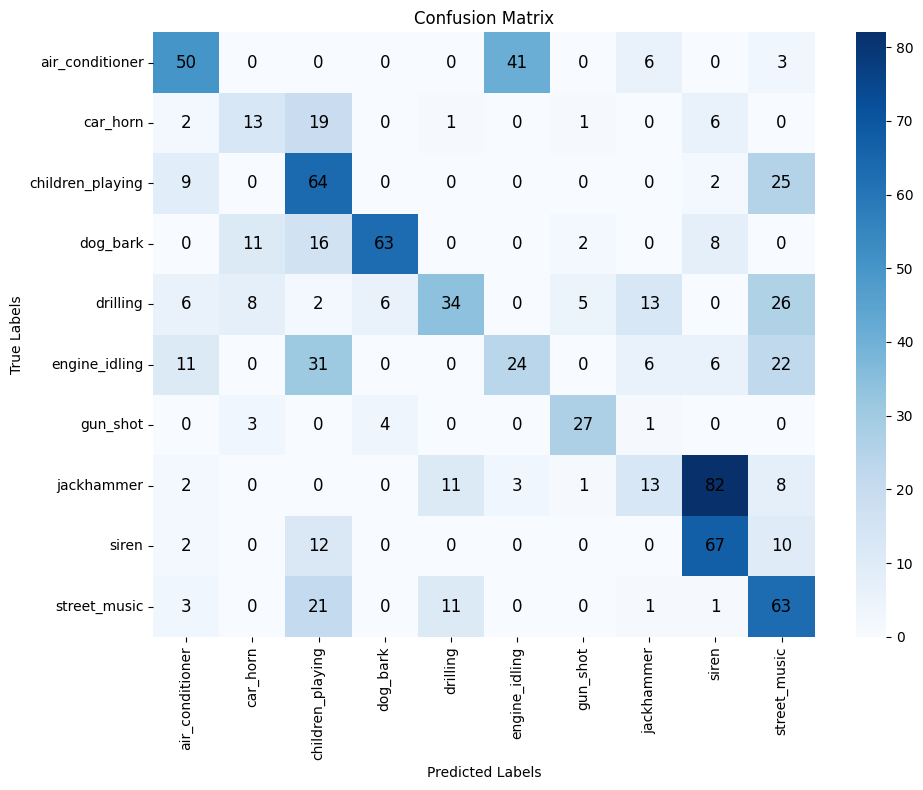

In [68]:
plt.figure(figsize=(10, 8))

ax = sns.heatmap(
    conf_matrix,
    cmap='Blues',
    cbar=True,
    xticklabels=class_names,
    yticklabels=class_names
)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        value = conf_matrix[i, j]
        ax.text(
            j + 0.5,
            i + 0.5,
            str(value),
            ha='center',
            va='center',
            fontsize=12,
        )

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [69]:
print("\nClassification Report")
print(classification_report(y_true=y_test_labels, y_pred=y_pred_labels))


Classification Report
              precision    recall  f1-score   support

           0       0.59      0.50      0.54       100
           1       0.37      0.31      0.34        42
           2       0.39      0.64      0.48       100
           3       0.86      0.63      0.73       100
           4       0.60      0.34      0.43       100
           5       0.35      0.24      0.29       100
           6       0.75      0.77      0.76        35
           7       0.33      0.11      0.16       120
           8       0.39      0.74      0.51        91
           9       0.40      0.63      0.49       100

    accuracy                           0.47       888
   macro avg       0.50      0.49      0.47       888
weighted avg       0.49      0.47      0.45       888



In [70]:
def plot_fold_results(history, y_test, y_pred, class_names, fold_number=1):

    # ---------- Convert one-hot to labels ----------
    if len(y_test.shape) > 1:
        y_test_labels = y_test.argmax(axis=1)
    else:
        y_test_labels = y_test

    if len(y_pred.shape) > 1:
        y_pred_labels = y_pred.argmax(axis=1)
    else:
        y_pred_labels = y_pred

    # ---------- Classification report ----------
    report = classification_report(
        y_test_labels,
        y_pred_labels,
        target_names=class_names,
        output_dict=True
    )

    precision_per_class = [report[name]['precision'] for name in class_names]
    f1_per_class        = [report[name]['f1-score'] for name in class_names]

    # ---------- Epochs as integers ----------
    n_epochs = len(history.history['accuracy'])
    epochs = list(range(1, n_epochs + 1))

    # ---------- Create figure ----------
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    # ------------------------------------------------
    # 1) Accuracy plot
    # ------------------------------------------------
    axs[0,0].plot(epochs, history.history['accuracy'], marker='o', label='Train Accuracy')
    axs[0,0].plot(epochs, history.history['val_accuracy'], marker='o', label='Val Accuracy')
    axs[0,0].set_title(f"Fold {fold_number} - Accuracy")
    axs[0,0].set_xlabel("Epoch")
    axs[0,0].set_ylabel("Accuracy")
    axs[0,0].set_xticks(epochs)
    axs[0,0].grid(alpha=0.3)
    axs[0,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[0,0].legend()

    # ------------------------------------------------
    # 2) Loss plot
    # ------------------------------------------------
    axs[0,1].plot(epochs, history.history['loss'], marker='o', label='Train Loss')
    axs[0,1].plot(epochs, history.history['val_loss'], marker='o', label='Val Loss')
    axs[0,1].set_title(f"Fold {fold_number} - Loss")
    axs[0,1].set_xlabel("Epoch")
    axs[0,1].set_ylabel("Loss")
    axs[0,1].set_xticks(epochs)
    axs[0,1].grid(alpha=0.3)
    axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[0,1].legend()

    # ------------------------------------------------
    # 3) Precision per class
    # ------------------------------------------------
    axs[1,0].bar(range(len(class_names)), precision_per_class, color="#a33891")
    axs[1,0].set_xticks(range(len(class_names)))
    axs[1,0].set_xticklabels(class_names, rotation=45)
    axs[1,0].set_title("Precision per Class")
    axs[1,0].set_xlabel("Class")
    axs[1,0].set_ylabel("Precision")
    axs[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # ------------------------------------------------
    # 4) F1-score per class
    # ------------------------------------------------
    axs[1,1].bar(range(len(class_names)), f1_per_class, color="#38a38c")
    axs[1,1].set_xticks(range(len(class_names)))
    axs[1,1].set_xticklabels(class_names, rotation=45)
    axs[1,1].set_title("F1-score per Class")
    axs[1,1].set_xlabel("Class")
    axs[1,1].set_ylabel("F1-score")
    axs[1,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.tight_layout()
    plt.show()


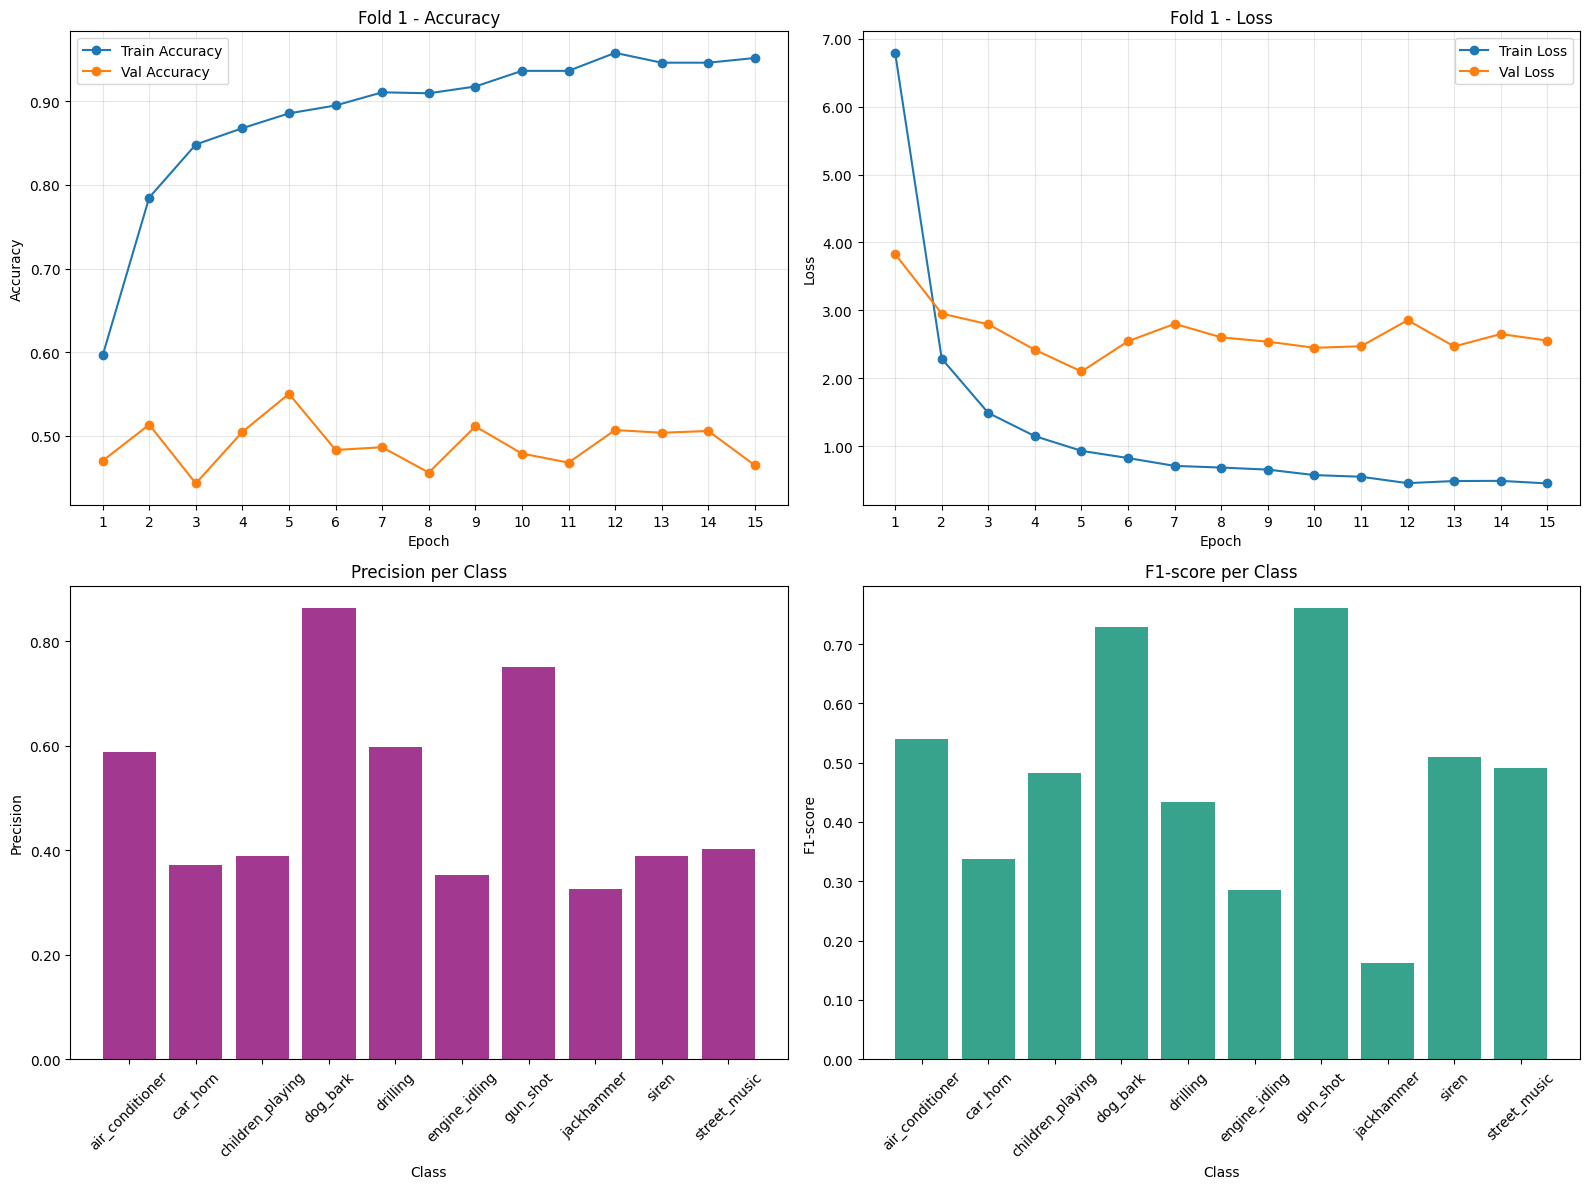

In [71]:
plot_fold_results(history, y_test_labels, y_pred_labels, class_names, fold_number=1)

#### Conclusions of multiple tests <a name = "crnn_rnn"></a>
[[back to Model Testing - RNN]](#rnn_tm)

After performing several manual tests — both with and without embeddings — we identified a few relevant conclusions:

- The **hidden_dim** parameter proved to be the most influential in both performance and computational cost. In general, higher values led to better results but significantly increased the time and resources required to train the model.

- **High dropout rates** degraded performance, limiting the model’s learning capacity. Nevertheless, a moderate amount of dropout remains useful for mitigating overfitting, requiring a careful balance between regularization and representational capacity.

- The **use of embeddings** did not yield improvements in generalization. One possible explanation is that the LTE relies on a relatively simple architecture for a problem with high variability and noise, which may prevent it from generating embeddings that are sufficiently discriminative for the RNN. As a result, directly using the MFCC features proved to be more effective.

### Second stage

In this second phase, we performed a full evaluation of the RNN model using **10-fold cross-validation**. Based on the manual tests carried out in the previous stage, we concluded that the LTE was unable to generate sufficiently discriminative embeddings to improve the model’s performance. For this reason, we chose **not to use embeddings in this phase**, training the RNN directly on the MFCC features.

Thus, the data is divided according to the following logic:

In each iteration:

- **1 fold** is used for **testing**
- **1 fold** is used for **validation**
- the **remaining 8 folds** are used to **train** the RNN model.

Below is the code used to perform the **10-fold cross-validation without embeddings.**

Epoch 1/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6633 - loss: 1.8412 - val_accuracy: 0.6199 - val_loss: 0.9904 - learning_rate: 0.0010
Epoch 2/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7198 - loss: 0.7479 - val_accuracy: 0.6453 - val_loss: 0.9356 - learning_rate: 0.0010
Epoch 3/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7356 - loss: 0.7101 - val_accuracy: 0.6594 - val_loss: 0.8810 - learning_rate: 0.0010
Epoch 4/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7420 - loss: 0.6938 - val_accuracy: 0.6594 - val_loss: 0.8973 - learning_rate: 0.0010
Epoch 5/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7491 - loss: 0.6823 - val_accuracy: 0.6537 - val_loss: 0.8876 - learning_rate: 0.0010
Epoch 6/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7532 - loss: 0.6725 - val_accuracy: 0.6620 - val_loss: 0.8982 - learning_rate: 0.0010
Epoch 7/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7

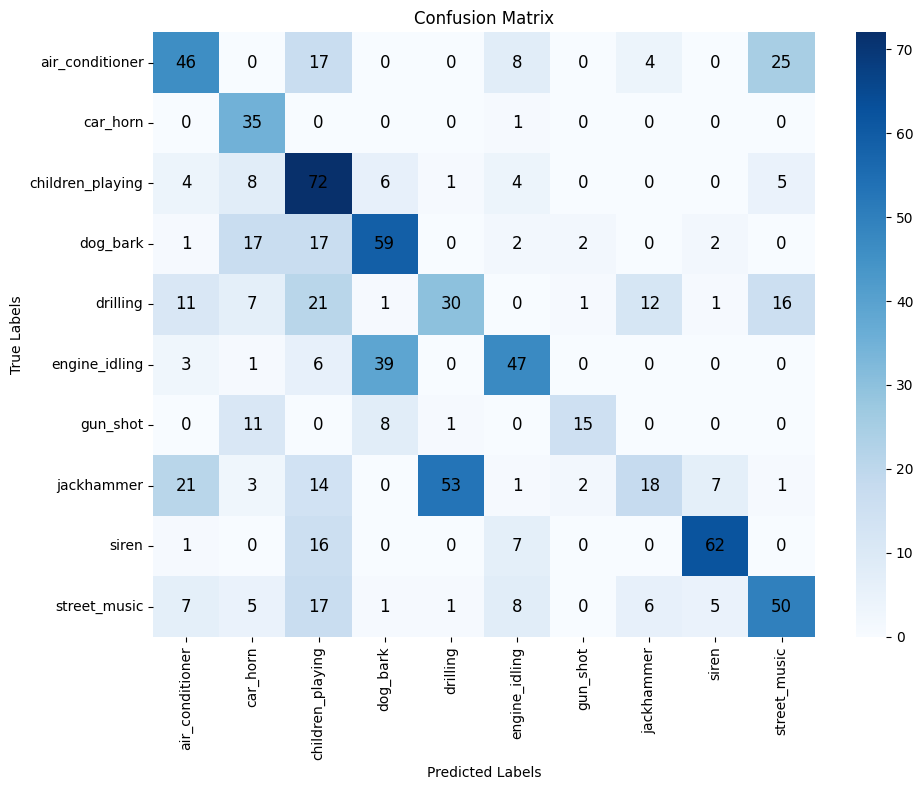


Classification Report
              precision    recall  f1-score   support

           0       0.49      0.46      0.47       100
           1       0.40      0.97      0.57        36
           2       0.40      0.72      0.51       100
           3       0.52      0.59      0.55       100
           4       0.35      0.30      0.32       100
           5       0.60      0.49      0.54        96
           6       0.75      0.43      0.55        35
           7       0.45      0.15      0.23       120
           8       0.81      0.72      0.76        86
           9       0.52      0.50      0.51       100

    accuracy                           0.50       873
   macro avg       0.53      0.53      0.50       873
weighted avg       0.51      0.50      0.48       873



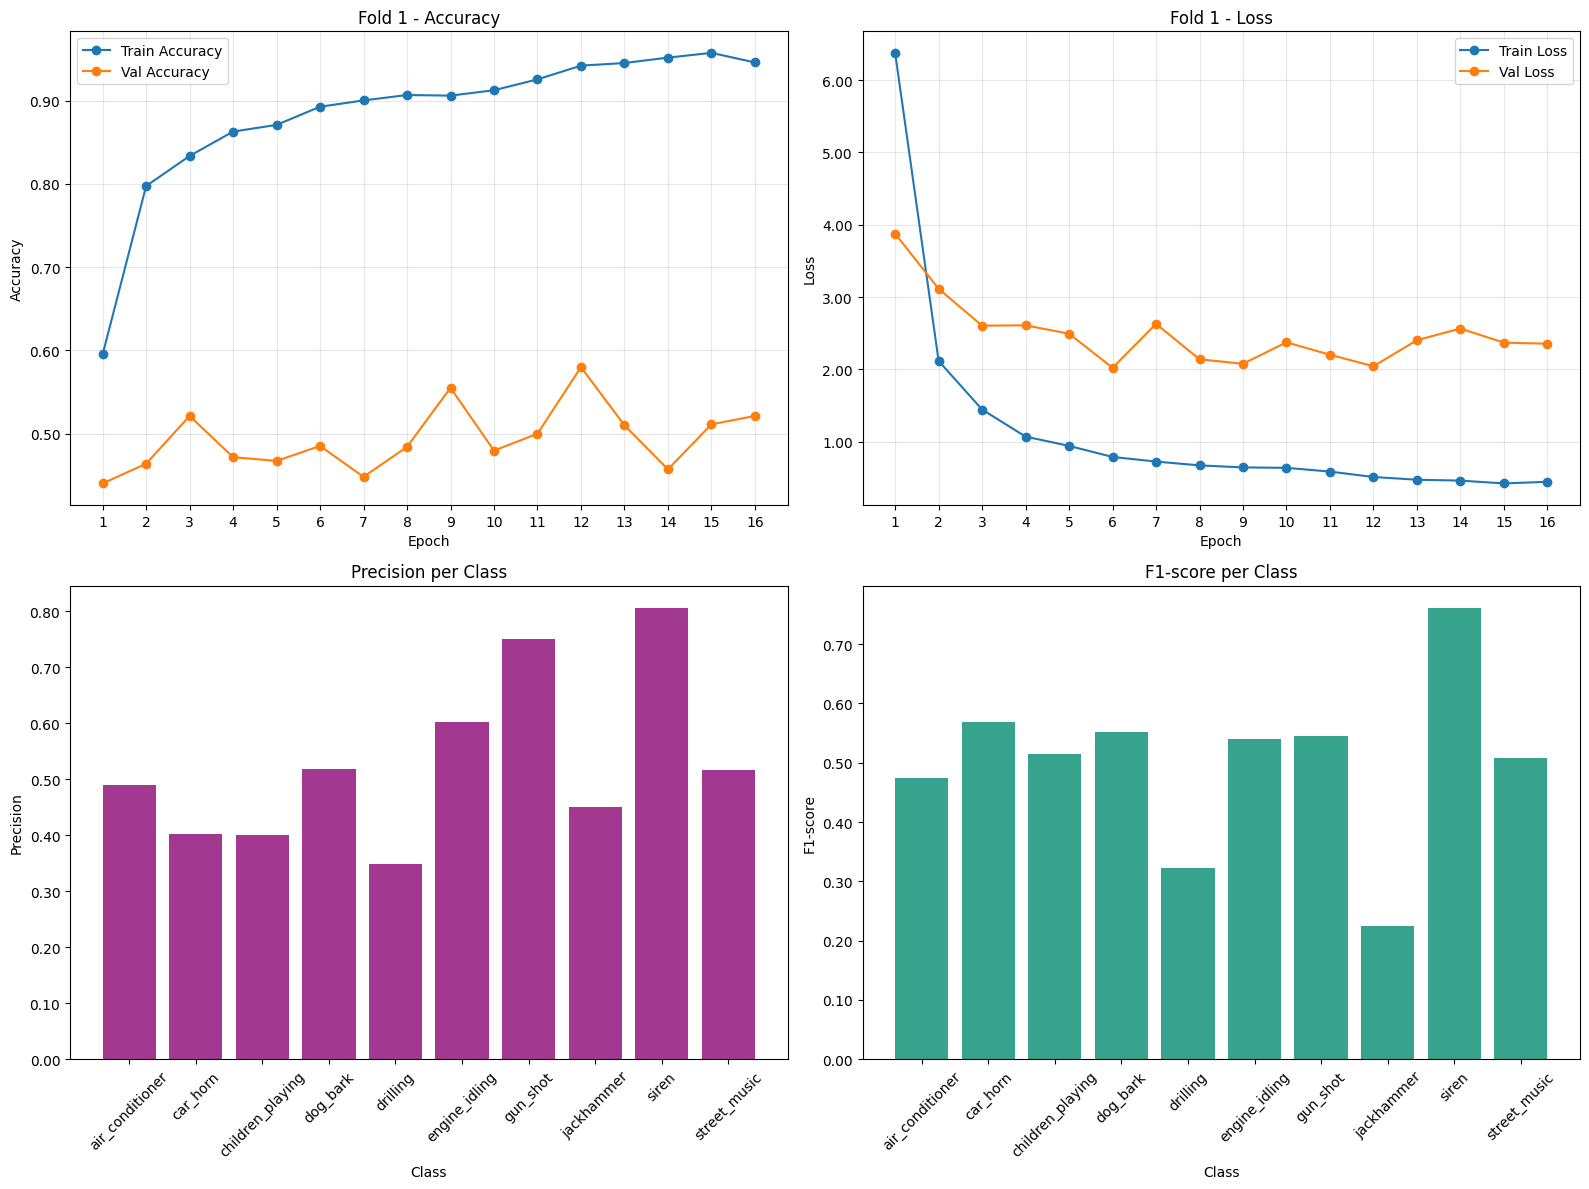

Epoch 1/100
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6079 - loss: 3.3452 - val_accuracy: 0.6331 - val_loss: 1.0447 - learning_rate: 0.0010
Epoch 2/100
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7001 - loss: 0.8234 - val_accuracy: 0.5940 - val_loss: 1.0219 - learning_rate: 0.0010
Epoch 3/100
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7142 - loss: 0.7651 - val_accuracy: 0.6395 - val_loss: 0.9566 - learning_rate: 0.0010
Epoch 4/100
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7297 - loss: 0.7238 - val_accuracy: 0.6495 - val_loss: 1.0075 - learning_rate: 0.0010
Epoch 5/100
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7412 - loss: 0.6952 - val_accuracy: 0.6586 - val_loss: 0.9254 - learning_rate: 0.0010
Epoch 6/100
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7497 - loss: 0.6706 - val_accuracy: 0.6665 - val_loss: 0.9099 - learning_rate: 0.0010
Epoch 7/100
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7

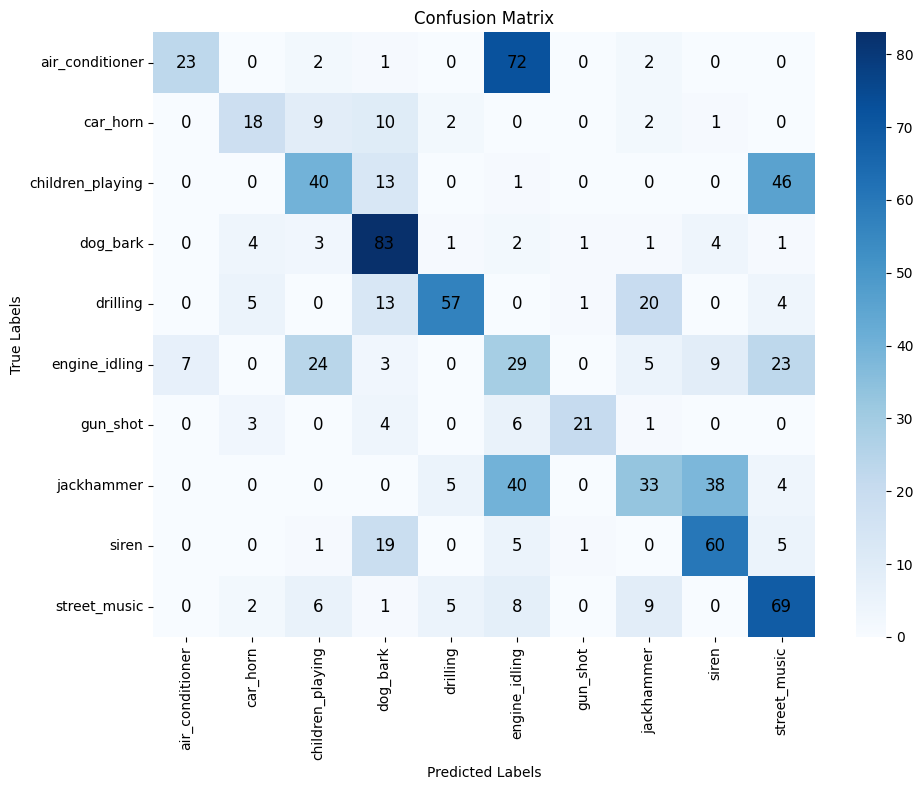


Classification Report
              precision    recall  f1-score   support

           0       0.77      0.23      0.35       100
           1       0.56      0.43      0.49        42
           2       0.47      0.40      0.43       100
           3       0.56      0.83      0.67       100
           4       0.81      0.57      0.67       100
           5       0.18      0.29      0.22       100
           6       0.88      0.60      0.71        35
           7       0.45      0.28      0.34       120
           8       0.54      0.66      0.59        91
           9       0.45      0.69      0.55       100

    accuracy                           0.49       888
   macro avg       0.57      0.50      0.50       888
weighted avg       0.54      0.49      0.48       888



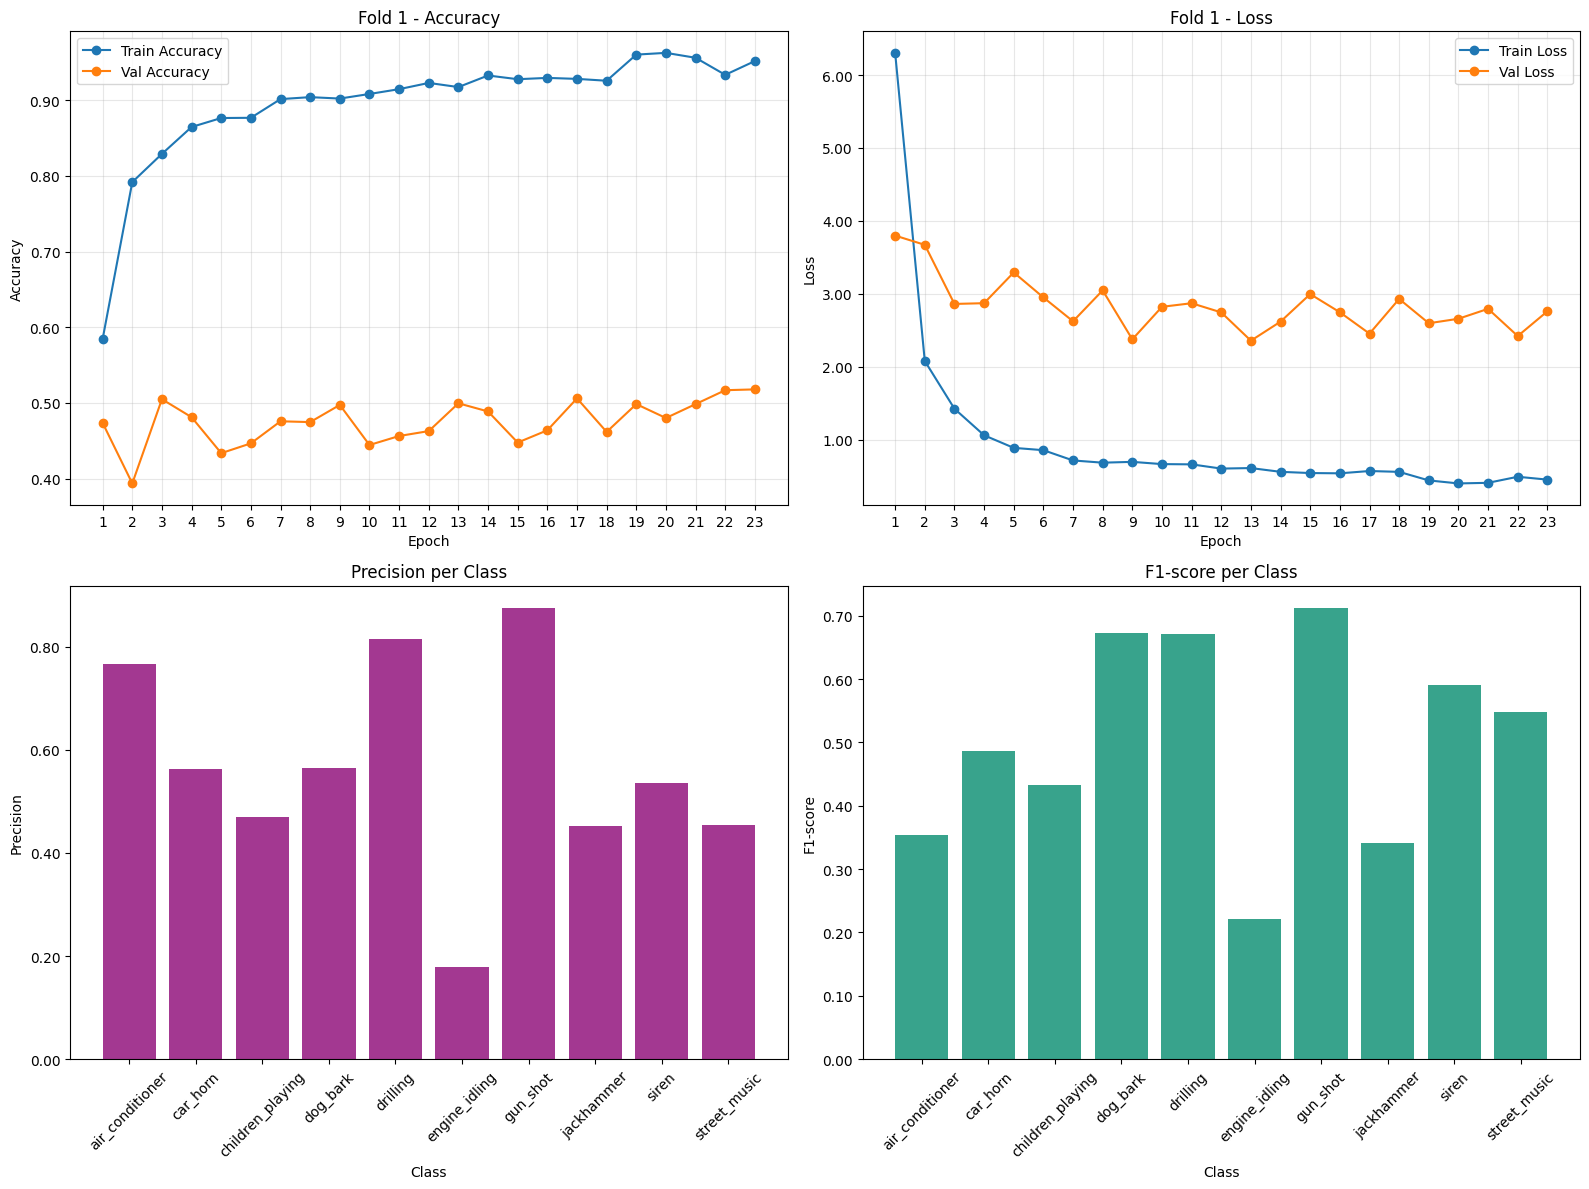

Epoch 1/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5988 - loss: 3.2623 - val_accuracy: 0.6242 - val_loss: 0.9874 - learning_rate: 0.0010
Epoch 2/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6982 - loss: 0.7924 - val_accuracy: 0.5878 - val_loss: 0.9424 - learning_rate: 0.0010
Epoch 3/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7117 - loss: 0.7578 - val_accuracy: 0.6401 - val_loss: 0.9222 - learning_rate: 0.0010
Epoch 4/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7247 - loss: 0.7275 - val_accuracy: 0.6603 - val_loss: 0.8932 - learning_rate: 0.0010
Epoch 5/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7385 - loss: 0.7030 - val_accuracy: 0.6642 - val_loss: 0.8889 - learning_rate: 0.0010
Epoch 6/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7451 - loss: 0.6871 - val_accuracy: 0.6405 - val_loss: 0.9358 - learning_rate: 0.0010
Epoch 7/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7

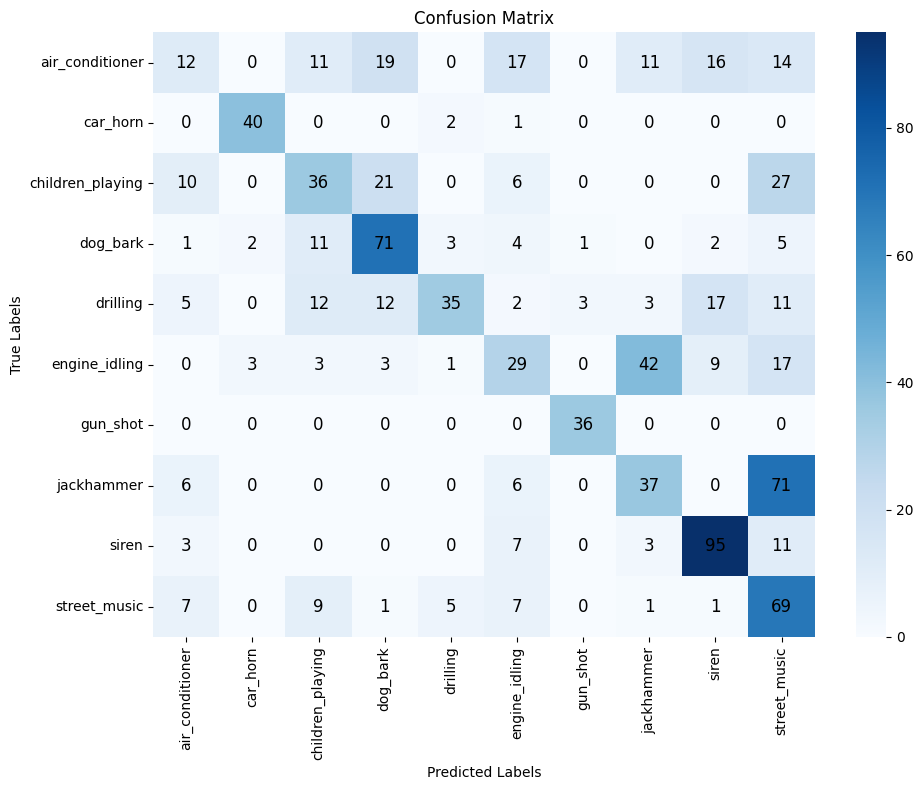


Classification Report
              precision    recall  f1-score   support

           0       0.27      0.12      0.17       100
           1       0.89      0.93      0.91        43
           2       0.44      0.36      0.40       100
           3       0.56      0.71      0.63       100
           4       0.76      0.35      0.48       100
           5       0.37      0.27      0.31       107
           6       0.90      1.00      0.95        36
           7       0.38      0.31      0.34       120
           8       0.68      0.80      0.73       119
           9       0.31      0.69      0.42       100

    accuracy                           0.50       925
   macro avg       0.56      0.55      0.53       925
weighted avg       0.51      0.50      0.48       925



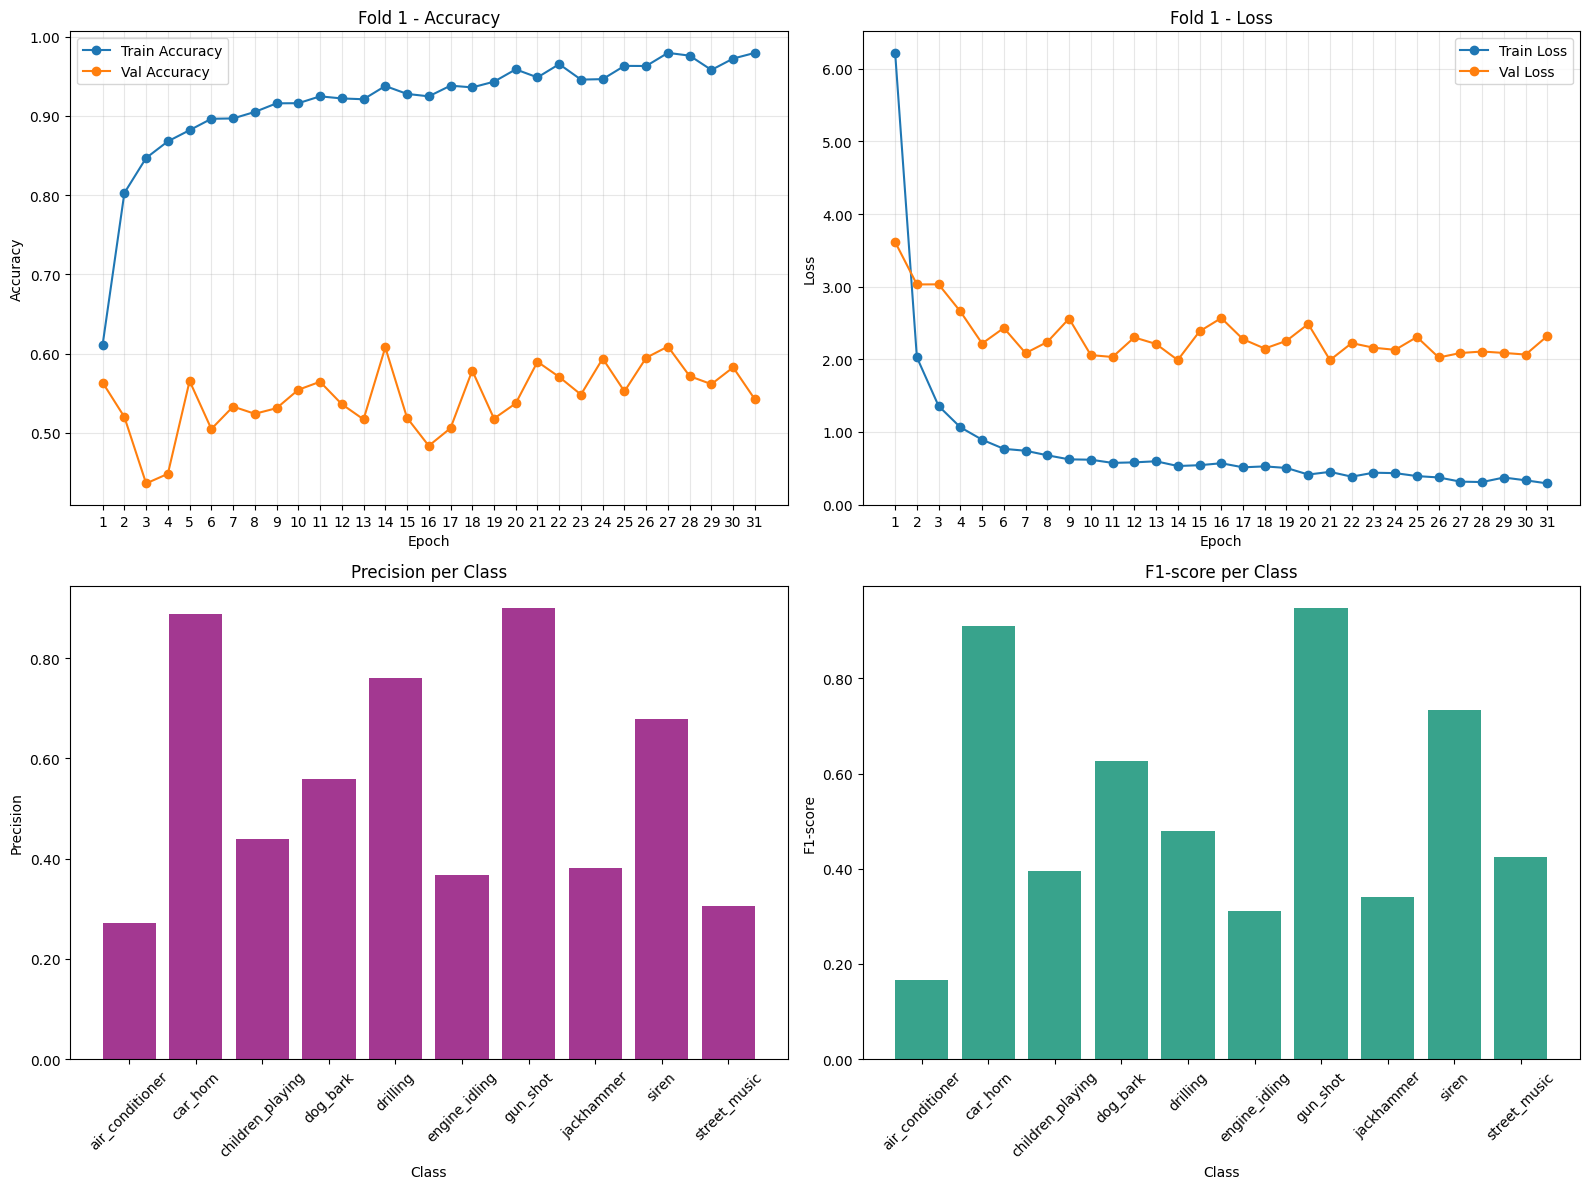

Epoch 1/100
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6369 - loss: 2.0060 - val_accuracy: 0.6105 - val_loss: 0.9546 - learning_rate: 0.0010
Epoch 2/100
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7008 - loss: 0.7882 - val_accuracy: 0.6346 - val_loss: 0.9040 - learning_rate: 0.0010
Epoch 3/100
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7208 - loss: 0.7389 - val_accuracy: 0.6562 - val_loss: 0.9055 - learning_rate: 0.0010
Epoch 4/100
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7336 - loss: 0.7104 - val_accuracy: 0.6583 - val_loss: 0.9045 - learning_rate: 0.0010
Epoch 5/100
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7377 - loss: 0.6968 - val_accuracy: 0.6501 - val_loss: 0.9199 - learning_rate: 0.0010
Epoch 6/100
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7415 - loss: 0.6889 - val_accuracy: 0.6553 - val_loss: 0.9233 - learning_rate: 0.0010
Epoch 7/100
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7

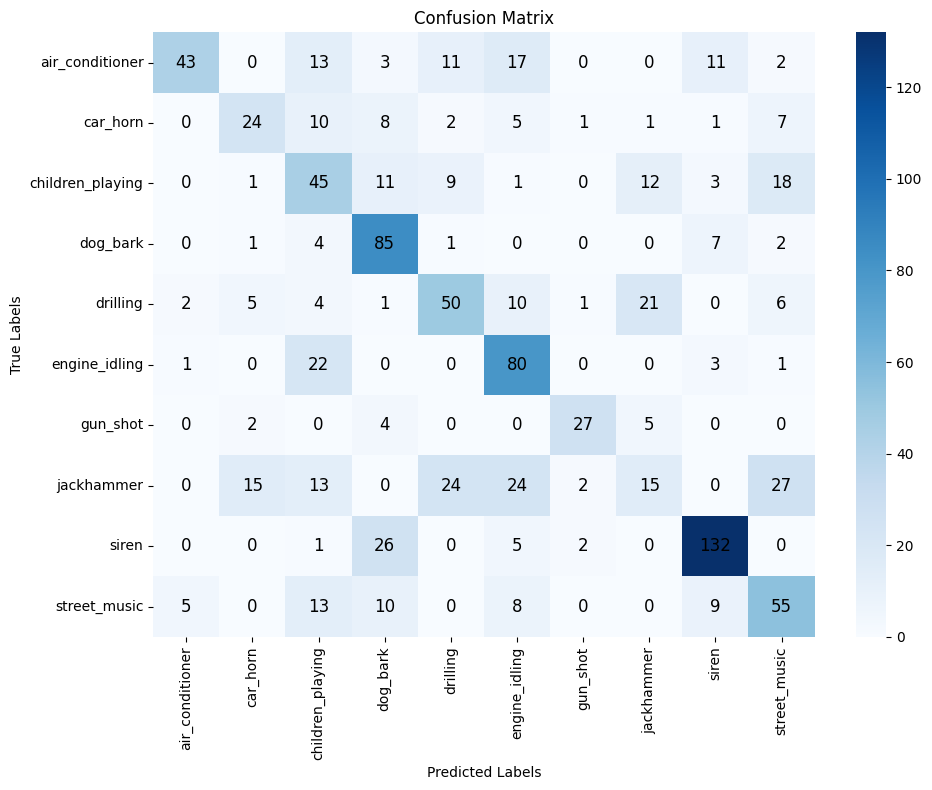


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.43      0.57       100
           1       0.50      0.41      0.45        59
           2       0.36      0.45      0.40       100
           3       0.57      0.85      0.69       100
           4       0.52      0.50      0.51       100
           5       0.53      0.75      0.62       107
           6       0.82      0.71      0.76        38
           7       0.28      0.12      0.17       120
           8       0.80      0.80      0.80       166
           9       0.47      0.55      0.50       100

    accuracy                           0.56       990
   macro avg       0.57      0.56      0.55       990
weighted avg       0.56      0.56      0.55       990



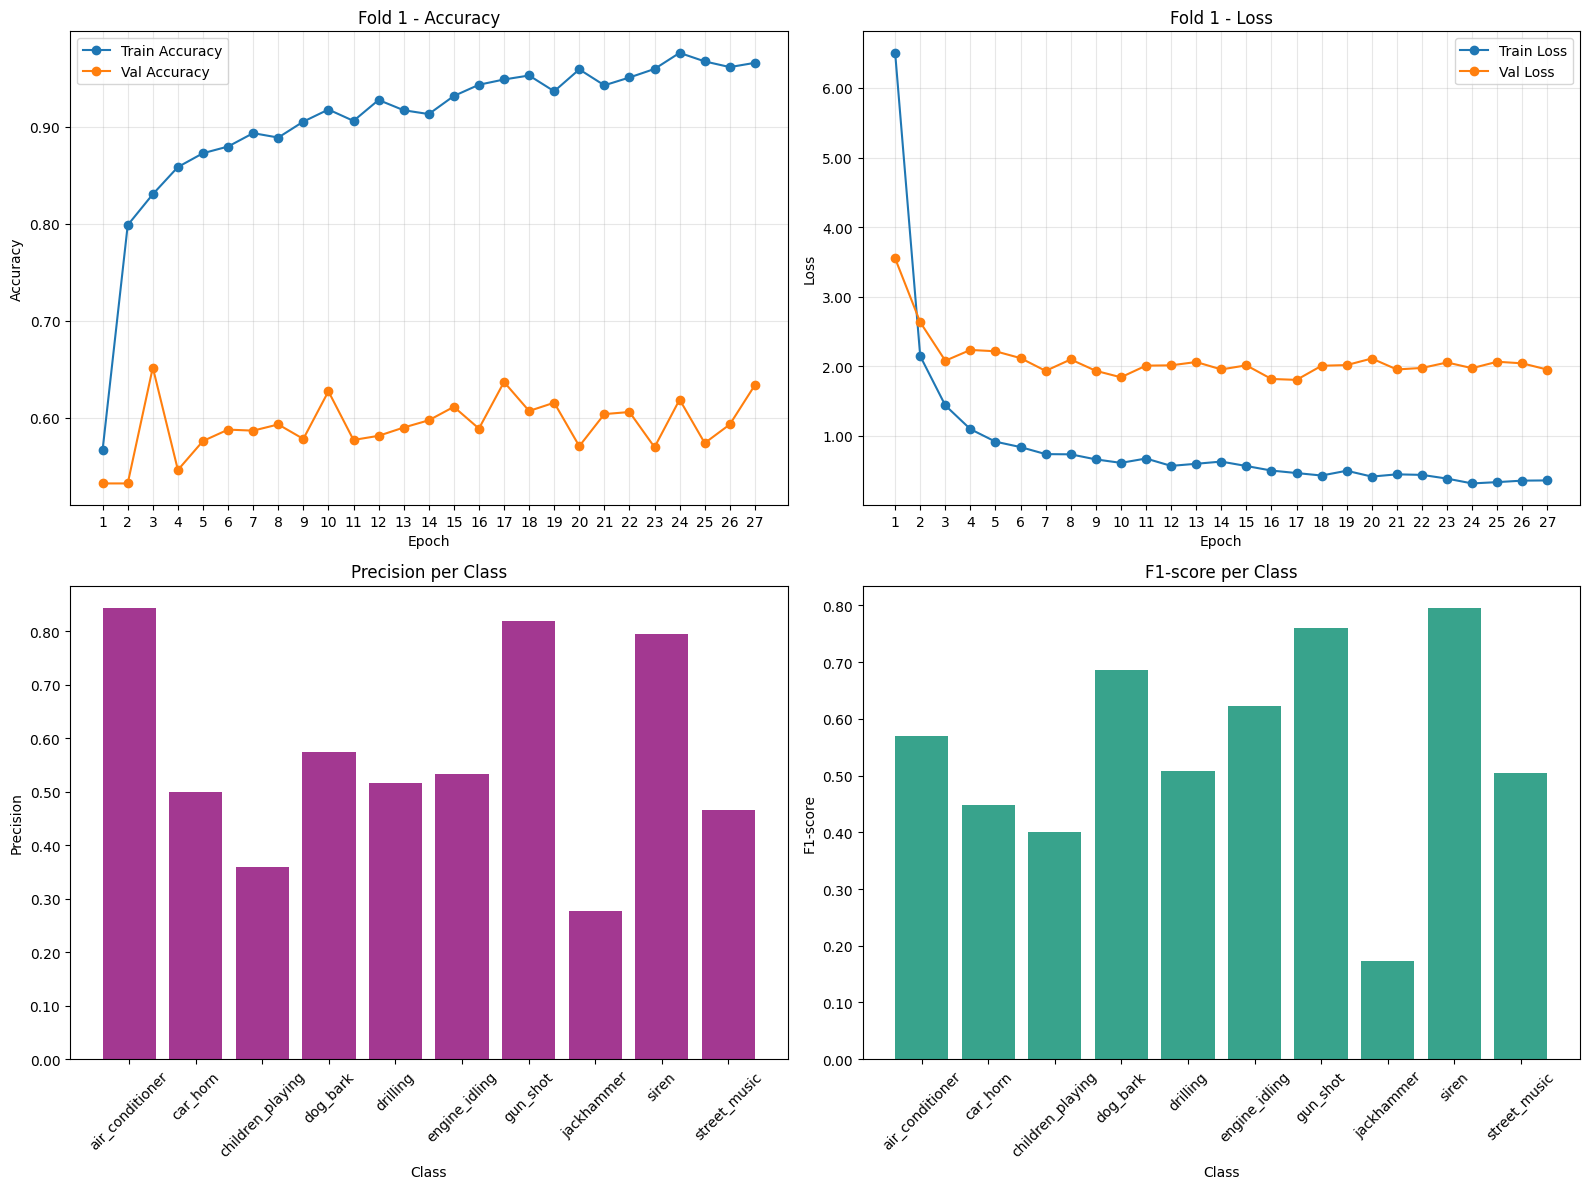

Epoch 1/100
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6101 - loss: 1.2175 - val_accuracy: 0.6242 - val_loss: 1.0172 - learning_rate: 0.0010
Epoch 2/100
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6654 - loss: 0.8696 - val_accuracy: 0.6311 - val_loss: 0.9456 - learning_rate: 0.0010
Epoch 3/100
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6872 - loss: 0.8056 - val_accuracy: 0.6447 - val_loss: 0.9442 - learning_rate: 0.0010
Epoch 4/100
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7125 - loss: 0.7555 - val_accuracy: 0.6601 - val_loss: 0.8874 - learning_rate: 0.0010
Epoch 5/100
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7257 - loss: 0.7246 - val_accuracy: 0.6470 - val_loss: 0.8905 - learning_rate: 0.0010
Epoch 6/100
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7300 - loss: 0.7058 - val_accuracy: 0.6542 - val_loss: 0.8728 - learning_rate: 0.0010
Epoch 7/100
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7

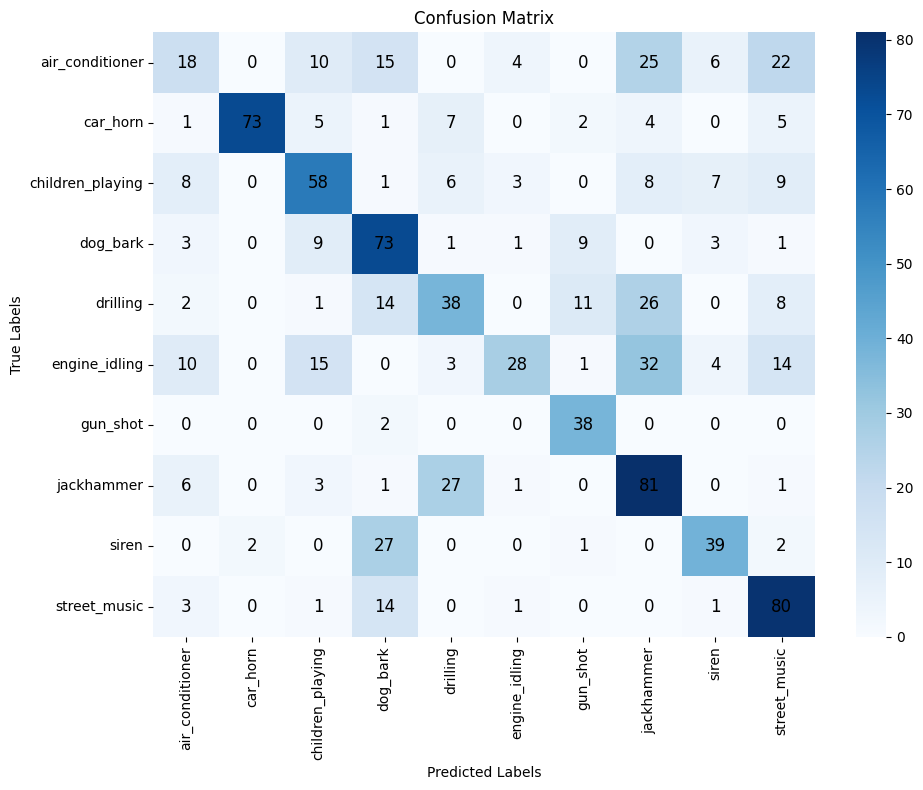


Classification Report
              precision    recall  f1-score   support

           0       0.35      0.18      0.24       100
           1       0.97      0.74      0.84        98
           2       0.57      0.58      0.57       100
           3       0.49      0.73      0.59       100
           4       0.46      0.38      0.42       100
           5       0.74      0.26      0.39       107
           6       0.61      0.95      0.75        40
           7       0.46      0.68      0.55       120
           8       0.65      0.55      0.60        71
           9       0.56      0.80      0.66       100

    accuracy                           0.56       936
   macro avg       0.59      0.59      0.56       936
weighted avg       0.58      0.56      0.54       936



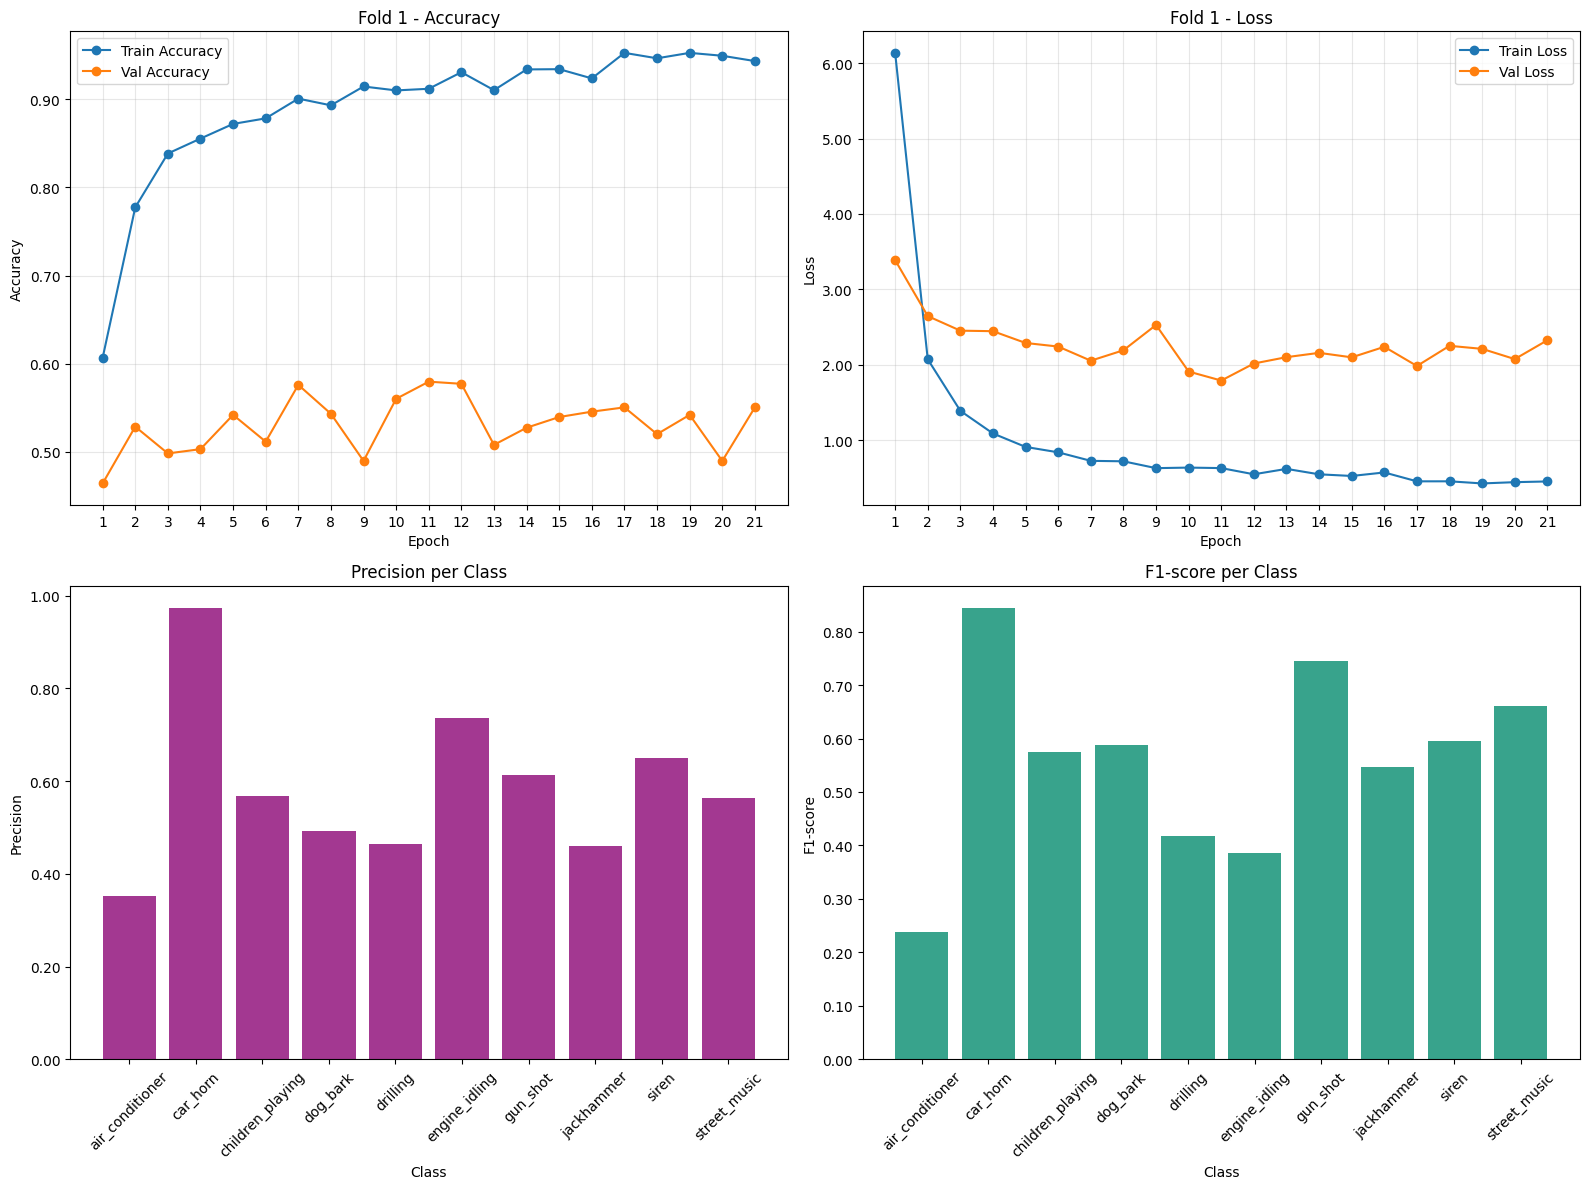

Epoch 1/100
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6255 - loss: 3.4673 - val_accuracy: 0.6249 - val_loss: 0.9948 - learning_rate: 0.0010
Epoch 2/100
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7065 - loss: 0.7958 - val_accuracy: 0.6316 - val_loss: 0.9106 - learning_rate: 0.0010
Epoch 3/100
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7140 - loss: 0.7677 - val_accuracy: 0.6281 - val_loss: 0.9177 - learning_rate: 0.0010
Epoch 4/100
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7166 - loss: 0.7564 - val_accuracy: 0.6035 - val_loss: 1.1830 - learning_rate: 0.0010
Epoch 5/100
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7237 - loss: 0.7394 - val_accuracy: 0.6159 - val_loss: 1.0043 - learning_rate: 0.0010
Epoch 6/100
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7285 - loss: 0.7253 - val_accuracy: 0.6199 - val_loss: 1.0393 - learning_rate: 0.0010
Epoch 7/100
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7

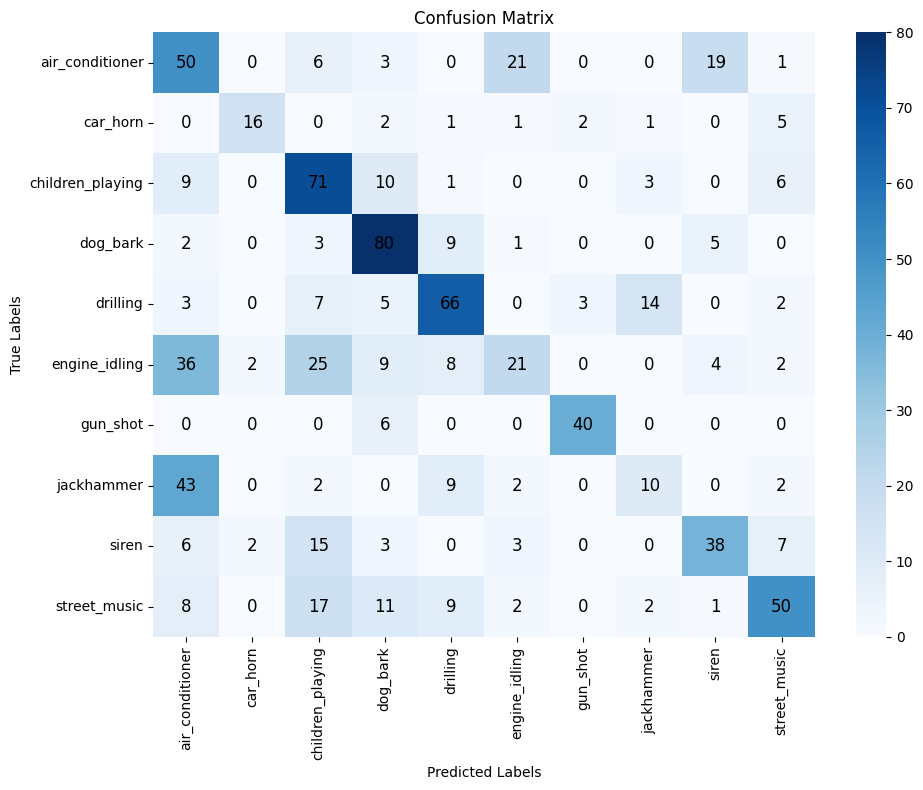


Classification Report
              precision    recall  f1-score   support

           0       0.32      0.50      0.39       100
           1       0.80      0.57      0.67        28
           2       0.49      0.71      0.58       100
           3       0.62      0.80      0.70       100
           4       0.64      0.66      0.65       100
           5       0.41      0.20      0.27       107
           6       0.89      0.87      0.88        46
           7       0.33      0.15      0.20        68
           8       0.57      0.51      0.54        74
           9       0.67      0.50      0.57       100

    accuracy                           0.54       823
   macro avg       0.57      0.55      0.54       823
weighted avg       0.54      0.54      0.52       823



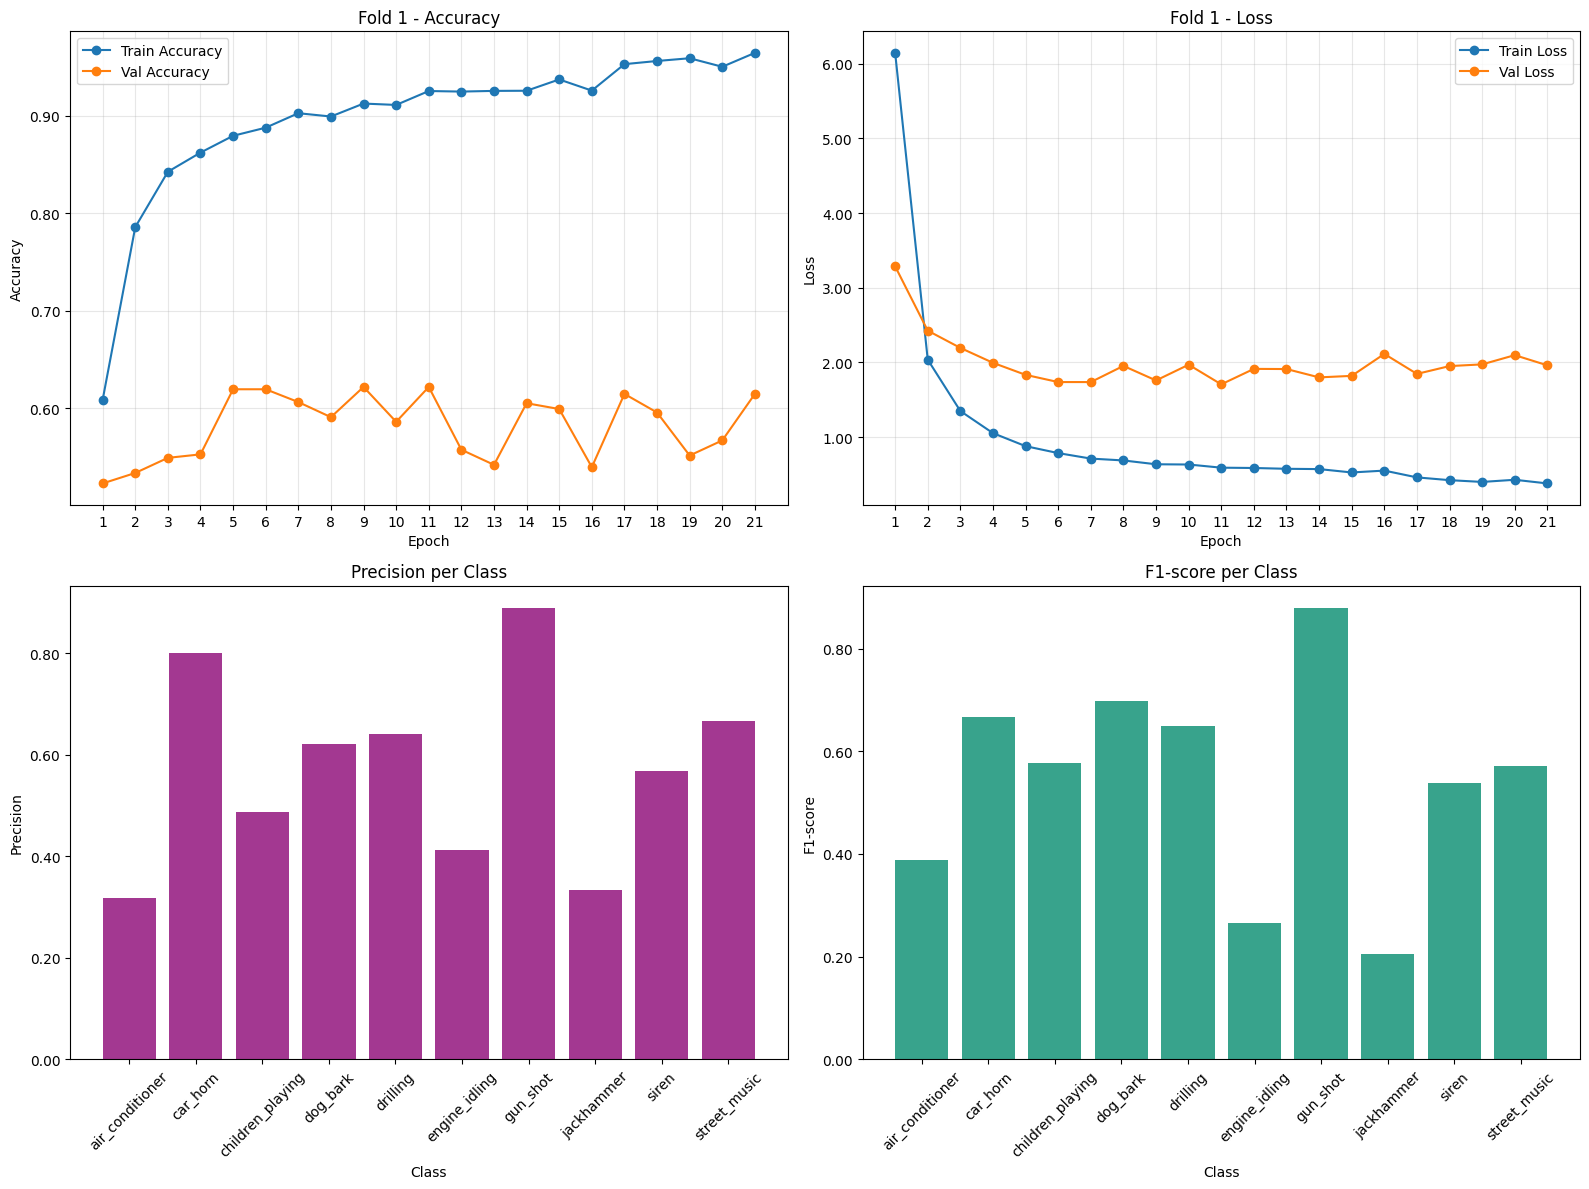

Epoch 1/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5665 - loss: 5.1798 - val_accuracy: 0.6268 - val_loss: 1.0416 - learning_rate: 0.0010
Epoch 2/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6996 - loss: 0.8266 - val_accuracy: 0.6273 - val_loss: 0.9608 - learning_rate: 0.0010
Epoch 3/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7182 - loss: 0.7475 - val_accuracy: 0.6391 - val_loss: 0.9231 - learning_rate: 0.0010
Epoch 4/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7342 - loss: 0.6987 - val_accuracy: 0.6455 - val_loss: 0.9131 - learning_rate: 0.0010
Epoch 5/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7522 - loss: 0.6680 - val_accuracy: 0.6623 - val_loss: 0.9186 - learning_rate: 0.0010
Epoch 6/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7621 - loss: 0.6467 - val_accuracy: 0.6682 - val_loss: 0.9065 - learning_rate: 0.0010
Epoch 7/100
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7

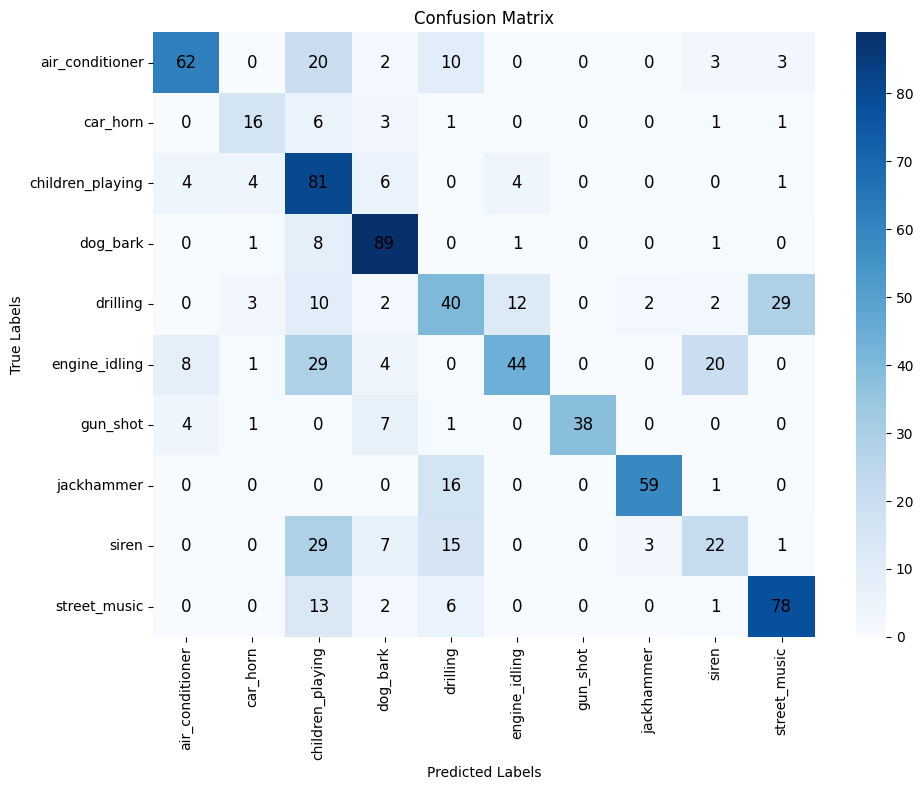


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.62      0.70       100
           1       0.62      0.57      0.59        28
           2       0.41      0.81      0.55       100
           3       0.73      0.89      0.80       100
           4       0.45      0.40      0.42       100
           5       0.72      0.42      0.53       106
           6       1.00      0.75      0.85        51
           7       0.92      0.78      0.84        76
           8       0.43      0.29      0.34        77
           9       0.69      0.78      0.73       100

    accuracy                           0.63       838
   macro avg       0.68      0.63      0.64       838
weighted avg       0.66      0.63      0.63       838



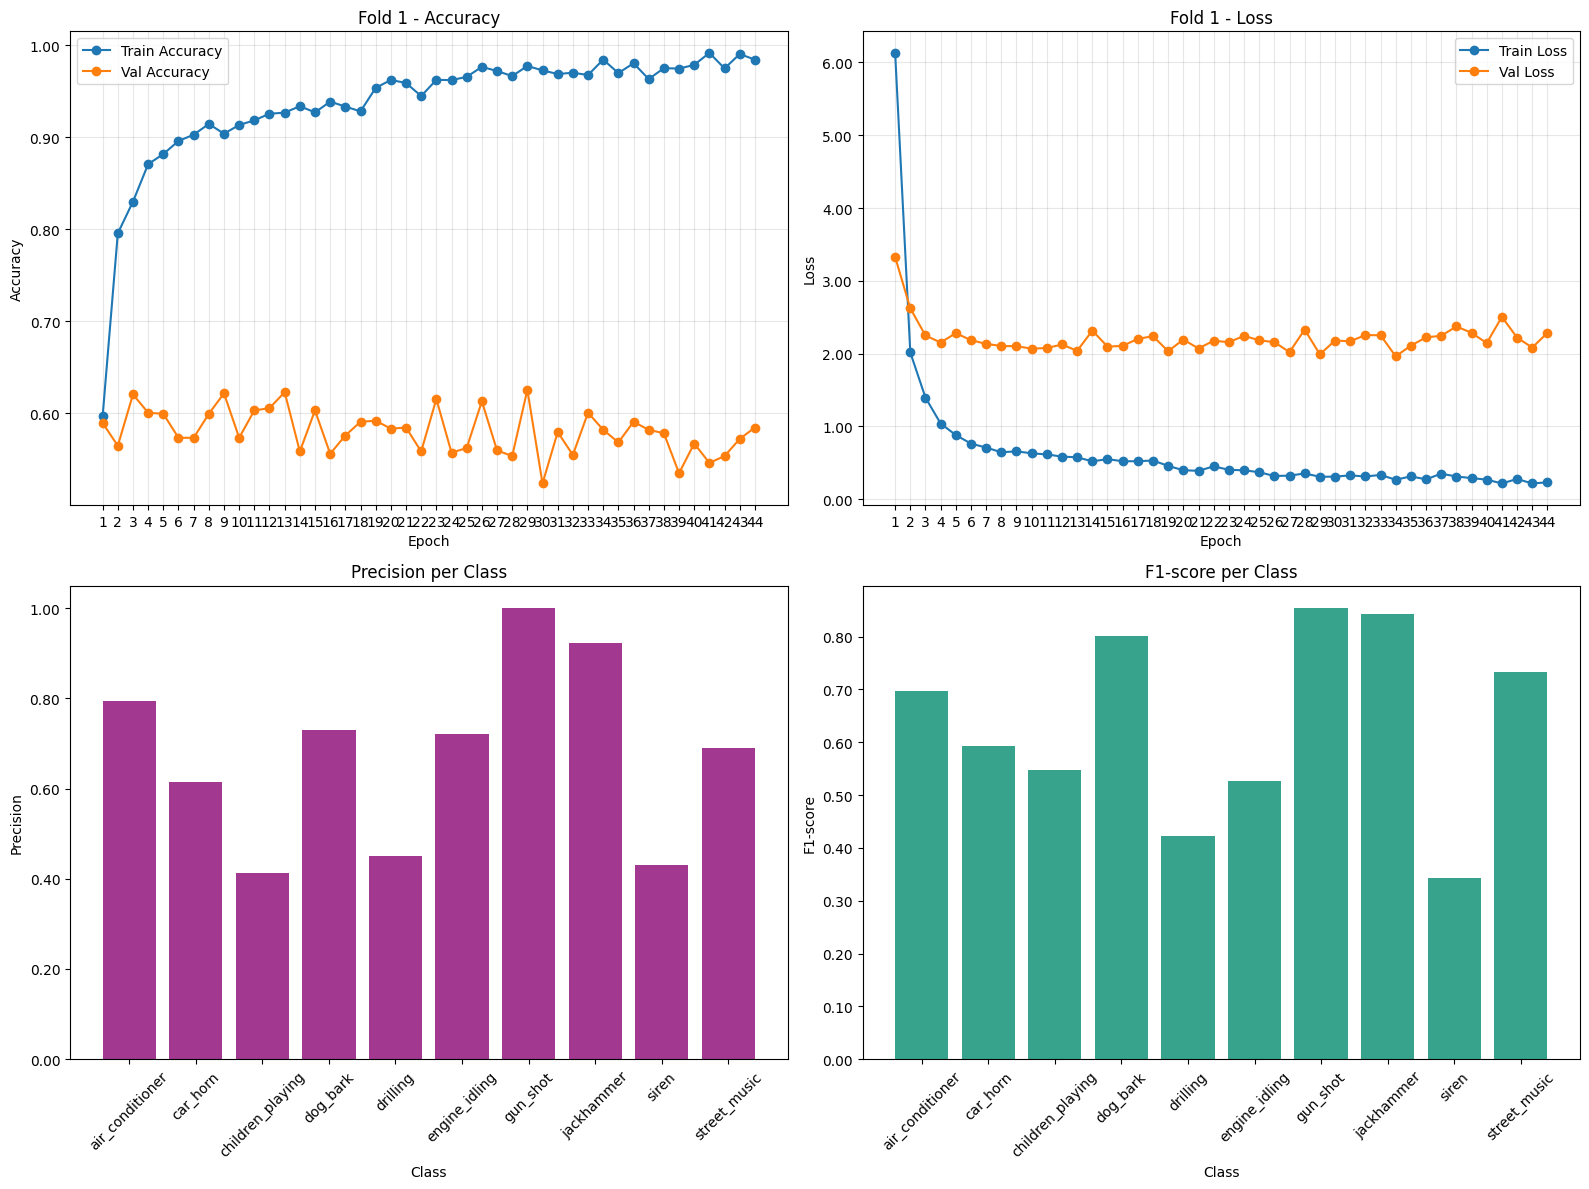

Epoch 1/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5956 - loss: 7.1453 - val_accuracy: 0.6237 - val_loss: 1.0287 - learning_rate: 0.0010
Epoch 2/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7015 - loss: 0.8319 - val_accuracy: 0.6341 - val_loss: 0.9689 - learning_rate: 0.0010
Epoch 3/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7141 - loss: 0.7754 - val_accuracy: 0.6496 - val_loss: 0.9164 - learning_rate: 0.0010
Epoch 4/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7250 - loss: 0.7446 - val_accuracy: 0.6464 - val_loss: 0.9083 - learning_rate: 0.0010
Epoch 5/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7366 - loss: 0.7153 - val_accuracy: 0.6576 - val_loss: 0.8844 - learning_rate: 0.0010
Epoch 6/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7510 - loss: 0.6852 - val_accuracy: 0.6397 - val_loss: 1.0175 - learning_rate: 0.0010
Epoch 7/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.

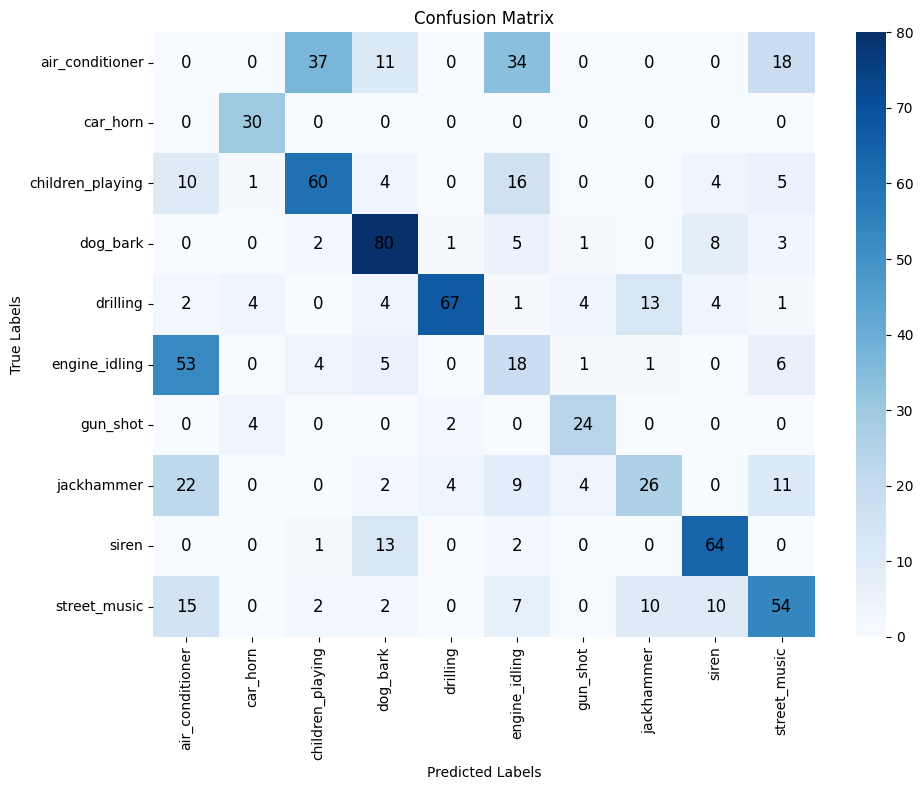


Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.77      1.00      0.87        30
           2       0.57      0.60      0.58       100
           3       0.66      0.80      0.72       100
           4       0.91      0.67      0.77       100
           5       0.20      0.20      0.20        88
           6       0.71      0.80      0.75        30
           7       0.52      0.33      0.41        78
           8       0.71      0.80      0.75        80
           9       0.55      0.54      0.55       100

    accuracy                           0.52       806
   macro avg       0.56      0.57      0.56       806
weighted avg       0.53      0.52      0.52       806



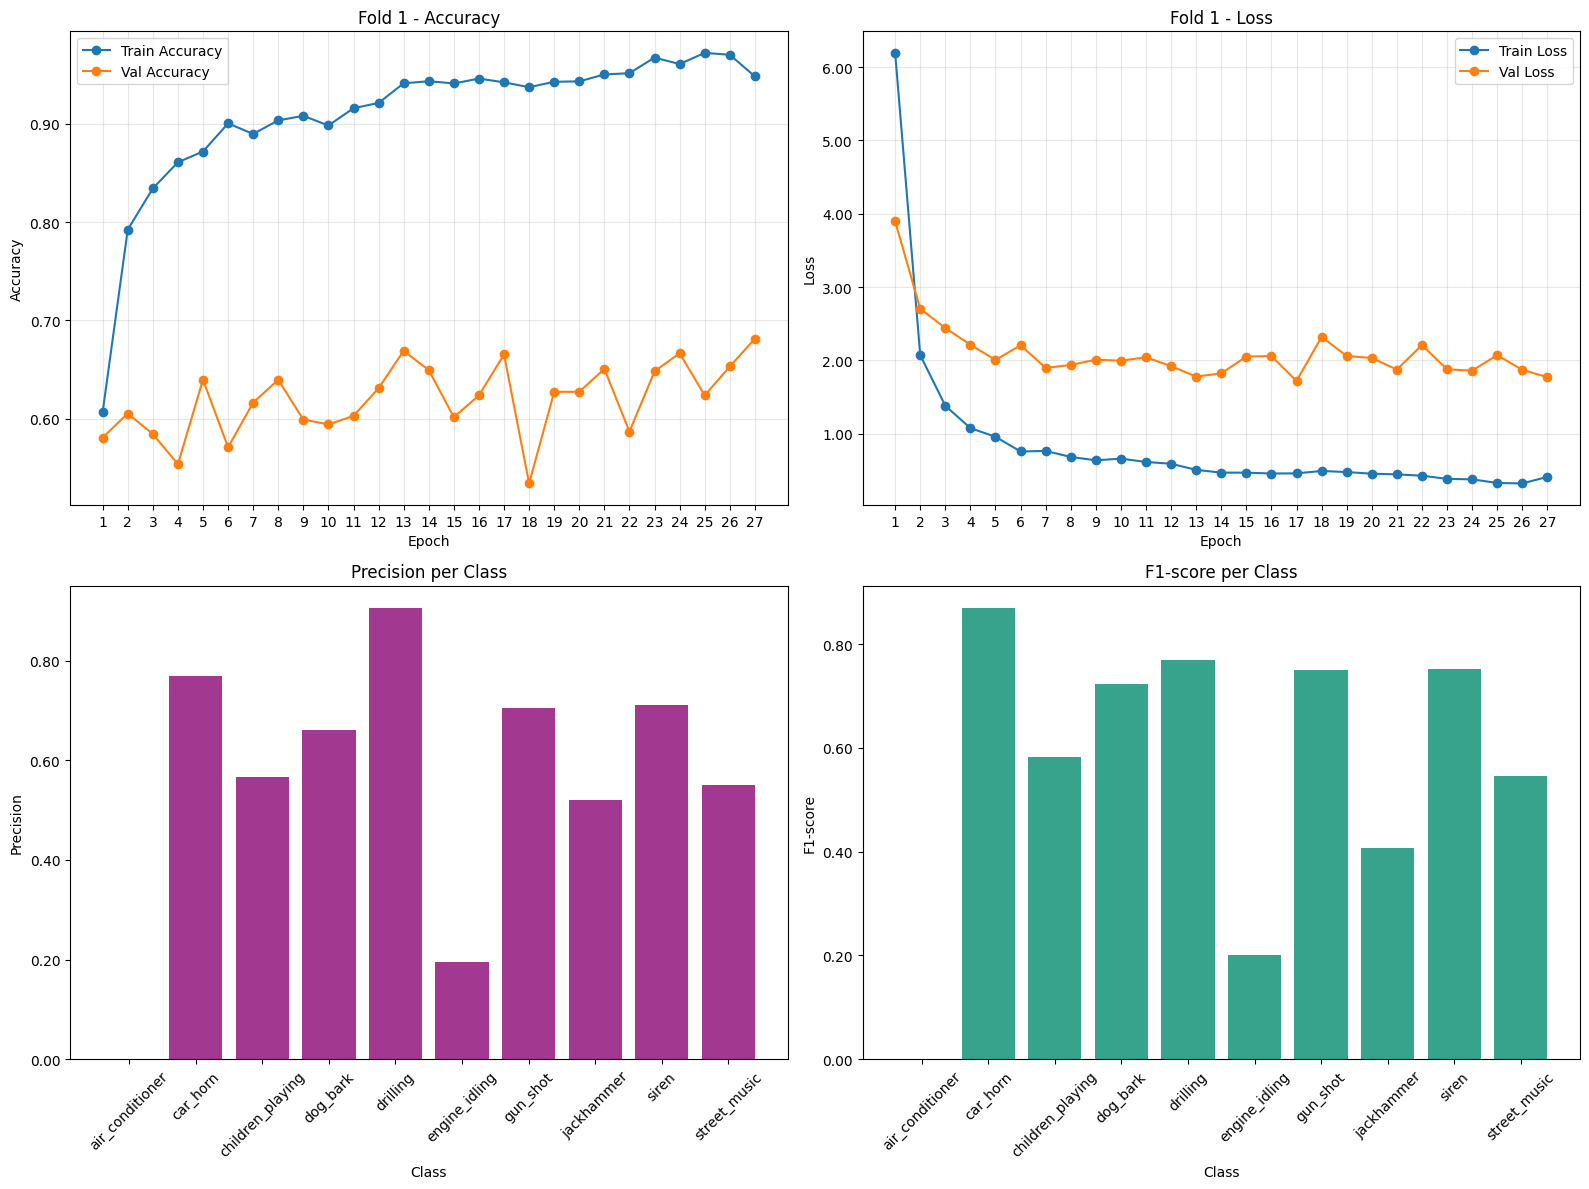

Epoch 1/100
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.6245 - loss: 3.8086 - val_accuracy: 0.6177 - val_loss: 1.0779 - learning_rate: 0.0010
Epoch 2/100
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7215 - loss: 0.7627 - val_accuracy: 0.5939 - val_loss: 0.9526 - learning_rate: 0.0010
Epoch 3/100
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7439 - loss: 0.7098 - val_accuracy: 0.6577 - val_loss: 0.9287 - learning_rate: 0.0010
Epoch 4/100
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7490 - loss: 0.6919 - val_accuracy: 0.6575 - val_loss: 0.9533 - learning_rate: 0.0010
Epoch 5/100
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7548 - loss: 0.6738 - val_accuracy: 0.6565 - val_loss: 0.9218 - learning_rate: 0.0010
Epoch 6/100
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7589 - loss: 0.6602 - val_accuracy: 0.6596 - val_loss: 0.9478 - learning_rate: 0.0010
Epoch 7/100
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accura

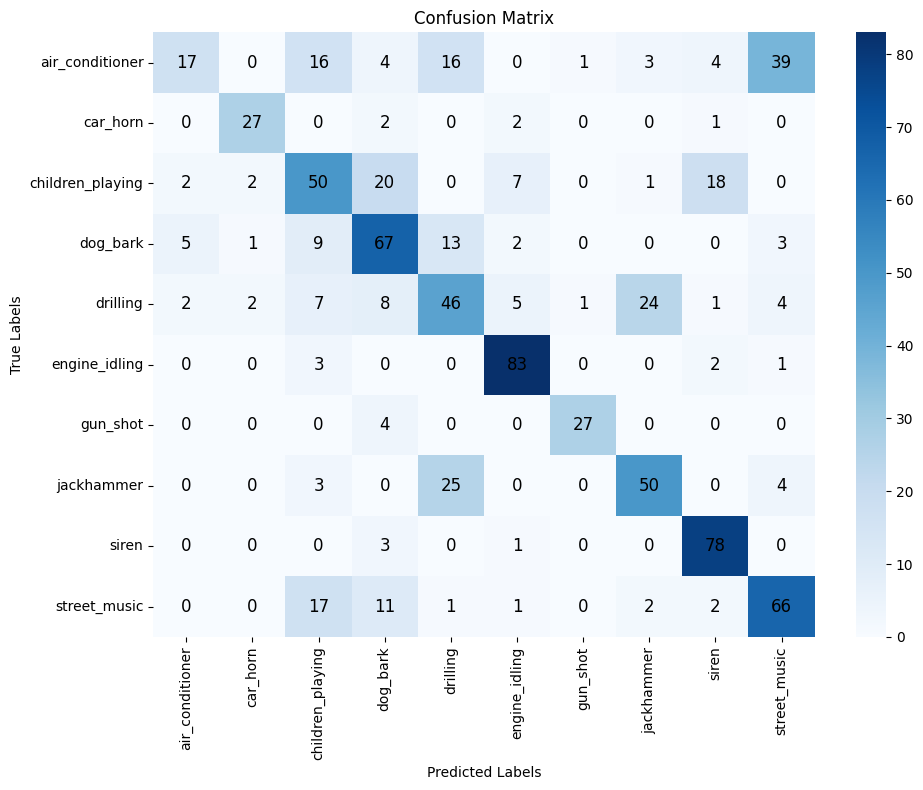


Classification Report
              precision    recall  f1-score   support

           0       0.65      0.17      0.27       100
           1       0.84      0.84      0.84        32
           2       0.48      0.50      0.49       100
           3       0.56      0.67      0.61       100
           4       0.46      0.46      0.46       100
           5       0.82      0.93      0.87        89
           6       0.93      0.87      0.90        31
           7       0.62      0.61      0.62        82
           8       0.74      0.95      0.83        82
           9       0.56      0.66      0.61       100

    accuracy                           0.63       816
   macro avg       0.67      0.67      0.65       816
weighted avg       0.63      0.63      0.61       816



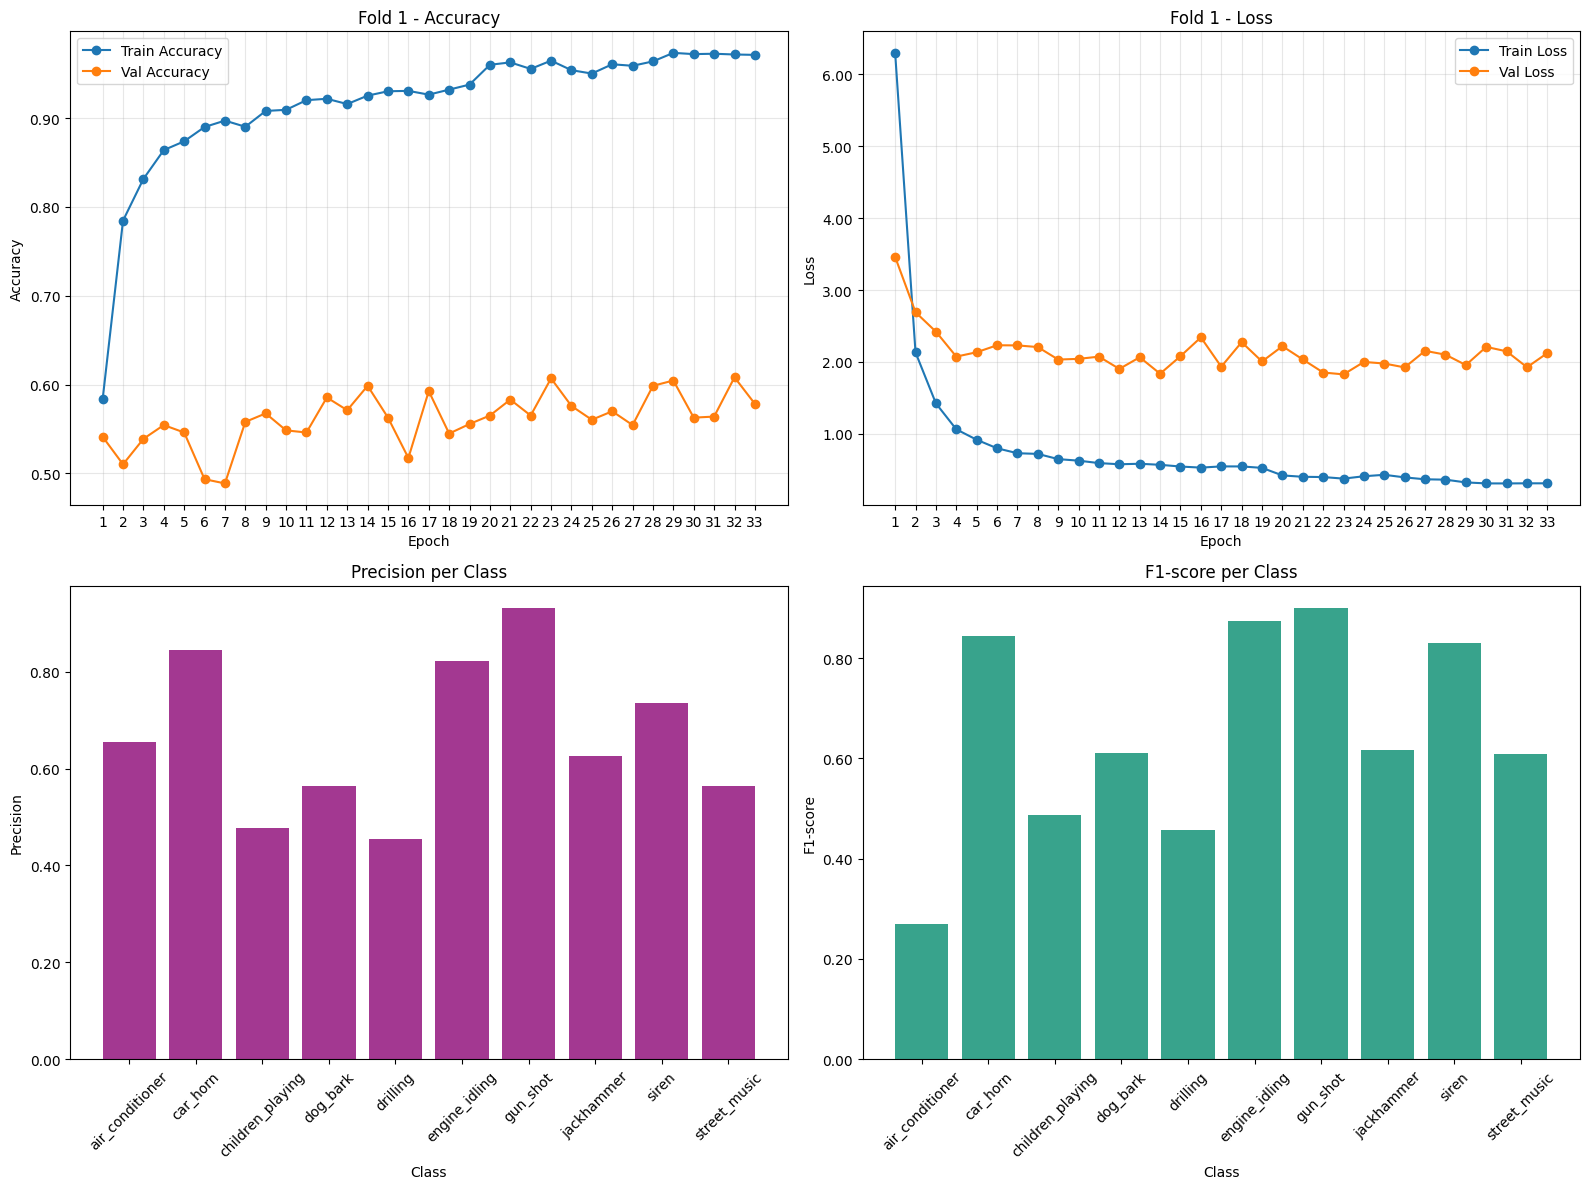

Epoch 1/100
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6245 - loss: 3.7622 - val_accuracy: 0.6048 - val_loss: 1.1843 - learning_rate: 0.0010
Epoch 2/100
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7159 - loss: 0.7790 - val_accuracy: 0.6334 - val_loss: 1.0854 - learning_rate: 0.0010
Epoch 3/100
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7360 - loss: 0.7238 - val_accuracy: 0.6404 - val_loss: 1.0483 - learning_rate: 0.0010
Epoch 4/100
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7468 - loss: 0.6924 - val_accuracy: 0.6490 - val_loss: 1.0268 - learning_rate: 0.0010
Epoch 5/100
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7523 - loss: 0.6750 - val_accuracy: 0.6658 - val_loss: 1.0105 - learning_rate: 0.0010
Epoch 6/100
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7559 - loss: 0.6618 - val_accuracy: 0.6560 - val_loss: 0.9785 - learning_rate: 0.0010
Epoch 7/100
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.

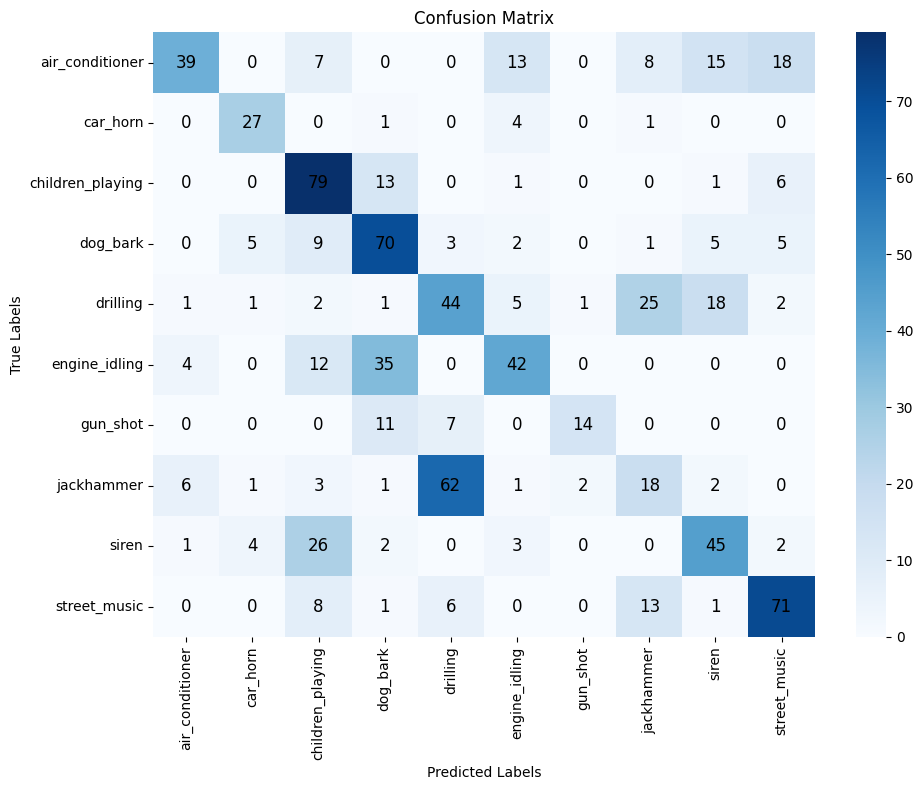


Classification Report
              precision    recall  f1-score   support

           0       0.76      0.39      0.52       100
           1       0.71      0.82      0.76        33
           2       0.54      0.79      0.64       100
           3       0.52      0.70      0.60       100
           4       0.36      0.44      0.40       100
           5       0.59      0.45      0.51        93
           6       0.82      0.44      0.57        32
           7       0.27      0.19      0.22        96
           8       0.52      0.54      0.53        83
           9       0.68      0.71      0.70       100

    accuracy                           0.54       837
   macro avg       0.58      0.55      0.54       837
weighted avg       0.55      0.54      0.53       837



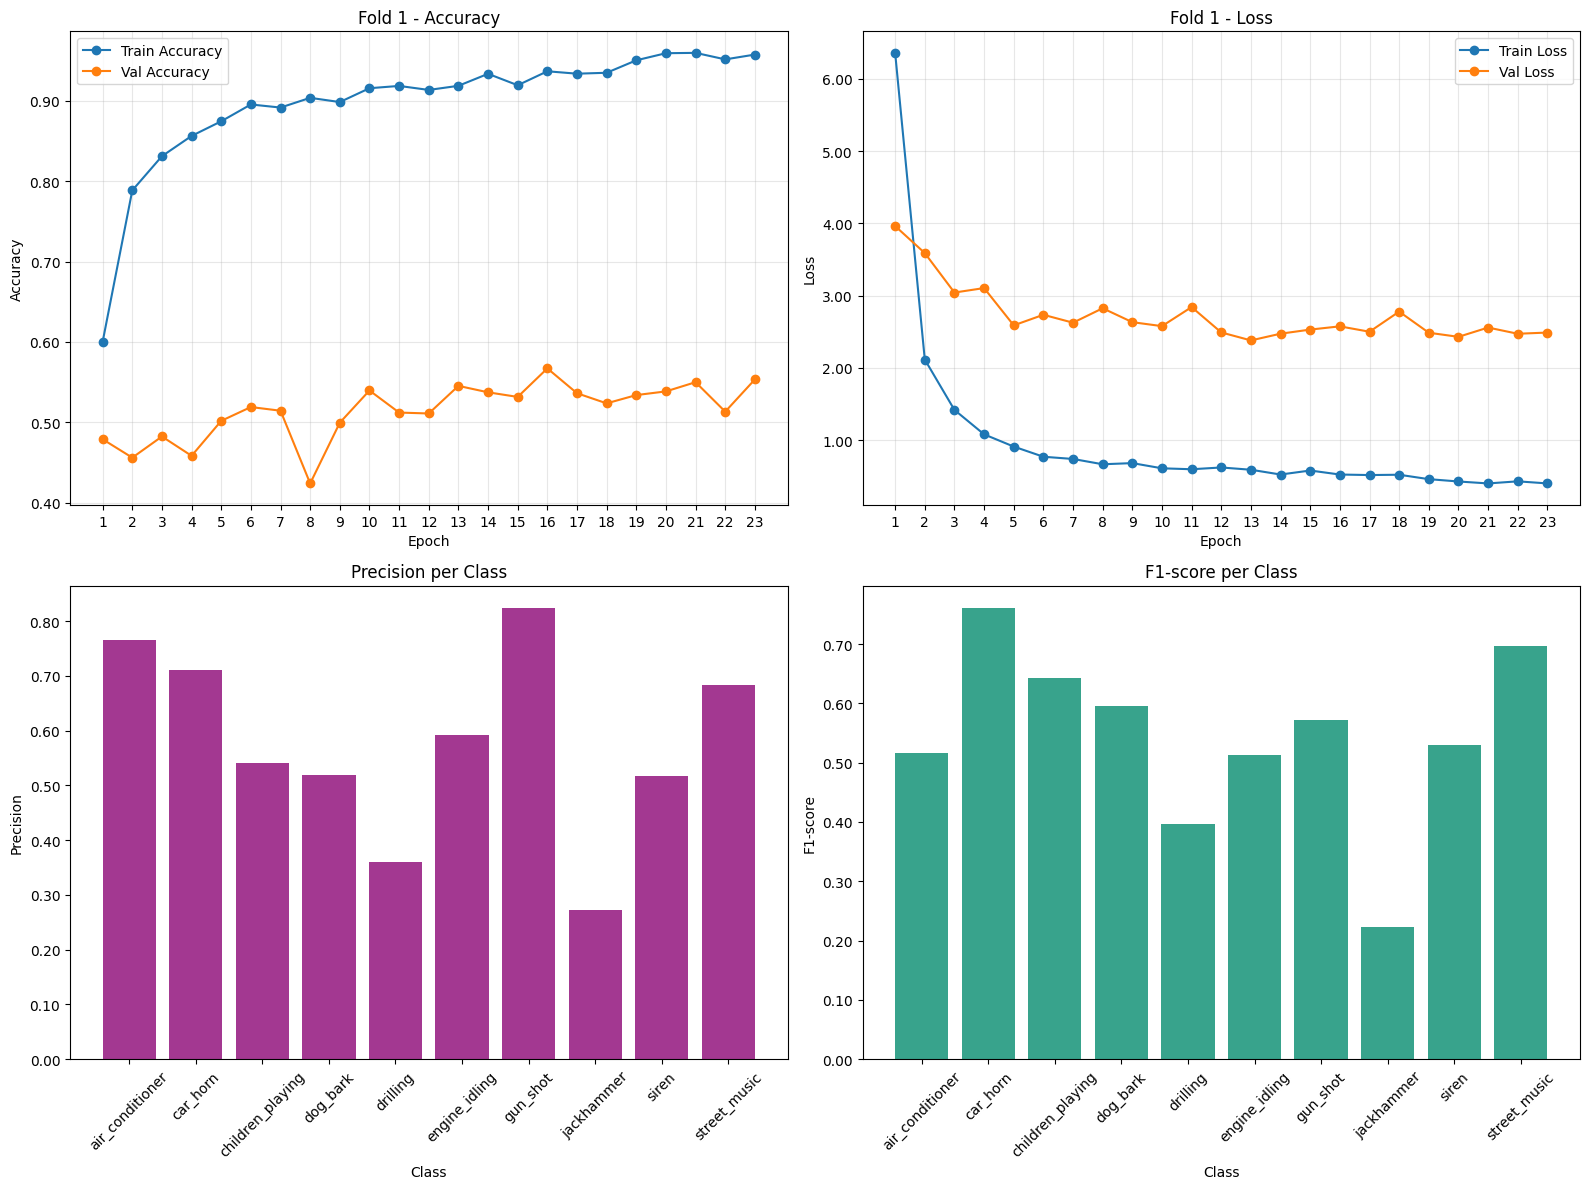

In [72]:
accuracies={}
fold_histories=[]
total_conf_matrix=np.zeros((10,10), dtype=int)
for i in range (10):
    input_dim_lte=60
    embedding_dim=8
    num_meta_classes=6

    fold_test_rnn=(i%10)+1
    test_rnn=df_mfcc[df_mfcc['fold']== fold_test_rnn]
    x_test_rnn=test_rnn.iloc[:,3:]
    y_test_rnn=test_rnn.iloc[:,1]

    fold_val_rnn=((i+1)%10)+1
    val_rnn=df_mfcc[df_mfcc['fold']== fold_val_rnn]
    x_val_rnn=val_rnn.iloc[:,3:]
    y_val_rnn=val_rnn.iloc[:,1]
    
    fold_train_lte = [f for f in range(1, 11) if f not in [fold_test_rnn, fold_val_rnn]]
    train_lte=df_mfcc[df_mfcc['fold'].isin(fold_train_lte)]
    x_train_lte=train_lte.iloc[:,3:]
    y_train_lte=train_lte.iloc[:,1]

    # get the meta-classes to train the embedding model
    y_train_lte=get_meta_classes(y_train_lte).astype('int64')

    y_train_lte_one_hot=tf.keras.utils.to_categorical(y_train_lte,num_classes=num_meta_classes)
    LTE_model= build_LTE_model(input_dim=input_dim_lte, embedding_dim=embedding_dim, num_meta_classes=num_meta_classes)
    LTE_model.fit(x_train_lte, y_train_lte_one_hot, epochs=100, batch_size=128, validation_split=0.2,callbacks=[
        EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ])

    embedding_model= tf.keras.models.Model(inputs=LTE_model.input, outputs=LTE_model.layers[1].output)

    #--------------------------------------------------------------Test dataset preparation------------------------------------------------------
    train_rnn=df_mfcc[~df_mfcc['fold'].isin([fold_train_lte, fold_test_rnn, fold_val_rnn])].reset_index(drop=True)
    df_files_names=pd.DataFrame(train_rnn['audio_name'],columns=['audio_name'])
    x_train_rnn=train_rnn.iloc[:,3:]
    y_train_rnn=train_rnn.iloc[:,1]

    #x_train_rnn = embedding_model.predict(x_train_rnn) #-----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
    #print(f"Shape of LTE features: {x_train_rnn.shape}") #-----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
    print(f"Shape of MFCC features: {x_train_rnn.shape}")
    
    # Reshape the dataset so that it becomes compatible with the RNN input 
    #x_train_rnn = pd.DataFrame(x_train_rnn, columns=[f"LTE_feature_{i}" for i in range(x_train_rnn.shape[1])]) #-----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
    
    # allow a direct link between x_train_rnn and df_files_names
    x_train_rnn=x_train_rnn.reset_index(drop=True)
    x_train_rnn['audio_name'] = df_files_names['audio_name'].values
    y_train_rnn=y_train_rnn.to_frame(name='classID')

    # allow a direct link between y_train_rnn and df_files_names
    y_train_rnn=y_train_rnn.reset_index(drop=True)
    y_train_rnn['audio_name'] = df_files_names['audio_name'].values
    print(f"Shape of training dataset features: {x_train_rnn.shape}")
    print(f"Shape of training dataset labels: {y_train_rnn.shape}")
    
    # change the shape of y_train_rnn so it becomes compatible with training
    y_train_rnn=y_train_rnn.groupby('audio_name', as_index=False)['classID'].first()
    y_train_rnn=y_train_rnn['classID']
    
    # change the shape of x_train_rnn to become compatible input for training
    feature_columns = [col for col in x_train_rnn.columns if col != 'audio_name']
    grouped = x_train_rnn.groupby('audio_name')
    
    reshaped_data=[]
    
    for name, group in grouped:
        features=group[feature_columns].values
        # 33 is the number of time_steps used to extract MFCC features from a 4-second audio
        if(features.shape[0]!=33):
            raise ValueError(f"The number of time_steps for audio {name} is not as expected; expected 33 time_steps per audio but received {features.shape[0]}")
        
        reshaped_data.append(features)
    
    x_train_rnn=np.stack(reshaped_data, axis=0)
    
    print(f"Shape of training dataset features after reshaping: {x_train_rnn.shape}")
    
    y_train_rnn_one_hot=tf.keras.utils.to_categorical(y_train_rnn,num_classes=10)
    print(f"Shape of training dataset labels after reshaping {y_train_rnn_one_hot.shape}")

    #--------------------------------------------------------------Test dataset preparation------------------------------------------------------

    df_files_names=pd.DataFrame(test_rnn['audio_name'],columns=['audio_name']).reset_index(drop=True)

    #x_test_rnn = embedding_model.predict(x_test_rnn) #-----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
    #print(f"Shape of LTE features: {x_test_rnn.shape}")
    print(f"Shape of MFCC features : {x_test_rnn.shape}")
    
    #x_test_rnn = pd.DataFrame(x_test_rnn, columns=[f"LTE_feature_{i}" for i in range(x_test_rnn.shape[1])]) #-----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
    x_test_rnn=x_test_rnn.reset_index(drop=True)
    x_test_rnn['audio_name'] = df_files_names['audio_name'].values
    
    y_test_rnn=y_test_rnn.to_frame(name='classID')

    # allow a direct link between y_test_rnn and df_files_names
    y_test_rnn=y_test_rnn.reset_index(drop=True)
    y_test_rnn['audio_name'] = df_files_names['audio_name'].values
    print(f"Shape of test dataset features: {x_test_rnn.shape}")
    print(f"Shape of test dataset labels: {y_test_rnn.shape}")
    
    # change the shape of y_test_rnn so it becomes compatible with training
    y_test_rnn=y_test_rnn.groupby('audio_name', as_index=False)['classID'].first()
    y_test_rnn=y_test_rnn['classID']
    
    # change the shape of x_test_rnn to become compatible input for inference
    feature_columns = [col for col in x_test_rnn.columns if col != 'audio_name']
    grouped = x_test_rnn.groupby('audio_name')
    
    reshaped_data=[]
    
    for name, group in grouped:
        features=group[feature_columns].values
        # 33 time_steps expected from MFCC extraction on 4-second audio
        if(features.shape[0]!=33):
            raise ValueError(f"The number of time_steps for audio {name} is not as expected; expected 33 but received {features.shape[0]}")
        
        reshaped_data.append(features)
    
    x_test_rnn=np.stack(reshaped_data, axis=0)
    
    print(f"Shape of test dataset features after reshaping: {x_test_rnn.shape}")
    
    y_test_rnn_one_hot=tf.keras.utils.to_categorical(y_test_rnn,num_classes=10)
    print(f"Shape of test dataset labels after reshaping {y_test_rnn_one_hot.shape}")

    #--------------------------------------------------------------Validation dataset preparation------------------------------------------------------
    df_files_names=pd.DataFrame(val_rnn['audio_name'],columns=['audio_name']).reset_index(drop=True)

    #x_val_rnn = embedding_model.predict(x_val_rnn) #-----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
    #print(f"Shape of LTE features: {x_val_rnn.shape}")
    print(f"Shape of MFCC features : {x_val_rnn.shape}")

    #x_val_rnn = pd.DataFrame(x_val_rnn, columns=[f"LTE_feature_{i}" for i in range(x_val_rnn.shape[1])]) #-----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
    x_val_rnn=x_val_rnn.reset_index(drop=True)
    x_val_rnn['audio_name'] = df_files_names['audio_name'].values

    y_val_rnn=y_val_rnn.to_frame(name='classID')

    # allow a direct link between y_val_rnn and df_files_names
    y_val_rnn=y_val_rnn.reset_index(drop=True)
    y_val_rnn['audio_name'] = df_files_names['audio_name'].values
    print(f"Shape of validation dataset features: {x_val_rnn.shape}")
    print(f"Shape of validation dataset labels: {y_val_rnn.shape}")

    # change y_val_rnn shape to be compatible with training
    y_val_rnn=y_val_rnn.groupby('audio_name', as_index=False)['classID'].first()
    y_val_rnn=y_val_rnn['classID']

    # change x_val_rnn shape for RNN input
    feature_columns = [col for col in x_val_rnn.columns if col != 'audio_name']
    grouped = x_val_rnn.groupby('audio_name')

    reshaped_data=[]

    for name, group in grouped:
        features=group[feature_columns].values
        # 33 MFCC time_steps expected
        if(features.shape[0]!=33):
            raise ValueError(f"Number of time_steps for audio {name} incorrect; expected 33 but received {features.shape[0]}")

        reshaped_data.append(features)

    x_val_rnn=np.stack(reshaped_data, axis=0)

    print(f"Shape of validation dataset features after reshaping: {x_val_rnn.shape}")

    y_val_rnn_one_hot=tf.keras.utils.to_categorical(y_val_rnn,num_classes=10)
    print(f"Shape of validation dataset labels after reshaping {y_val_rnn_one_hot.shape}")

    #--------------------------------------------------------------------------------------------------------------------

    input_dim = 60         
    hidden_dim = 256      
    output_dim = 10         
    num_layers = 2          
    dropout_rate = 0        
    batch_size = 64
    max_epochs = 50

    rnn_model = create_model(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        num_layers=num_layers,
        dropout_rate=dropout_rate
    )

    history = rnn_model.fit(
        x_train_rnn,
        y_train_rnn_one_hot,
        batch_size=batch_size,
        epochs=max_epochs,
        validation_data=(x_val_rnn, y_val_rnn_one_hot),
        callbacks=[
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.75,
                patience=5,
                min_lr=1e-6
            )
        ]
    )

    fold_histories.append(history)

    #--------------------------------------------------------------------------------------------------------------------

    y_pred=rnn_model.predict(x_test_rnn)

    y_pred_labels=np.argmax(y_pred, axis=1)
    y_test_labels=np.argmax(y_test_rnn_one_hot,axis=1)
    
    conf_matrix= confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)
    total_conf_matrix=np.add(total_conf_matrix,conf_matrix)

    # Total correct predictions are the diagonal elements
    correct_predictions = np.trace(conf_matrix)
    total_predictions = np.sum(conf_matrix)
    accuracy = correct_predictions / total_predictions
    print(f"Accuracy: {accuracy:.4f}")
    accuracies[f'Fold{i+1}']=accuracy
    
    conf_matrix = confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)

    original_labels = {
        0: 'air_conditioner',
        1: 'car_horn',
        2: 'children_playing',
        3: 'dog_bark',
        4: 'drilling',
        5: 'engine_idling',
        6: 'gun_shot',
        7: 'jackhammer',
        8: 'siren',
        9: 'street_music'
    }

    class_names = [original_labels[i] for i in range(len(conf_matrix))]
    
    plt.figure(figsize=(10, 8))

    ax = sns.heatmap(
        conf_matrix,
        cmap='Blues',
        cbar=True,
        xticklabels=class_names,
        yticklabels=class_names
    )

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            value = conf_matrix[i, j]
            ax.text(
                j + 0.5,
                i + 0.5,
                str(value),
                ha='center',
                va='center',
                fontsize=12,
            )

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    print("\nClassification Report")
    print(classification_report(y_true=y_test_labels, y_pred=y_pred_labels))
    
    plot_fold_results(history, y_test_labels, y_pred_labels, class_names, fold_number=1)


In [73]:
conf_matrix = confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)

original_labels = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music'
}

class_names = [original_labels[i] for i in range(len(conf_matrix))]

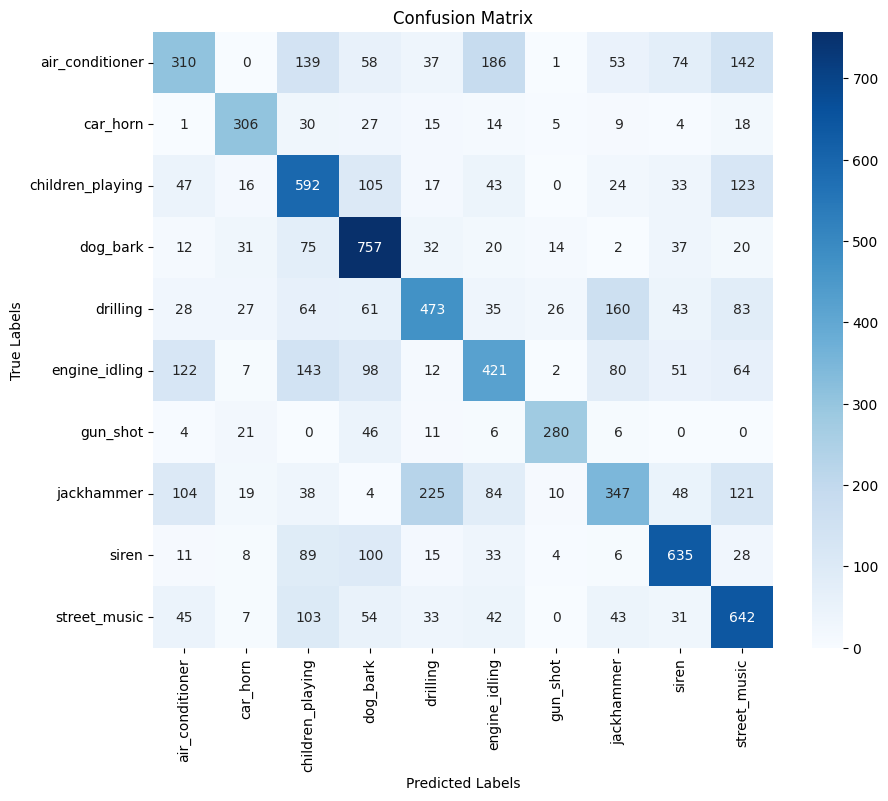

In [74]:
# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(total_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [75]:
def visualize_metrics_rnn(results_df, mean_accuracy, std_accuracy, fold_histories):

    # Fold-wise Accuracy
    plt.figure(figsize=(10, 6))

    x = results_df['fold'].astype(int)
    y = results_df['accuracy'].astype(float)

    plt.plot(x, y, marker='o', label="Fold Accuracy")
    plt.axhline(y=mean_accuracy, color='r', linestyle='--',
                label=f"Mean Accuracy ({mean_accuracy:.4f})")

    plt.fill_between(
        x,
        mean_accuracy - std_accuracy,
        mean_accuracy + std_accuracy,
        color='r', alpha=0.2,
        label=f"± Std Dev ({std_accuracy:.4f})"
    )

    plt.title("Fold-wise Accuracy")
    plt.xlabel("Fold")
    plt.ylabel("Accuracy")
    plt.xticks(x)
    plt.legend()
    plt.grid(True)
    plt.savefig("./results_images/fold_accuracy_rnn.png")
    plt.show()

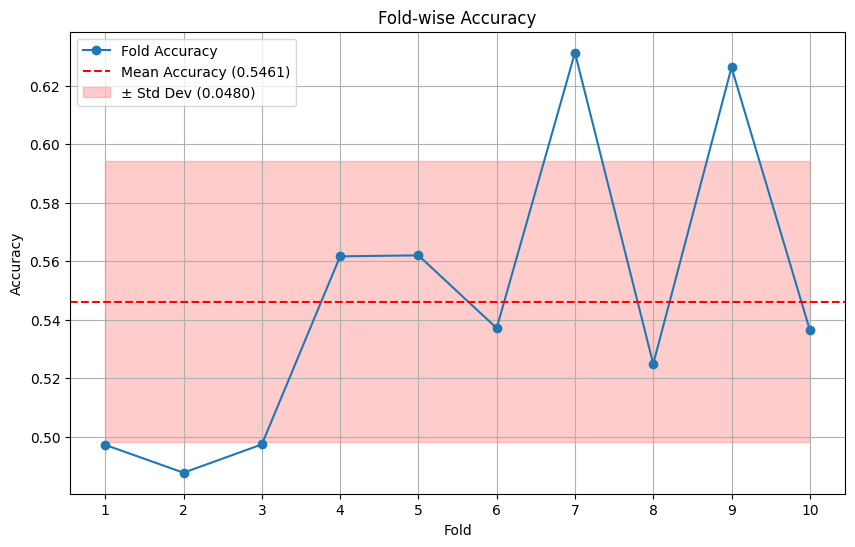

In [76]:
results_df = pd.DataFrame({
    "fold": list(accuracies.keys()),
    "accuracy": list(accuracies.values())
})

results_df['fold'] = results_df['fold'].str.extract(r'(\d+)').astype(int)

mean_accuracy = np.mean(list(accuracies.values()))
std_accuracy = np.std(list(accuracies.values()))

visualize_metrics_rnn(
    results_df=results_df,
    mean_accuracy=mean_accuracy,
    std_accuracy=std_accuracy,
    fold_histories=fold_histories,
)

### Results Analysis <a name = "rnn_ar"></a>
[[back to Model Testing - RNN]](#rnn_tm)

After training the model using 10-fold cross-validation, the results showed an average accuracy of **54.6%**, with significant variability across folds (±4.8%). Individual fold scores ranged from approximately **49% to 63%**. This spread clearly indicates that the model struggles to generalize consistently on the UrbanSound8K dataset, which is known for its high acoustic variability and background noise. This behaviour is further confirmed by the learning curves, which reveal evident overfitting.

By examining the confusion matrix, the most difficult classes for the model to classify were: **air_conditioner** (which resembles generic urban background noise), **engine_idling** (similar to machinery noise), **drilling** and **jackhammer** (both involving similar types of mechanical sounds).

This outcome aligns with what is commonly reported in the literature for simple RNN architectures applied to acoustic data: GRU or LSTM models without attention, normalization, or data augmentation typically achieve performances between **48% and 60%** on UrbanSound8K.

Nevertheless, the obtained results made it clear that structural improvements were required to achieve more competitive performance, namely:
- the introduction of **Layer Normalization** to stabilize training;
- the use of **internal dropout** within the GRU layers;
- the integration of a **Self-Attention mechanism**, enabling the model to focus on the most relevant audio frames;
- the application of **data augmentation techniques (SpecAugment)** to increase robustness;
- the adjustment of **L2 regularization** to less restrictive values.

These enhancements were incorporated into the improved versions of the RNN model developed subsequently, allowing a clearer evaluation of the impact of each modification on the network’s generalization capability.

---

### Improvements Implemented - RNN <a name = "rnn_mi"></a>
[[back to RNN]](#rnn)

- [Improvement 1](#rnn_mi1)  
- [Improvement 2](#rnn_mi2)  
- [Results Analysis](#rnn_ar2)

#### Improvement 1 <a name = "rnn_mi1"></a>
[[back to Improvements Implemented - RNN]](#rnn_mi)

##### Data Augmentation (SpecAugment)

One of the main limitations of RNN models applied to audio data is their sensitivity to temporal and spectral variability across samples.

To increase the robustness of the model and improve its generalization capability, we implemented a form of **data augmentation inspired by the SpecAugment method**, widely used in speech recognition systems.

The technique operates directly on MFCC matrices and consists of two types of masks:

- **``Time Masking``** — removes consecutive intervals of time-steps, simulating interruptions or temporal variations in the signal.

- **``Frequency Masking``** — hides frequency bands, mimicking noisy conditions or spectral variations.

Both masks are applied probabilistically to each sample during training:

> This forces the model to learn more robust representations, reducing excessive reliance on specific patterns and increasing its generalization capacity.

Previous studies have shown that this approach **reduces overfitting** and **slightly improves performance** on validation, without significantly increasing training time.


Selected audio: 103074-7-4-6.wav
Shape MFCC raw: (33, 63)
Shape MFCC matrix: (33, 60)


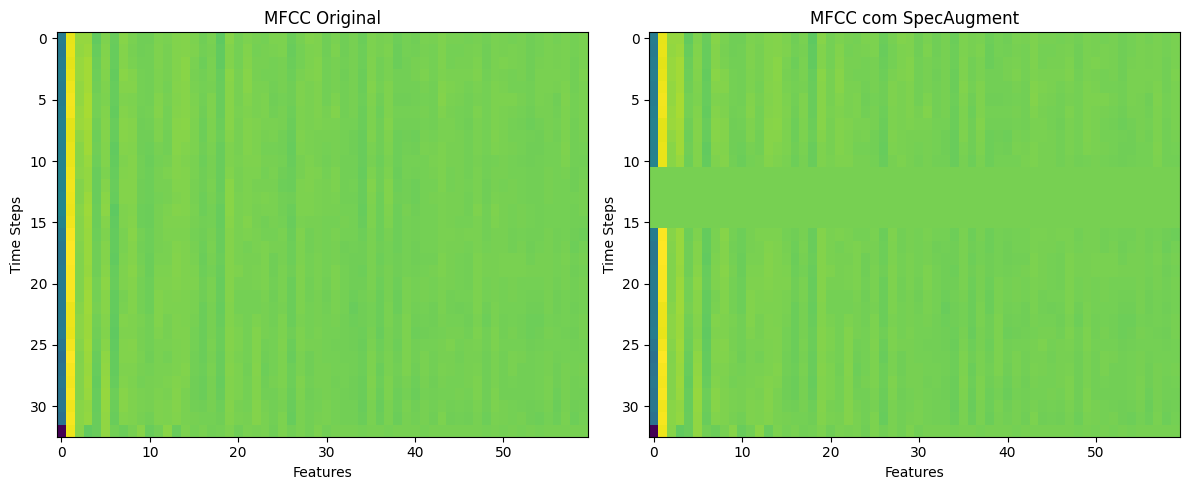

In [77]:
audio_name = df_mfcc['audio_name'].iloc[1000]
df_audio = df_mfcc[df_mfcc['audio_name'] == audio_name]

print("Selected audio:", audio_name)
print("Shape MFCC raw:", df_audio.shape)

# ----------------------------
# Extract only the MFCC columns (60 coefficients)
# ----------------------------
feature_cols = [col for col in df_audio.columns if col.startswith("mfcc_")]
mfcc_matrix = df_audio[feature_cols].values   # shape (33, 60)

print("Shape MFCC matrix:", mfcc_matrix.shape)

# ----------------------------
# SpecAugment functions
# ----------------------------
def time_mask(spec, max_mask_size=5):
    spec = spec.copy()
    T = spec.shape[0]
    mask_size = np.random.randint(1, max_mask_size+1)
    start = np.random.randint(0, T - mask_size)
    spec[start:start+mask_size, :] = 0
    return spec

def freq_mask(spec, max_mask_size=8):
    spec = spec.copy()
    F = spec.shape[1]
    mask_size = np.random.randint(1, max_mask_size+1)
    start = np.random.randint(0, F - mask_size)
    spec[:, start:start+mask_size] = 0
    return spec

def spec_augment_numpy(spec, p=0.7):
    out = spec.copy()
    if np.random.rand() < p:
        out = time_mask(out)
    if np.random.rand() < p:
        out = freq_mask(out)
    return out

mfcc_aug = spec_augment_numpy(mfcc_matrix)

# ----------------------------
# Visualization
# ----------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(mfcc_matrix, aspect='auto')
plt.title("MFCC Original")
plt.xlabel("Features")
plt.ylabel("Time Steps")

plt.subplot(1,2,2)
plt.imshow(mfcc_aug, aspect='auto')
plt.title("MFCC com SpecAugment")
plt.xlabel("Features")
plt.ylabel("Time Steps")

plt.tight_layout()
plt.show()


In [78]:
train_rnn = df_mfcc[~df_mfcc['fold'].isin([1, 2, 3])].reset_index(drop=True)
df_files_names = pd.DataFrame(train_rnn['audio_name'], columns=['audio_name'])
x_train_rnn = train_rnn.iloc[:,3:]
y_train_rnn = train_rnn.iloc[:,1]

# x_train_rnn = embedding_model.predict(x_train_rnn)  # -----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------

# print(f"Shape of LTE features: {x_train_rnn.shape}")  # -----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
print(f"Shape of MFCC features: {x_train_rnn.shape}")

# x_train_rnn = pd.DataFrame(x_train_rnn, columns=[f"LTE_feature_{i}" for i in range(x_train_rnn.shape[1])])  # -----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
# allow a direct link between x_train_rnn and df_files_names
x_train_rnn = x_train_rnn.reset_index(drop=True)
x_train_rnn['audio_name'] = df_files_names['audio_name'].values
y_train_rnn = y_train_rnn.to_frame(name='classID')
# allow a direct link between y_train_rnn and df_files_names
y_train_rnn = y_train_rnn.reset_index(drop=True)
y_train_rnn['audio_name'] = df_files_names['audio_name'].values
print(f"Shape of training dataset features: {x_train_rnn.shape}")
print(f"Shape of training dataset labels: {y_train_rnn.shape}")

# change the shape of y_train_rnn so that it is compatible with training
y_train_rnn = y_train_rnn.groupby('audio_name', as_index=False)['classID'].first()
y_train_rnn = y_train_rnn['classID']

# change the shape of x_train_rnn so that it is an input compatible with training
feature_columns = [col for col in x_train_rnn.columns if col != 'audio_name']
grouped = x_train_rnn.groupby('audio_name')

reshaped_data = []

for name, group in grouped:
    features = group[feature_columns].values
    # 33 is the number of time_steps used to extract MFCC features from a 4 sec audio
    if(features.shape[0] != 33):
        raise ValueError(f"The number of time_steps of audio {name} is not equal to the expected value; expected 33 time_steps per audio but received {features.shape[0]}")
    
    reshaped_data.append(features)

x_train_rnn = np.stack(reshaped_data, axis=0)

print(f"Shape of training features after reshaping: {x_train_rnn.shape}")
print("Applying data augmentation to training...")
x_train_rnn_aug = []
for spec in x_train_rnn:
    x_train_rnn_aug.append(spec_augment_numpy(spec))
x_train_rnn = np.stack(x_train_rnn_aug, axis=0)
print("Data augmentation completed!")

y_train_rnn_one_hot = tf.keras.utils.to_categorical(y_train_rnn, num_classes=10)
print(f"Shape of training labels after reshaping: {y_train_rnn_one_hot.shape}")


Shape of MFCC features: (199518, 60)
Shape of training dataset features: (199518, 61)
Shape of training dataset labels: (199518, 2)
Shape of training features after reshaping: (6046, 33, 60)
Applying data augmentation to training...
Data augmentation completed!
Shape of training labels after reshaping: (6046, 10)


In [79]:
test_rnn = df_mfcc[df_mfcc['fold'] == 2]
df_files_names = pd.DataFrame(test_rnn['audio_name'], columns=['audio_name']).reset_index(drop=True)
x_test_rnn = test_rnn.iloc[:,3:]
y_test_rnn = test_rnn.iloc[:,1]

# x_test_rnn = embedding_model.predict(x_test_rnn)  # -----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
# print(f"Shape of LTE features: {x_test_rnn.shape}")
print(f"Shape of MFCC features: {x_test_rnn.shape}")

# x_test_rnn = pd.DataFrame(x_test_rnn, columns=[f"LTE_feature_{i}" for i in range(x_test_rnn.shape[1])])  # -----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
x_test_rnn = x_test_rnn.reset_index(drop=True)
x_test_rnn['audio_name'] = df_files_names['audio_name'].values

y_test_rnn = y_test_rnn.to_frame(name='classID')
# allow a direct connection between y_test_rnn and df_files_names
y_test_rnn = y_test_rnn.reset_index(drop=True)
y_test_rnn['audio_name'] = df_files_names['audio_name'].values

print(f"Shape of test dataset features: {x_test_rnn.shape}")
print(f"Shape of test dataset labels: {y_test_rnn.shape}")

# change the shape of y_test_rnn so that it is compatible with training
y_test_rnn = y_test_rnn.groupby('audio_name', as_index=False)['classID'].first()
y_test_rnn = y_test_rnn['classID']

# change the shape of x_test_rnn so that it is an input compatible with training
feature_columns = [col for col in x_test_rnn.columns if col != 'audio_name']
grouped = x_test_rnn.groupby('audio_name')

reshaped_data = []

for name, group in grouped:
    features = group[feature_columns].values
    # 33 is the number of time_steps used to extract MFCC features from a 4-sec audio
    if(features.shape[0] != 33):
        raise ValueError(f"The number of time_steps in audio {name} is not equal to the expected value; expected 33 time_steps per audio but received {features.shape[0]}")
    
    reshaped_data.append(features)

x_test_rnn = np.stack(reshaped_data, axis=0)

print(f"Shape of test dataset features after reshaping: {x_test_rnn.shape}")

y_test_rnn_one_hot = tf.keras.utils.to_categorical(y_test_rnn, num_classes=10)
print(f"Shape of test dataset labels after reshaping: {y_test_rnn_one_hot.shape}")


Shape of MFCC features: (29304, 60)
Shape of test dataset features: (29304, 61)
Shape of test dataset labels: (29304, 2)
Shape of test dataset features after reshaping: (888, 33, 60)
Shape of test dataset labels after reshaping: (888, 10)


In [80]:
val_rnn = df_mfcc[df_mfcc['fold'] == 3].reset_index(drop=True)

x_val_rnn = val_rnn.iloc[:,3:]
y_val_rnn = val_rnn.iloc[:,1]

# x_val_rnn = embedding_model.predict(x_val_rnn)  # -----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
# print(f"Shape of LTE features: {x_val_rnn.shape}")
print(f"Shape of MFCC features: {x_val_rnn.shape}")

# x_val_rnn = pd.DataFrame(x_val_rnn, columns=[f"LTE_feature_{i}" for i in range(x_val_rnn.shape[1])])  # -----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
x_val_rnn = x_val_rnn.reset_index(drop=True)
x_val_rnn['audio_name'] = val_rnn['audio_name'].values

y_val_rnn = y_val_rnn.to_frame(name='classID')
# allow a direct link between y_val_rnn and df_files_names
y_val_rnn = y_val_rnn.reset_index(drop=True)
y_val_rnn['audio_name'] = val_rnn['audio_name'].values

print(f"Shape of validation dataset features: {x_val_rnn.shape}")
print(f"Shape of validation dataset labels: {y_val_rnn.shape}")

# change the shape of y_val_rnn so that it is compatible with training
y_val_rnn = y_val_rnn.groupby('audio_name', as_index=False)['classID'].first()
y_val_rnn = y_val_rnn['classID']

# change the shape of x_val_rnn so that it is an input compatible with training
feature_columns = [col for col in x_val_rnn.columns if col != 'audio_name']
grouped = x_val_rnn.groupby('audio_name')

reshaped_data = []

for name, group in grouped:
    features = group[feature_columns].values
    # 33 is the number of time_steps used to extract MFCC features from a 4-sec audio
    if(features.shape[0] != 33):
        raise ValueError(f"The number of time_steps in audio {name} is not equal to the expected value; expected 33 time_steps per audio but received {features.shape[0]}")
    
    reshaped_data.append(features)

x_val_rnn = np.stack(reshaped_data, axis=0)

print(f"Shape of validation features after reshaping: {x_val_rnn.shape}")

y_val_rnn_one_hot = tf.keras.utils.to_categorical(y_val_rnn, num_classes=10)
print(f"Shape of validation labels after reshaping: {y_val_rnn_one_hot.shape}")


Shape of MFCC features: (30525, 60)
Shape of validation dataset features: (30525, 61)
Shape of validation dataset labels: (30525, 2)
Shape of validation features after reshaping: (925, 33, 60)
Shape of validation labels after reshaping: (925, 10)


##### Improved RNN Architecture

In addition to data augmentation, the **model itself was substantially improved**. The original architecture was replaced with a more robust and expressive version, composed of the following components:

1. **Stacked Bidirectional GRUs**

   We used **two Bidirectional GRU layers**, enabling the model to capture temporal dependencies in both directions. We added **dropout**, **recurrent dropout**, and **L2 regularization**, increasing stability and the ability to model complex patterns.

2. **Layer Normalization**

   Each GRU layer is followed by **Layer Normalization**, which is more suitable than BatchNorm for recurrent networks. This stabilizes gradient flow, speeds up training, and reduces the need for additional regularization.

3. **Self-Attention**

   A **self-attention** module was included, allowing the model to focus on the most relevant time-steps and capture long-range dependencies across the sequence, improving temporal representation.

4. **Global Average Pooling**

   We replaced traditional pooling strategies with **GlobalAveragePooling1D**, which reduces dimensionality and aggregates information across the entire sequence without temporal bias.

5. **Final Dropout + Linear Classifier**

   A final dropout layer was applied to reinforce regularization, followed by a **Dense output layer without softmax** (softmax applied with `from_logits=True`), ensuring greater numerical stability.

In [81]:
def create_improved_rnn(
    input_dim,
    hidden_dim,
    output_dim,
    num_layers=2,
    dropout_rate=0.3,
    l2_reg=1e-4
):
    tf.keras.backend.clear_session()

    inputs = Input(shape=(None, input_dim))
    x = inputs

    # -----------------------------------------------------------
    # STACKED GRU + LAYERNORM
    # -----------------------------------------------------------
    for i in range(num_layers):
        x = Bidirectional(
            GRU(
                hidden_dim,
                return_sequences=True,
                dropout=0.2,
                recurrent_dropout=0.2,
                kernel_regularizer=l2(l2_reg),
            )
        )(x)

        x = LayerNormalization()(x)

    # -----------------------------------------------------------
    # SELF-ATTENTION
    # -----------------------------------------------------------
    attention_output = Attention()([x, x])  # Both query and value = x

    # Reduction using a Keras layer (DO NOT use tf.reduce_mean directly)
    x = GlobalAveragePooling1D()(attention_output)

    # -----------------------------------------------------------
    # FINAL DROPOUT
    # -----------------------------------------------------------
    x = Dropout(dropout_rate)(x)

    # -----------------------------------------------------------
    # OUTPUT (logits)
    # -----------------------------------------------------------
    outputs = Dense(output_dim, kernel_regularizer=l2(l2_reg))(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    return model

In [82]:
model = create_improved_rnn(
    input_dim=60,
    hidden_dim=256,
    output_dim=10,
    num_layers=2,
    dropout_rate=0.3
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 60)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, None, 512) │    488,448 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 512) │      1,024 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, None, 512) │  1,182,720 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 512) │      1,024 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, None, 512) │          0 │ layer_normalizat… │
│ (Attention)         │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │      5,130 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,678,346 (6.40 MB)

 Trainable params: 1,678,346 (6.40 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
input_dim = 60         
hidden_dim = 256      
output_dim = 10         
num_layers = 2          
dropout_rate = 0.3      
batch_size = 64
max_epochs = 50

# Create the new improved model.
rnn_model = create_improved_rnn(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout_rate=dropout_rate
)

# Training (same as your original code)
history = rnn_model.fit(
    x_train_rnn,
    y_train_rnn_one_hot,
    batch_size=batch_size,
    epochs=max_epochs,
    validation_data=(x_val_rnn, y_val_rnn_one_hot),
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.75,
            patience=5,
            min_lr=1e-6
        )
    ]
)


Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.3430 - loss: 2.2351 - val_accuracy: 0.4476 - val_loss: 1.8059 - learning_rate: 0.0010
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.5117 - loss: 1.5781 - val_accuracy: 0.5319 - val_loss: 1.7816 - learning_rate: 0.0010
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.5949 - loss: 1.3509 - val_accuracy: 0.5178 - val_loss: 1.8292 - learning_rate: 0.0010
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 95s 995ms/step - accuracy: 0.6513 - loss: 1.1874 - val_accuracy: 0.4778 - val_loss: 1.9914 - learning_rate: 0.0010
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6938 - loss: 1.0483 - val_accuracy: 0.5211 - val_loss: 1.9970 - learning_rate: 0.0010
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.7203 - loss: 0.9599 - val_accuracy: 0.4897 - val_loss: 1.9969 - learning_rate: 0.0010
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.7413 - loss: 0.8743 - val_accur

In [84]:
y_pred = rnn_model.predict(x_test_rnn)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test_rnn_one_hot, axis=1)

from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)

original_labels = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music'
}

class_names = [original_labels[i] for i in range(len(conf_matrix))]

28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 446ms/step


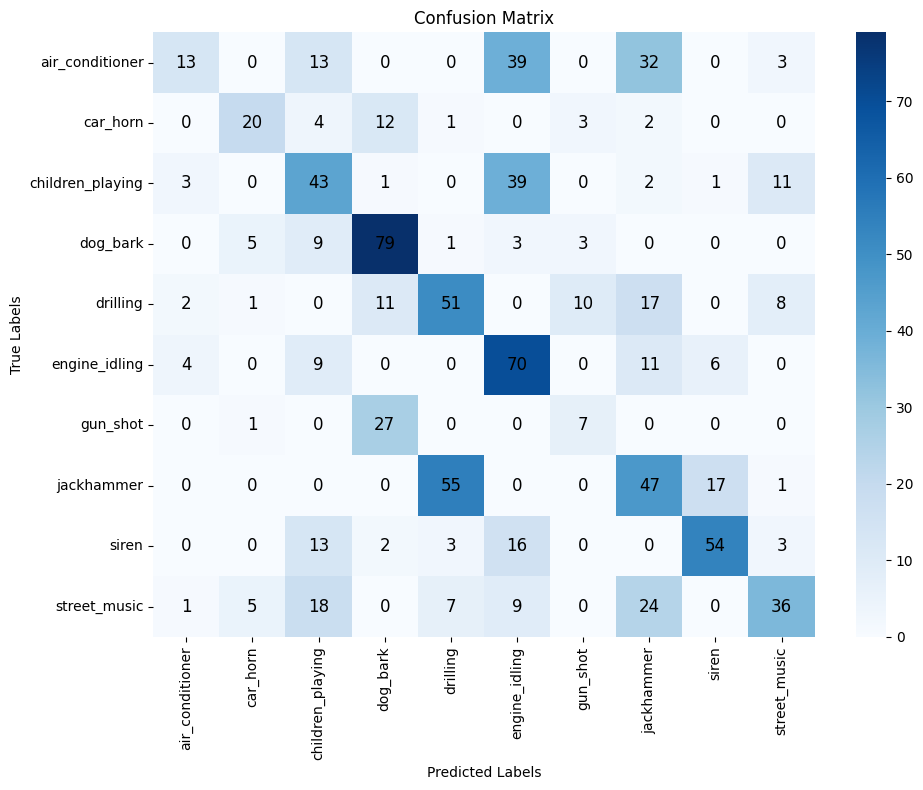

In [85]:
plt.figure(figsize=(10, 8))

ax = sns.heatmap(
    conf_matrix,
    cmap='Blues',
    cbar=True,
    xticklabels=class_names,
    yticklabels=class_names
)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        value = conf_matrix[i, j]
        ax.text(
            j + 0.5,
            i + 0.5,
            str(value),
            ha='center',
            va='center',
            fontsize=12,
        )

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [23]:
print("\nClassification Report")
print(classification_report(y_true=y_test_labels, y_pred=y_pred_labels))


Classification Report
              precision    recall  f1-score   support

           0       0.52      0.22      0.31       100
           1       1.00      0.10      0.17        42
           2       0.40      0.48      0.43       100
           3       0.62      0.69      0.65       100
           4       0.70      0.53      0.60       100
           5       0.43      0.70      0.54       100
           6       0.30      0.49      0.37        35
           7       0.50      0.18      0.27       120
           8       0.43      0.71      0.53        91
           9       0.55      0.66      0.60       100

    accuracy                           0.49       888
   macro avg       0.55      0.48      0.45       888
weighted avg       0.53      0.49      0.47       888



In [ ]:
def plot_fold_results(history, y_test, y_pred, class_names, fold_number=1):

    # ---------- Convert one-hot to labels ----------
    if len(y_test.shape) > 1:
        y_test_labels = y_test.argmax(axis=1)
    else:
        y_test_labels = y_test

    if len(y_pred.shape) > 1:
        y_pred_labels = y_pred.argmax(axis=1)
    else:
        y_pred_labels = y_pred

    # ---------- Classification report ----------
    report = classification_report(
        y_test_labels,
        y_pred_labels,
        target_names=class_names,
        output_dict=True
    )

    precision_per_class = [report[name]['precision'] for name in class_names]
    f1_per_class        = [report[name]['f1-score'] for name in class_names]

    # ---------- Epochs as integers ----------
    n_epochs = len(history.history['accuracy'])
    epochs = list(range(1, n_epochs + 1))

    # ---------- Create figure ----------
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    # ------------------------------------------------
    # 1) Accuracy plot
    # ------------------------------------------------
    axs[0,0].plot(epochs, history.history['accuracy'], marker='o', label='Train Accuracy')
    axs[0,0].plot(epochs, history.history['val_accuracy'], marker='o', label='Val Accuracy')
    axs[0,0].set_title(f"Fold {fold_number} - Accuracy")
    axs[0,0].set_xlabel("Epoch")
    axs[0,0].set_ylabel("Accuracy")
    axs[0,0].set_xticks(epochs)
    axs[0,0].grid(alpha=0.3)
    axs[0,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[0,0].legend()

    # ------------------------------------------------
    # 2) Loss plot
    # ------------------------------------------------
    axs[0,1].plot(epochs, history.history['loss'], marker='o', label='Train Loss')
    axs[0,1].plot(epochs, history.history['val_loss'], marker='o', label='Val Loss')
    axs[0,1].set_title(f"Fold {fold_number} - Loss")
    axs[0,1].set_xlabel("Epoch")
    axs[0,1].set_ylabel("Loss")
    axs[0,1].set_xticks(epochs)
    axs[0,1].grid(alpha=0.3)
    axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[0,1].legend()

    # ------------------------------------------------
    # 3) Precision per class
    # ------------------------------------------------
    axs[1,0].bar(range(len(class_names)), precision_per_class, color="#a33891")
    axs[1,0].set_xticks(range(len(class_names)))
    axs[1,0].set_xticklabels(class_names, rotation=45)
    axs[1,0].set_title("Precision per Class")
    axs[1,0].set_xlabel("Class")
    axs[1,0].set_ylabel("Precision")
    axs[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # ------------------------------------------------
    # 4) F1-score per class
    # ------------------------------------------------
    axs[1,1].bar(range(len(class_names)), f1_per_class, color="#38a38c")
    axs[1,1].set_xticks(range(len(class_names)))
    axs[1,1].set_xticklabels(class_names, rotation=45)
    axs[1,1].set_title("F1-score per Class")
    axs[1,1].set_xlabel("Class")
    axs[1,1].set_ylabel("F1-score")
    axs[1,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.tight_layout()
    plt.show()

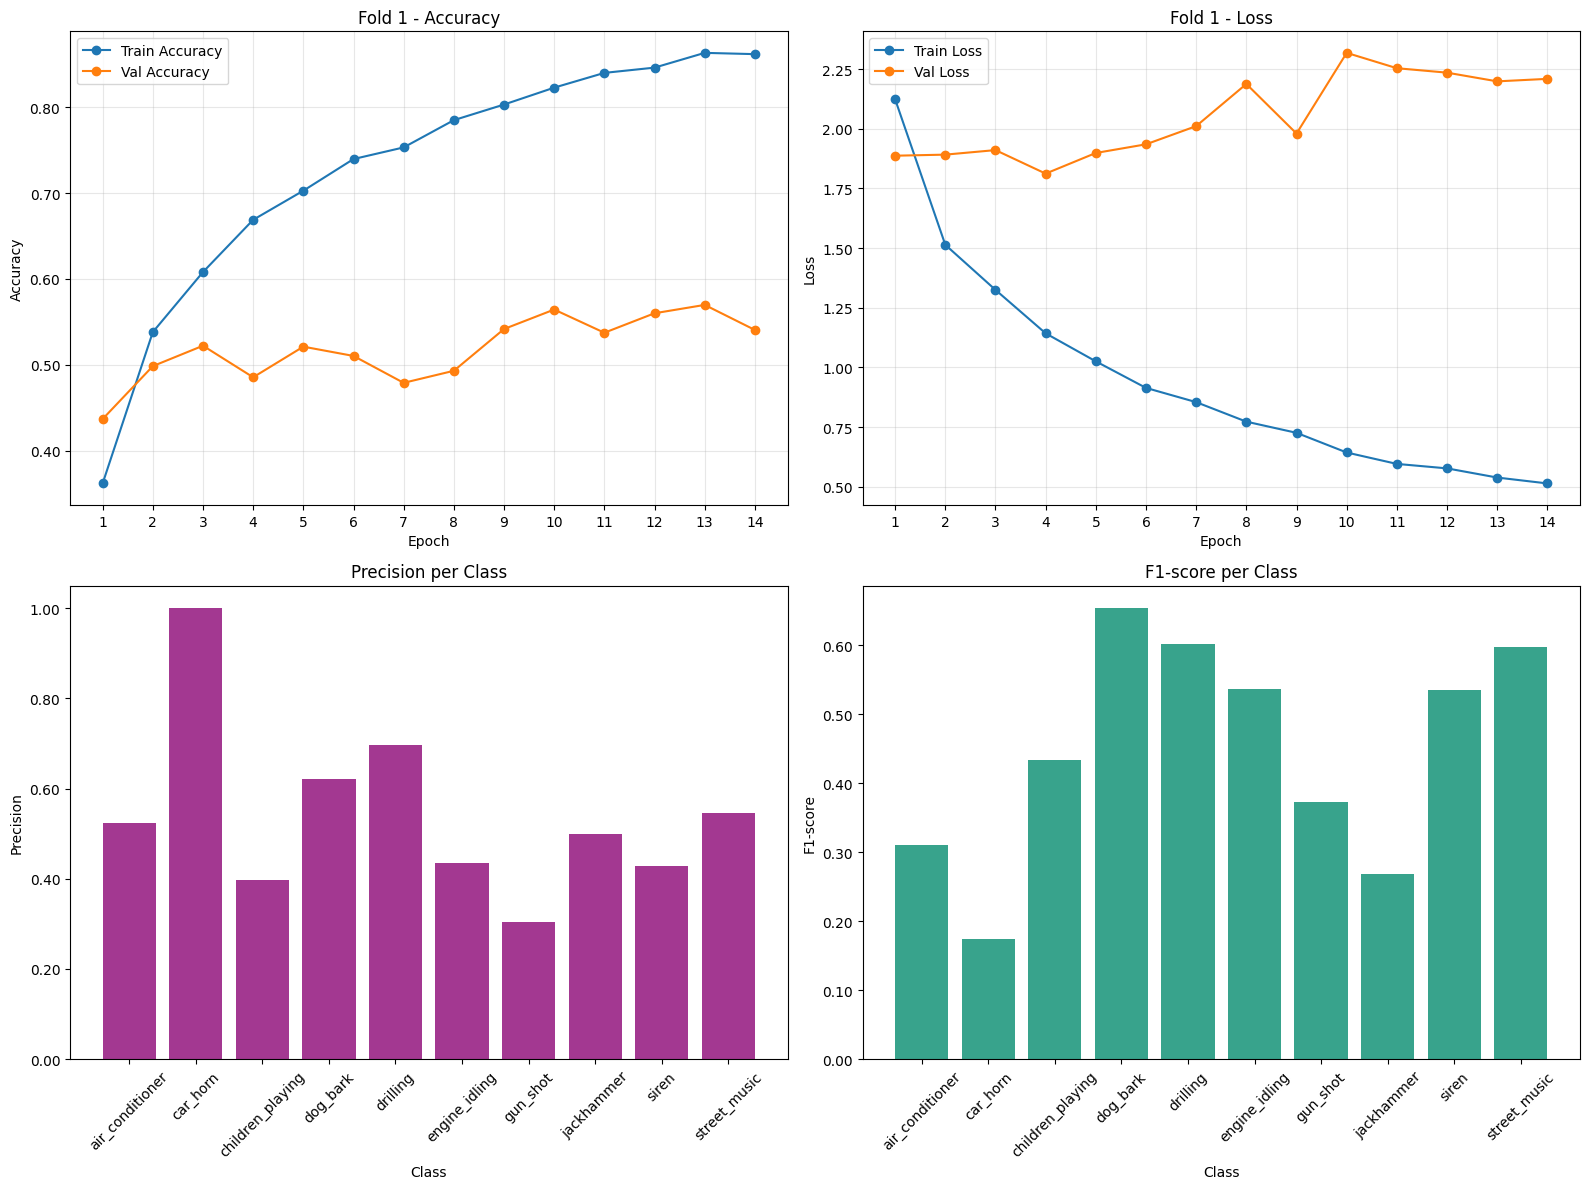

In [25]:
plot_fold_results(history, y_test_labels, y_pred_labels, class_names, fold_number=1)

After implementing the first improvements to the RNN architecture, we performed an evaluation **on a single fold only**. The goal was to quickly verify whether any performance gain was achieved before moving on to deeper architectural changes.

The results showed a **slight improvement**, indicating that the modifications had a positive impact. However, we realized that **there was still room for a more robust performance** — especially considering the noise and variability present in the dataset.

For this reason, we proceeded to a **second phase of improvements**, exploring additional techniques to strengthen the model’s generalization ability and reduce overfitting.

#### Improvement 2 <a name = "rnn_mi2"></a>
[[back to Improvements Implemented - RNN]](#rnn_mi)

After evaluating the first improved version of the model, we found that the performance gain was positive but still insufficient given the high variability and noise present in the dataset. Therefore, we proceeded to a second round of optimizations, this time focused on **advanced data-augmentation techniques, more stable normalization, an improved attention mechanism, and enhancements to both the loss function and optimizer**.

1. **Stronger Data Augmentation (SpecAugment + Time Shift)**

   We strengthened the use of `SpecAugment` by applying more aggressive time and frequency masks, applied multiple times with higher probability, and we additionally introduced time shifting. These operations increase data variability, making the model more robust to noise and natural variations in the recordings.

2. **Batch-Level Mixup**

   We implemented `Mixup`, linearly combining spectrograms and labels within each batch. This technique smooths the decision boundary, reduces overfitting, and improves generalization — particularly valuable in datasets with few samples per class.

3. **Feature-Wise Normalization**

   Before data augmentation, each MFCC is normalized per feature (using mean and standard deviation). This normalization reduces discrepancies between recordings, stabilizes training, and improves the consistency of the input features used by the model.

4. **Multi-Head Self-Attention with Residual Connection**

   We replaced the simple attention mechanism with `Multi-Head Attention`, allowing the model to capture temporal dependencies across multiple subspaces. Adding a residual connection reinforces stability and preserves information coming from the GRU layers.

5. **AdamW Optimizer and Label Smoothing**

   We used the `AdamW` optimizer with **weight decay** to provide stronger weight regularization, and applied label smoothing to prevent overly confident predictions. Combined with early stopping and adaptive learning-rate reduction, the training process became more stable and less prone to *overfitting*.


In [ ]:
input_dim = 60         
hidden_dim = 128       
output_dim = 10
num_layers = 2
dropout_rate = 0.3
l2_reg = 1e-4
batch_size = 64
max_epochs = 50
mixup_alpha = 0.3
specaugment_prob = 0.9

# -------------------------
# SpecAugment (more strong)
# -------------------------
def time_mask_numpy(spec, max_mask_size=10):
    # spec: (T, F)
    spec = spec.copy()
    T = spec.shape[0]
    if T <= 1:
        return spec
    mask_size = np.random.randint(1, max_mask_size + 1)
    t0 = np.random.randint(0, max(1, T - mask_size + 1))
    spec[t0:t0 + mask_size, :] = 0.0
    return spec

def freq_mask_numpy(spec, max_mask_size=12):
    spec = spec.copy()
    F = spec.shape[1]
    if F <= 1:
        return spec
    mask_size = np.random.randint(1, max_mask_size + 1)
    f0 = np.random.randint(0, max(1, F - mask_size + 1))
    spec[:, f0:f0 + mask_size] = 0.0
    return spec

def time_shift_numpy(spec, max_shift=3):
    # shift along time axis
    spec = spec.copy()
    T = spec.shape[0]
    shift = np.random.randint(-max_shift, max_shift + 1)
    if shift == 0:
        return spec
    return np.roll(spec, shift, axis=0)

def spec_augment_numpy(spec, p=specaugment_prob):
    spec = spec.copy()
    if np.random.rand() < p:
        # apply 1-3 time masks
        for _ in range(np.random.randint(1, 3)):
            spec = time_mask_numpy(spec, max_mask_size=8)
        # apply 1-2 freq masks
        for _ in range(np.random.randint(1, 3)):
            spec = freq_mask_numpy(spec, max_mask_size=10)
        # sometimes time shift
        if np.random.rand() < 0.3:
            spec = time_shift_numpy(spec, max_shift=4)
    return spec

In [32]:
# -------------------------
# Mixup (batch-level, numpy)
# -------------------------
def mixup_batch(x, y, alpha=mixup_alpha):
    """x: (B, T, F), y: (B, C) one-hot"""
    if alpha <= 0:
        return x, y
    lam = np.random.beta(alpha, alpha)
    idx = np.random.permutation(len(x))
    x_mix = lam * x + (1 - lam) * x[idx]
    y_mix = lam * y + (1 - lam) * y[idx]
    return x_mix, y_mix

In [ ]:
# -------------------------
# Normalization per feature (per frame-bin)
# -------------------------
def per_feature_normalize(spec):
    # spec: (T, F)
    mean = spec.mean(axis=0, keepdims=True)
    std = spec.std(axis=0, keepdims=True) + 1e-6
    return (spec - mean) / std

In [34]:
# -------------------------
# Data generator (tf.data from_generator wrapper)
# -------------------------
def train_generator(x, y, batch_size):
    """Generator yields augmented batches (mixup + specaugment + normalize)."""
    num = len(x)
    idxs = np.arange(num)
    while True:
        np.random.shuffle(idxs)
        for start in range(0, num, batch_size):
            batch_idx = idxs[start:start + batch_size]
            batch_x = x[batch_idx].astype(np.float32).copy()
            batch_y = y[batch_idx].astype(np.float32).copy()

            # apply per-sample augmentation
            for i in range(len(batch_x)):
                batch_x[i] = per_feature_normalize(batch_x[i])
                batch_x[i] = spec_augment_numpy(batch_x[i])

            # mixup
            batch_x, batch_y = mixup_batch(batch_x, batch_y, alpha=mixup_alpha)

            yield batch_x, batch_y

def val_generator(x, y, batch_size):
    num = len(x)
    idxs = np.arange(num)
    while True:
        for start in range(0, num, batch_size):
            batch_idx = idxs[start:start + batch_size]
            batch_x = x[batch_idx].astype(np.float32).copy()
            batch_y = y[batch_idx].astype(np.float32).copy()
            for i in range(len(batch_x)):
                batch_x[i] = per_feature_normalize(batch_x[i])
            yield batch_x, batch_y

In [ ]:
# -------------------------
# Improved model (MultiHeadAttention)
# -------------------------
def create_improved_rnn(
    input_dim,
    hidden_dim,
    output_dim,
    num_layers=2,
    dropout_rate=0.3,
    l2_reg=1e-4
):
    tf.keras.backend.clear_session()

    inputs = Input(shape=(None, input_dim), name="input_features")
    x = inputs

    for i in range(num_layers):
        x = Bidirectional(
            GRU(
                hidden_dim,
                return_sequences=True,
                dropout=0.15,
                recurrent_dropout=0.0,  # recurrent_dropout can slow training significantly
                kernel_regularizer=l2(l2_reg),
            ),
            merge_mode="concat"
        )(x)
        x = LayerNormalization()(x)

    # Multi-head attention (learnable)
    att = MultiHeadAttention(num_heads=4, key_dim=hidden_dim // 4)
    att_out = att(x, x)  # self-attention

    # Residual connection + Pooling
    x = x + att_out
    x = GlobalAveragePooling1D()(x)

    x = Dropout(dropout_rate)(x)

    outputs = Dense(output_dim, kernel_regularizer=l2(l2_reg), name="logits")(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [86]:
train_rnn = df_mfcc[~df_mfcc['fold'].isin([1, 2, 3])].reset_index(drop=True)
df_files_names = pd.DataFrame(train_rnn['audio_name'], columns=['audio_name'])
x_train_rnn = train_rnn.iloc[:,3:]
y_train_rnn = train_rnn.iloc[:,1]

# x_train_rnn = embedding_model.predict(x_train_rnn)  # -----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------

# print(f"Shape of LTE features: {x_train_rnn.shape}")  # -----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
print(f"Shape of MFCC features: {x_train_rnn.shape}")

# x_train_rnn = pd.DataFrame(x_train_rnn, columns=[f"LTE_feature_{i}" for i in range(x_train_rnn.shape[1])])  # -----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
# allow a direct link between x_train_rnn and df_files_names
x_train_rnn = x_train_rnn.reset_index(drop=True)
x_train_rnn['audio_name'] = df_files_names['audio_name'].values
y_train_rnn = y_train_rnn.to_frame(name='classID')
# allow a direct link between y_train_rnn and df_files_names
y_train_rnn = y_train_rnn.reset_index(drop=True)
y_train_rnn['audio_name'] = df_files_names['audio_name'].values
print(f"Shape of training dataset features: {x_train_rnn.shape}")
print(f"Shape of training dataset labels: {y_train_rnn.shape}")

# change the shape of y_train_rnn so that it is compatible with training
y_train_rnn = y_train_rnn.groupby('audio_name', as_index=False)['classID'].first()
y_train_rnn = y_train_rnn['classID']

# change the shape of x_train_rnn so that it is an input compatible with training
feature_columns = [col for col in x_train_rnn.columns if col != 'audio_name']
grouped = x_train_rnn.groupby('audio_name')

reshaped_data = []

for name, group in grouped:
    features = group[feature_columns].values
    # 33 is the number of time_steps used to extract MFCC features from a 4 sec audio
    if(features.shape[0] != 33):
        raise ValueError(f"The number of time_steps of audio {name} is not equal to the expected value; expected 33 time_steps per audio but received {features.shape[0]}")
    
    reshaped_data.append(features)

x_train_rnn = np.stack(reshaped_data, axis=0)

print(f"Shape of training features after reshaping: {x_train_rnn.shape}")
print("Applying data augmentation to training...")
x_train_rnn_aug = []
for spec in x_train_rnn:
    x_train_rnn_aug.append(spec_augment_numpy(spec))
x_train_rnn = np.stack(x_train_rnn_aug, axis=0)
print("Data augmentation completed!")

y_train_rnn_one_hot = tf.keras.utils.to_categorical(y_train_rnn, num_classes=10)
print(f"Shape of training labels after reshaping: {y_train_rnn_one_hot.shape}")

Shape of MFCC features: (199518, 60)
Shape of training dataset features: (199518, 61)
Shape of training dataset labels: (199518, 2)
Shape of training features after reshaping: (6046, 33, 60)
Applying data augmentation to training...
Data augmentation completed!
Shape of training labels after reshaping: (6046, 10)


In [87]:
test_rnn = df_mfcc[df_mfcc['fold'] == 2]
df_files_names = pd.DataFrame(test_rnn['audio_name'], columns=['audio_name']).reset_index(drop=True)
x_test_rnn = test_rnn.iloc[:,3:]
y_test_rnn = test_rnn.iloc[:,1]

# x_test_rnn = embedding_model.predict(x_test_rnn)  # -----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
# print(f"Shape of LTE features: {x_test_rnn.shape}")
print(f"Shape of MFCC features: {x_test_rnn.shape}")

# x_test_rnn = pd.DataFrame(x_test_rnn, columns=[f"LTE_feature_{i}" for i in range(x_test_rnn.shape[1])])  # -----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
x_test_rnn = x_test_rnn.reset_index(drop=True)
x_test_rnn['audio_name'] = df_files_names['audio_name'].values

y_test_rnn = y_test_rnn.to_frame(name='classID')
# allow a direct connection between y_test_rnn and df_files_names
y_test_rnn = y_test_rnn.reset_index(drop=True)
y_test_rnn['audio_name'] = df_files_names['audio_name'].values

print(f"Shape of test dataset features: {x_test_rnn.shape}")
print(f"Shape of test dataset labels: {y_test_rnn.shape}")

# change the shape of y_test_rnn so that it is compatible with training
y_test_rnn = y_test_rnn.groupby('audio_name', as_index=False)['classID'].first()
y_test_rnn = y_test_rnn['classID']

# change the shape of x_test_rnn so that it is an input compatible with training
feature_columns = [col for col in x_test_rnn.columns if col != 'audio_name']
grouped = x_test_rnn.groupby('audio_name')

reshaped_data = []

for name, group in grouped:
    features = group[feature_columns].values
    # 33 is the number of time_steps used to extract MFCC features from a 4-sec audio
    if(features.shape[0] != 33):
        raise ValueError(f"The number of time_steps in audio {name} is not equal to the expected value; expected 33 time_steps per audio but received {features.shape[0]}")
    
    reshaped_data.append(features)

x_test_rnn = np.stack(reshaped_data, axis=0)

print(f"Shape of test dataset features after reshaping: {x_test_rnn.shape}")

y_test_rnn_one_hot = tf.keras.utils.to_categorical(y_test_rnn, num_classes=10)
print(f"Shape of test dataset labels after reshaping: {y_test_rnn_one_hot.shape}")

Shape of MFCC features: (29304, 60)
Shape of test dataset features: (29304, 61)
Shape of test dataset labels: (29304, 2)
Shape of test dataset features after reshaping: (888, 33, 60)
Shape of test dataset labels after reshaping: (888, 10)


In [88]:
val_rnn = df_mfcc[df_mfcc['fold'] == 3].reset_index(drop=True)

x_val_rnn = val_rnn.iloc[:,3:]
y_val_rnn = val_rnn.iloc[:,1]

# x_val_rnn = embedding_model.predict(x_val_rnn)  # -----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
# print(f"Shape of LTE features: {x_val_rnn.shape}")
print(f"Shape of MFCC features: {x_val_rnn.shape}")

# x_val_rnn = pd.DataFrame(x_val_rnn, columns=[f"LTE_feature_{i}" for i in range(x_val_rnn.shape[1])])  # -----------------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS------------------------------------------
x_val_rnn = x_val_rnn.reset_index(drop=True)
x_val_rnn['audio_name'] = val_rnn['audio_name'].values

y_val_rnn = y_val_rnn.to_frame(name='classID')
# allow a direct link between y_val_rnn and df_files_names
y_val_rnn = y_val_rnn.reset_index(drop=True)
y_val_rnn['audio_name'] = val_rnn['audio_name'].values

print(f"Shape of validation dataset features: {x_val_rnn.shape}")
print(f"Shape of validation dataset labels: {y_val_rnn.shape}")

# change the shape of y_val_rnn so that it is compatible with training
y_val_rnn = y_val_rnn.groupby('audio_name', as_index=False)['classID'].first()
y_val_rnn = y_val_rnn['classID']

# change the shape of x_val_rnn so that it is an input compatible with training
feature_columns = [col for col in x_val_rnn.columns if col != 'audio_name']
grouped = x_val_rnn.groupby('audio_name')

reshaped_data = []

for name, group in grouped:
    features = group[feature_columns].values
    # 33 is the number of time_steps used to extract MFCC features from a 4-sec audio
    if(features.shape[0] != 33):
        raise ValueError(f"The number of time_steps in audio {name} is not equal to the expected value; expected 33 time_steps per audio but received {features.shape[0]}")
    
    reshaped_data.append(features)

x_val_rnn = np.stack(reshaped_data, axis=0)

print(f"Shape of validation features after reshaping: {x_val_rnn.shape}")

y_val_rnn_one_hot = tf.keras.utils.to_categorical(y_val_rnn, num_classes=10)
print(f"Shape of validation labels after reshaping: {y_val_rnn_one_hot.shape}")

Shape of MFCC features: (30525, 60)
Shape of validation dataset features: (30525, 61)
Shape of validation dataset labels: (30525, 2)
Shape of validation features after reshaping: (925, 33, 60)
Shape of validation labels after reshaping: (925, 10)


In [89]:
# -------------------------
# Compile with AdamW and label smoothing
# -------------------------
rnn_model = create_improved_rnn(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    l2_reg=l2_reg
)

optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)

rnn_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# -------------------------
# Prepare tf.data datasets
# -------------------------
# Note: x_train_rnn, y_train_rnn_one_hot, x_val_rnn, y_val_rnn_one_hot must be defined as numpy arrays
train_steps = int(np.ceil(len(x_train_rnn) / batch_size))
val_steps = int(np.ceil(len(x_val_rnn) / batch_size))

train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator(x_train_rnn, y_train_rnn_one_hot, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, None, input_dim), dtype=tf.float32),
        tf.TensorSpec(shape=(None, output_dim), dtype=tf.float32),
    )
).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    lambda: val_generator(x_val_rnn, y_val_rnn_one_hot, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, None, input_dim), dtype=tf.float32),
        tf.TensorSpec(shape=(None, output_dim), dtype=tf.float32),
    )
).prefetch(tf.data.AUTOTUNE)

# -------------------------
# Callbacks
# -------------------------
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.75, patience=5, min_lr=1e-6)
]

# -------------------------
# Fit
# -------------------------
history = rnn_model.fit(
    train_ds,
    steps_per_epoch=train_steps,
    epochs=max_epochs,
    validation_data=val_ds,
    validation_steps=val_steps,
    callbacks=callbacks
)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.4027 - loss: 2.0647 - val_accuracy: 0.4984 - val_loss: 1.7681 - learning_rate: 0.0010
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.6080 - loss: 1.7337 - val_accuracy: 0.5308 - val_loss: 1.6998 - learning_rate: 0.0010
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.6986 - loss: 1.5406 - val_accuracy: 0.5341 - val_loss: 1.6754 - learning_rate: 0.0010
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.7645 - loss: 1.4335 - val_accuracy: 0.5243 - val_loss: 1.6707 - learning_rate: 0.0010
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 91s 954ms/step - accuracy: 0.7860 - loss: 1.4555 - val_accuracy: 0.5351 - val_loss: 1.6923 - learning_rate: 0.0010
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 91s 957ms/step - accuracy: 0.8414 - loss: 1.2869 - val_accuracy: 0.5470 - val_loss: 1.6877 - learning_rate: 0.0010
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 91s 953ms/step - accuracy: 0.8219 - loss: 1.3491 - v

In [90]:
# Normalize each spectrogram (T=33, F=60)
x_test_norm = np.zeros_like(x_test_rnn, dtype=np.float32)

for i in range(len(x_test_rnn)):
    x_test_norm[i] = per_feature_normalize(x_test_rnn[i])

In [91]:
y_pred = rnn_model.predict(x_test_norm)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test_rnn_one_hot, axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 438ms/step


In [92]:
conf_matrix = confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)

original_labels = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music'
}

class_names = [original_labels[i] for i in range(len(conf_matrix))]

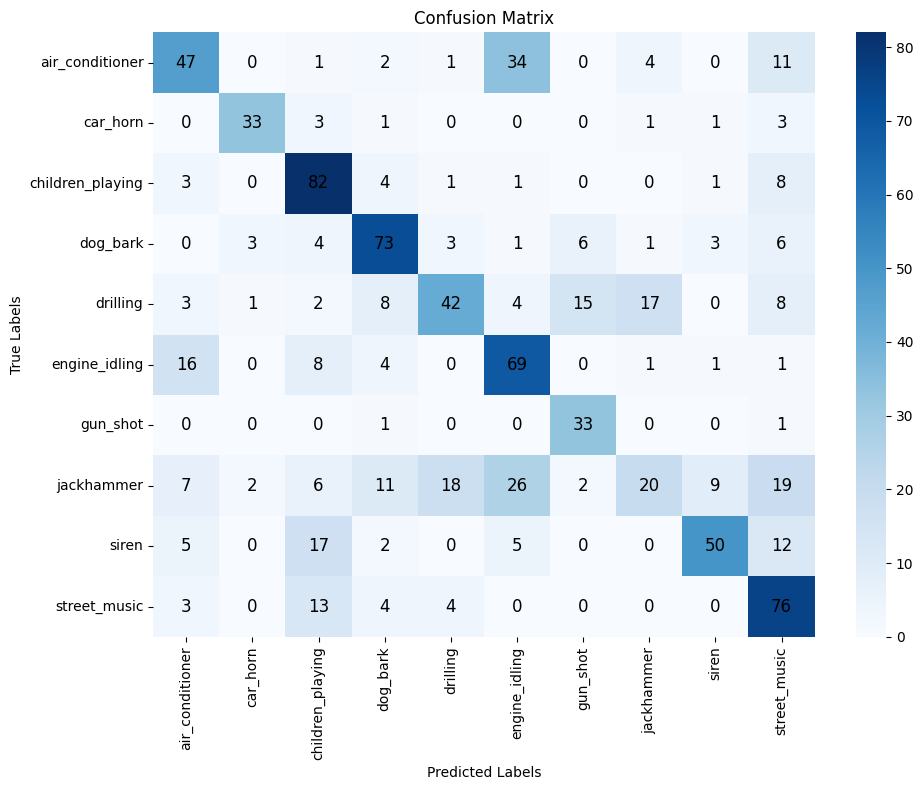

In [93]:
plt.figure(figsize=(10, 8))

ax = sns.heatmap(
    conf_matrix,
    cmap='Blues',
    cbar=True,
    xticklabels=class_names,
    yticklabels=class_names
)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        value = conf_matrix[i, j]
        ax.text(
            j + 0.5,
            i + 0.5,
            str(value),
            ha='center',
            va='center',
            fontsize=12,
        )

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [94]:
print("\nClassification Report")
print(classification_report(y_true=y_test_labels, y_pred=y_pred_labels))


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.47      0.51       100
           1       0.85      0.79      0.81        42
           2       0.60      0.82      0.69       100
           3       0.66      0.73      0.70       100
           4       0.61      0.42      0.50       100
           5       0.49      0.69      0.58       100
           6       0.59      0.94      0.73        35
           7       0.45      0.17      0.24       120
           8       0.77      0.55      0.64        91
           9       0.52      0.76      0.62       100

    accuracy                           0.59       888
   macro avg       0.61      0.63      0.60       888
weighted avg       0.59      0.59      0.57       888



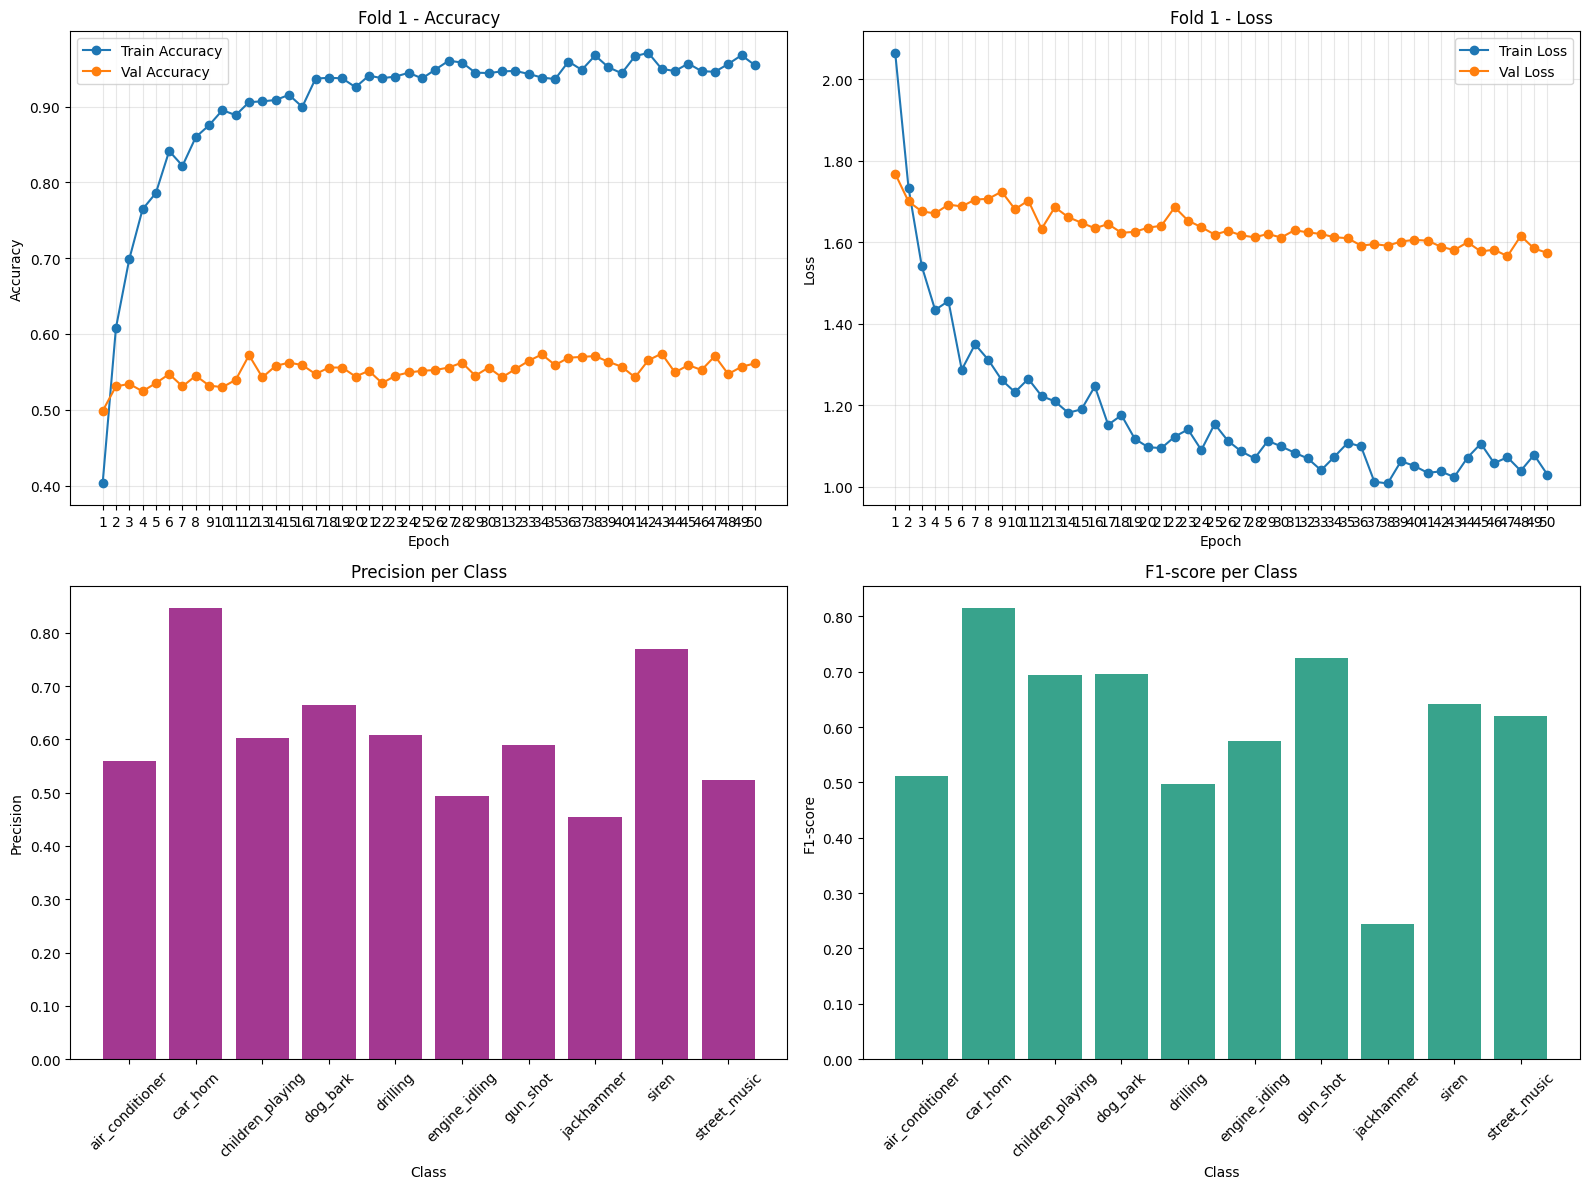

In [95]:
plot_fold_results(history, y_test_labels, y_pred_labels, class_names, fold_number=1)

Epoch 1/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.6203 - loss: 3.2620 - val_accuracy: 0.6203 - val_loss: 1.0340 - learning_rate: 0.0010
Epoch 2/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7177 - loss: 0.7771 - val_accuracy: 0.6181 - val_loss: 0.9113 - learning_rate: 0.0010
Epoch 3/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7409 - loss: 0.7126 - val_accuracy: 0.6642 - val_loss: 0.8912 - learning_rate: 0.0010
Epoch 4/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7475 - loss: 0.6972 - val_accuracy: 0.6723 - val_loss: 0.9244 - learning_rate: 0.0010
Epoch 5/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7519 - loss: 0.6883 - val_accuracy: 0.6211 - val_loss: 0.8861 - learning_rate: 0.0010
Epoch 6/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7541 - loss: 0.6828 - val_accuracy: 0.6724 - val_loss: 0.8815 - learning_rate: 0.0010
Epoch 7/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 

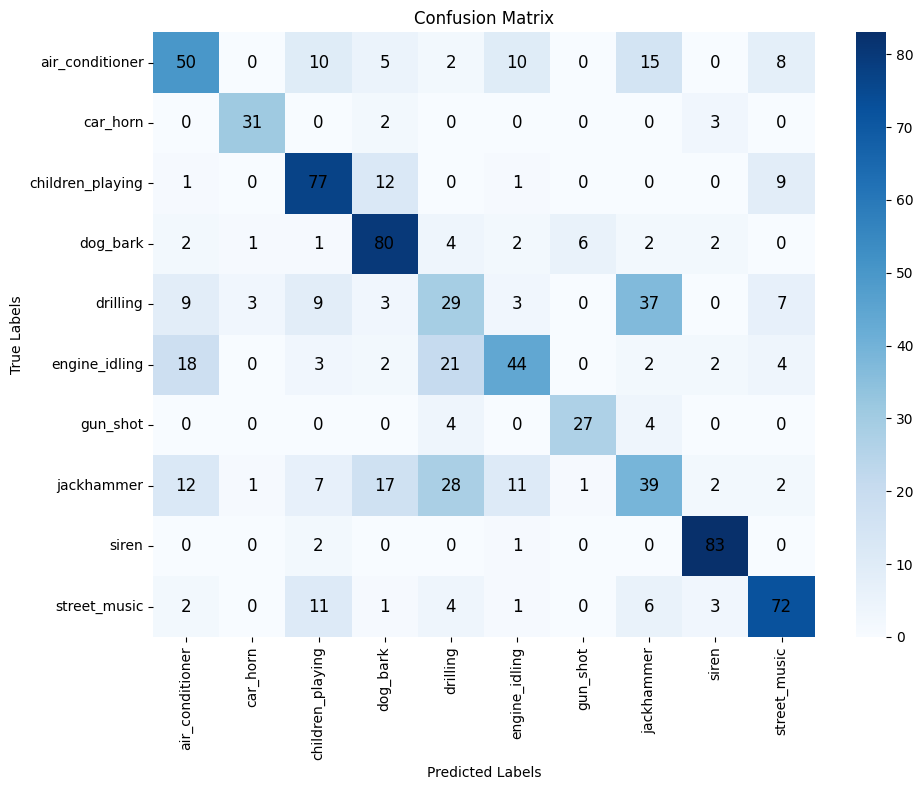


Classification Report
              precision    recall  f1-score   support

           0       0.53      0.50      0.52       100
           1       0.86      0.86      0.86        36
           2       0.64      0.77      0.70       100
           3       0.66      0.80      0.72       100
           4       0.32      0.29      0.30       100
           5       0.60      0.46      0.52        96
           6       0.79      0.77      0.78        35
           7       0.37      0.33      0.35       120
           8       0.87      0.97      0.92        86
           9       0.71      0.72      0.71       100

    accuracy                           0.61       873
   macro avg       0.64      0.65      0.64       873
weighted avg       0.60      0.61      0.60       873



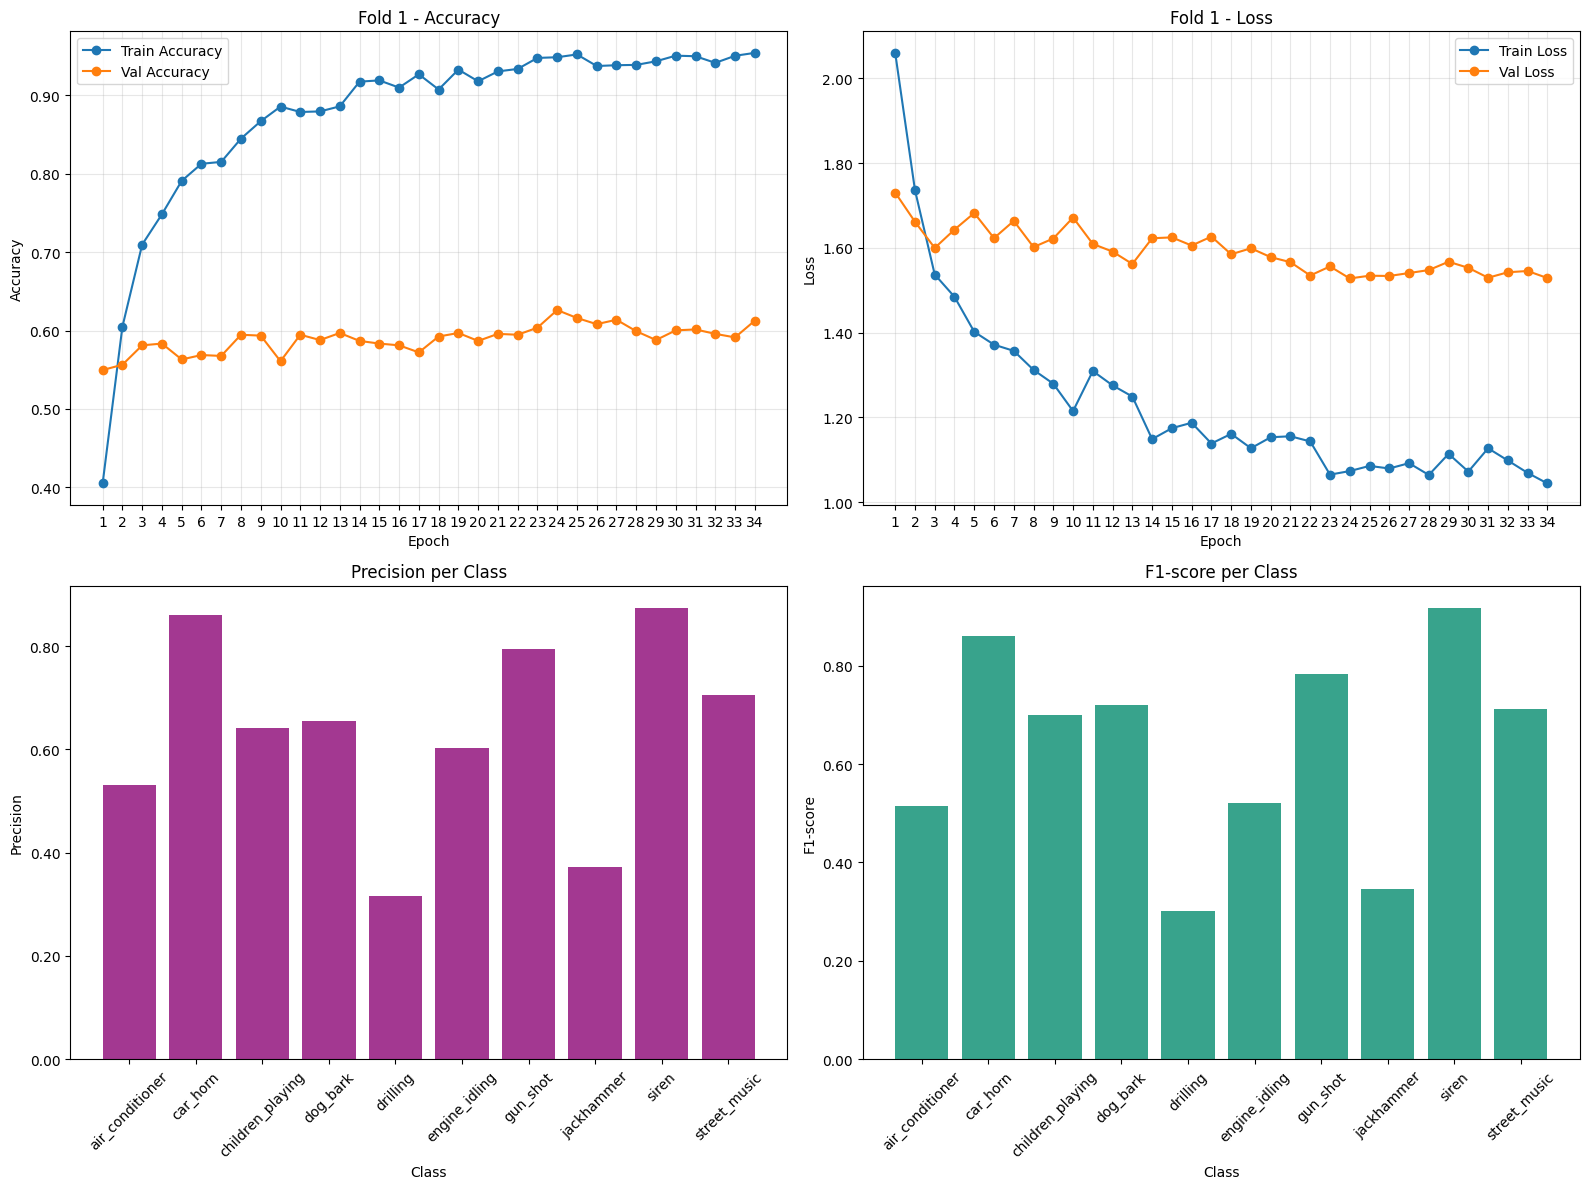

Epoch 1/100
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.6225 - loss: 5.3307 - val_accuracy: 0.6166 - val_loss: 0.9952 - learning_rate: 0.0010
Epoch 2/100
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7117 - loss: 0.7730 - val_accuracy: 0.6482 - val_loss: 0.9070 - learning_rate: 0.0010
Epoch 3/100
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.7328 - loss: 0.7212 - val_accuracy: 0.6497 - val_loss: 0.9060 - learning_rate: 0.0010
Epoch 4/100
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7439 - loss: 0.7002 - val_accuracy: 0.6510 - val_loss: 0.9161 - learning_rate: 0.0010
Epoch 5/100
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7495 - loss: 0.6850 - val_accuracy: 0.6027 - val_loss: 0.9895 - learning_rate: 0.0010
Epoch 6/100
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7533 - loss: 0.6721 - val_accuracy: 0.6551 - val_loss: 0.9349 - learning_rate: 0.0010
Epoch 7/100
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accura

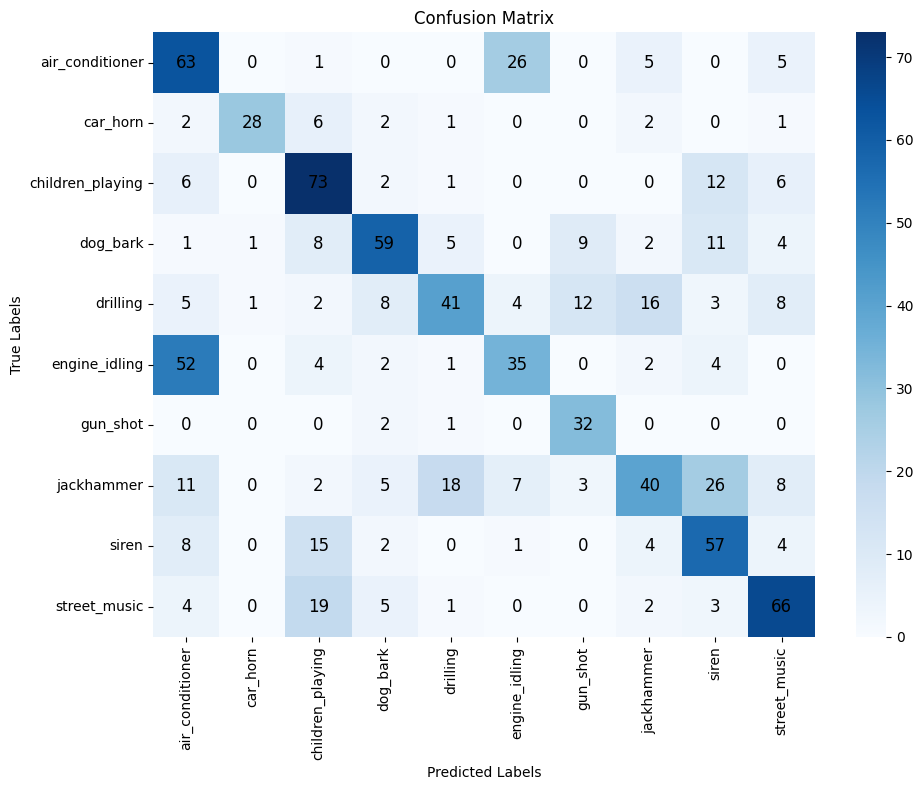


Classification Report
              precision    recall  f1-score   support

           0       0.41      0.63      0.50       100
           1       0.93      0.67      0.78        42
           2       0.56      0.73      0.63       100
           3       0.68      0.59      0.63       100
           4       0.59      0.41      0.49       100
           5       0.48      0.35      0.40       100
           6       0.57      0.91      0.70        35
           7       0.55      0.33      0.41       120
           8       0.49      0.63      0.55        91
           9       0.65      0.66      0.65       100

    accuracy                           0.56       888
   macro avg       0.59      0.59      0.58       888
weighted avg       0.57      0.56      0.55       888



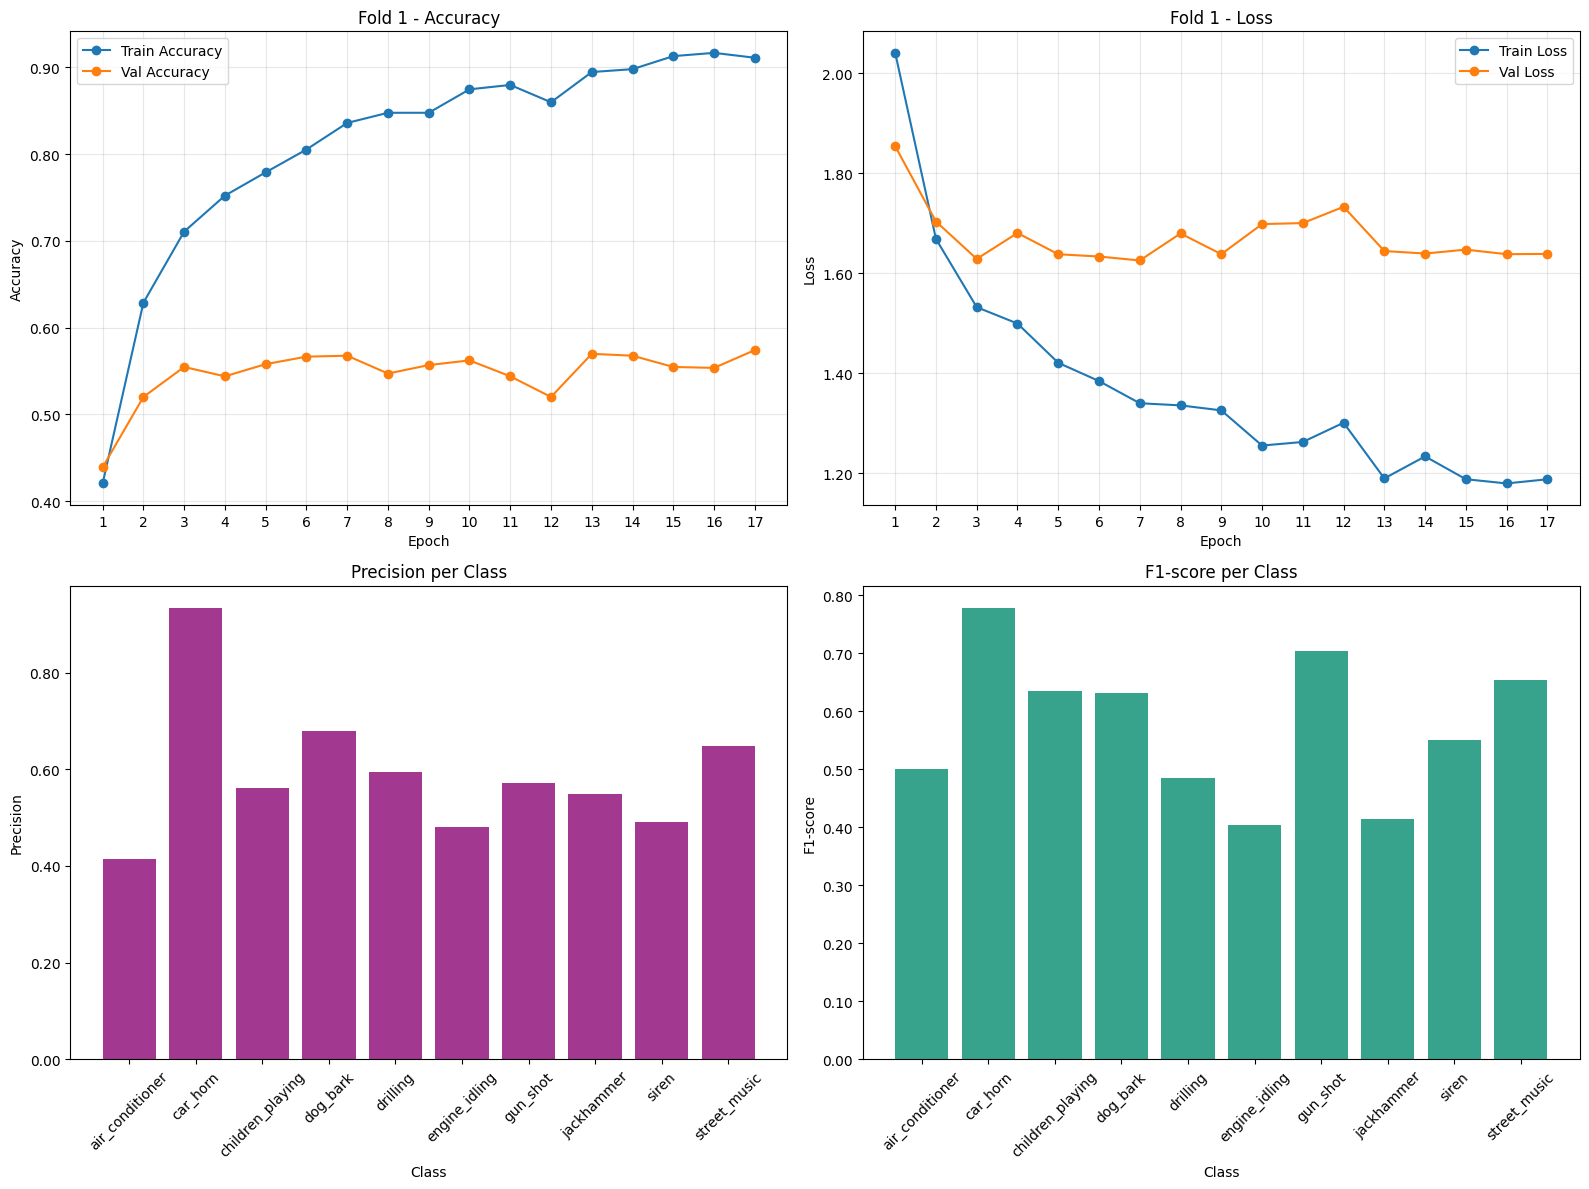

Epoch 1/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.6068 - loss: 4.6187 - val_accuracy: 0.6224 - val_loss: 1.0187 - learning_rate: 0.0010
Epoch 2/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7088 - loss: 0.7717 - val_accuracy: 0.6397 - val_loss: 0.9297 - learning_rate: 0.0010
Epoch 3/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7166 - loss: 0.7530 - val_accuracy: 0.6459 - val_loss: 0.9149 - learning_rate: 0.0010
Epoch 4/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7210 - loss: 0.7423 - val_accuracy: 0.6495 - val_loss: 0.8941 - learning_rate: 0.0010
Epoch 5/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7246 - loss: 0.7324 - val_accuracy: 0.6563 - val_loss: 0.8932 - learning_rate: 0.0010
Epoch 6/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7244 - loss: 0.7265 - val_accuracy: 0.6473 - val_loss: 0.9158 - learning_rate: 0.0010
Epoch 7/100
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 

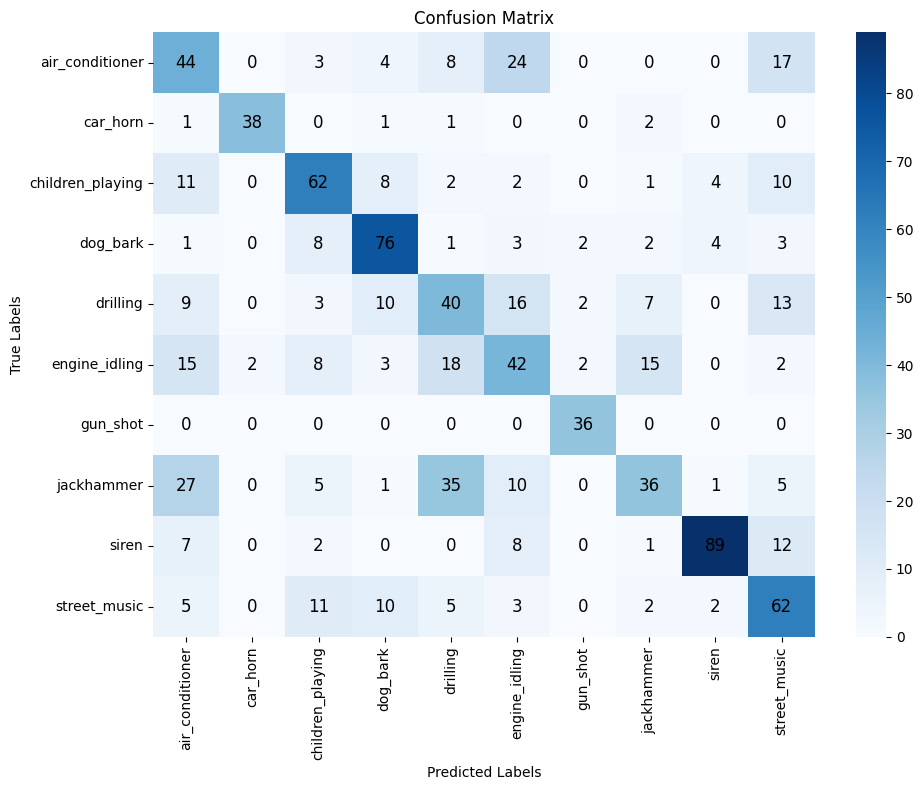


Classification Report
              precision    recall  f1-score   support

           0       0.37      0.44      0.40       100
           1       0.95      0.88      0.92        43
           2       0.61      0.62      0.61       100
           3       0.67      0.76      0.71       100
           4       0.36      0.40      0.38       100
           5       0.39      0.39      0.39       107
           6       0.86      1.00      0.92        36
           7       0.55      0.30      0.39       120
           8       0.89      0.75      0.81       119
           9       0.50      0.62      0.55       100

    accuracy                           0.57       925
   macro avg       0.61      0.62      0.61       925
weighted avg       0.58      0.57      0.57       925



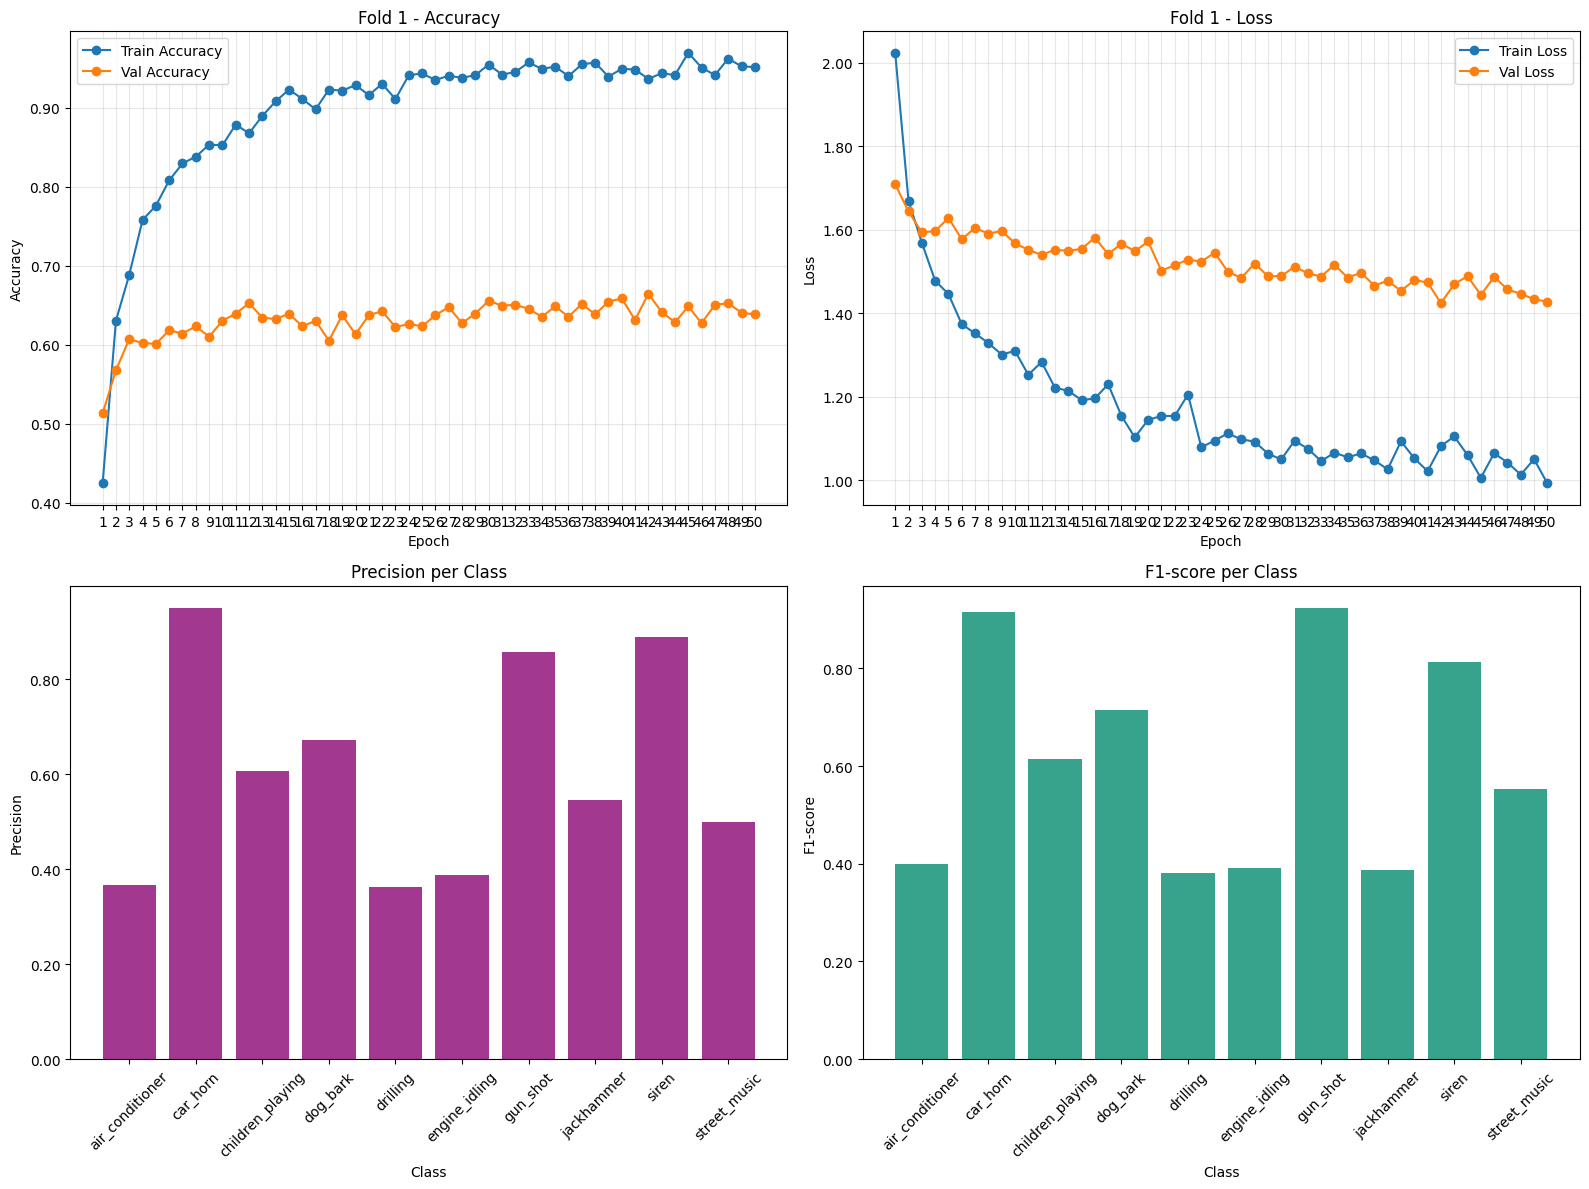

Epoch 1/100
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.6292 - loss: 6.2553 - val_accuracy: 0.6106 - val_loss: 1.0391 - learning_rate: 0.0010
Epoch 2/100
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7120 - loss: 0.7582 - val_accuracy: 0.6523 - val_loss: 0.9208 - learning_rate: 0.0010
Epoch 3/100
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7198 - loss: 0.7350 - val_accuracy: 0.6295 - val_loss: 0.9468 - learning_rate: 0.0010
Epoch 4/100
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7246 - loss: 0.7235 - val_accuracy: 0.6385 - val_loss: 1.0128 - learning_rate: 0.0010
Epoch 5/100
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7267 - loss: 0.7172 - val_accuracy: 0.6364 - val_loss: 0.9303 - learning_rate: 0.0010
Epoch 6/100
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7296 - loss: 0.7130 - val_accuracy: 0.5678 - val_loss: 1.0132 - learning_rate: 0.0010
Epoch 7/100
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accurac

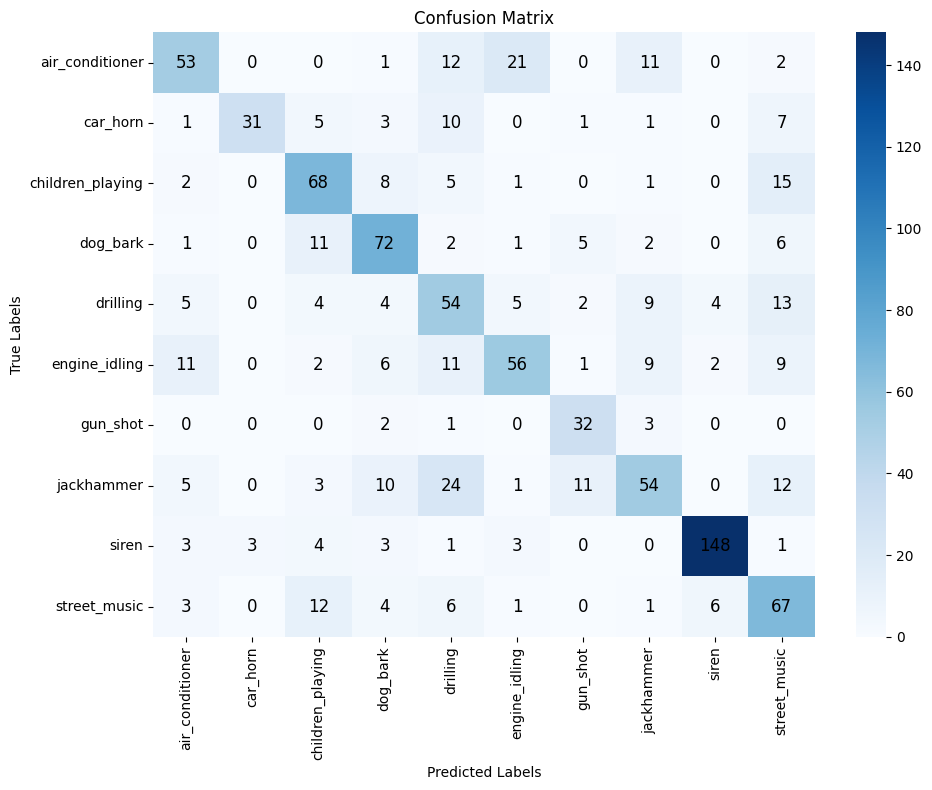


Classification Report
              precision    recall  f1-score   support

           0       0.63      0.53      0.58       100
           1       0.91      0.53      0.67        59
           2       0.62      0.68      0.65       100
           3       0.64      0.72      0.68       100
           4       0.43      0.54      0.48       100
           5       0.63      0.52      0.57       107
           6       0.62      0.84      0.71        38
           7       0.59      0.45      0.51       120
           8       0.93      0.89      0.91       166
           9       0.51      0.67      0.58       100

    accuracy                           0.64       990
   macro avg       0.65      0.64      0.63       990
weighted avg       0.66      0.64      0.64       990



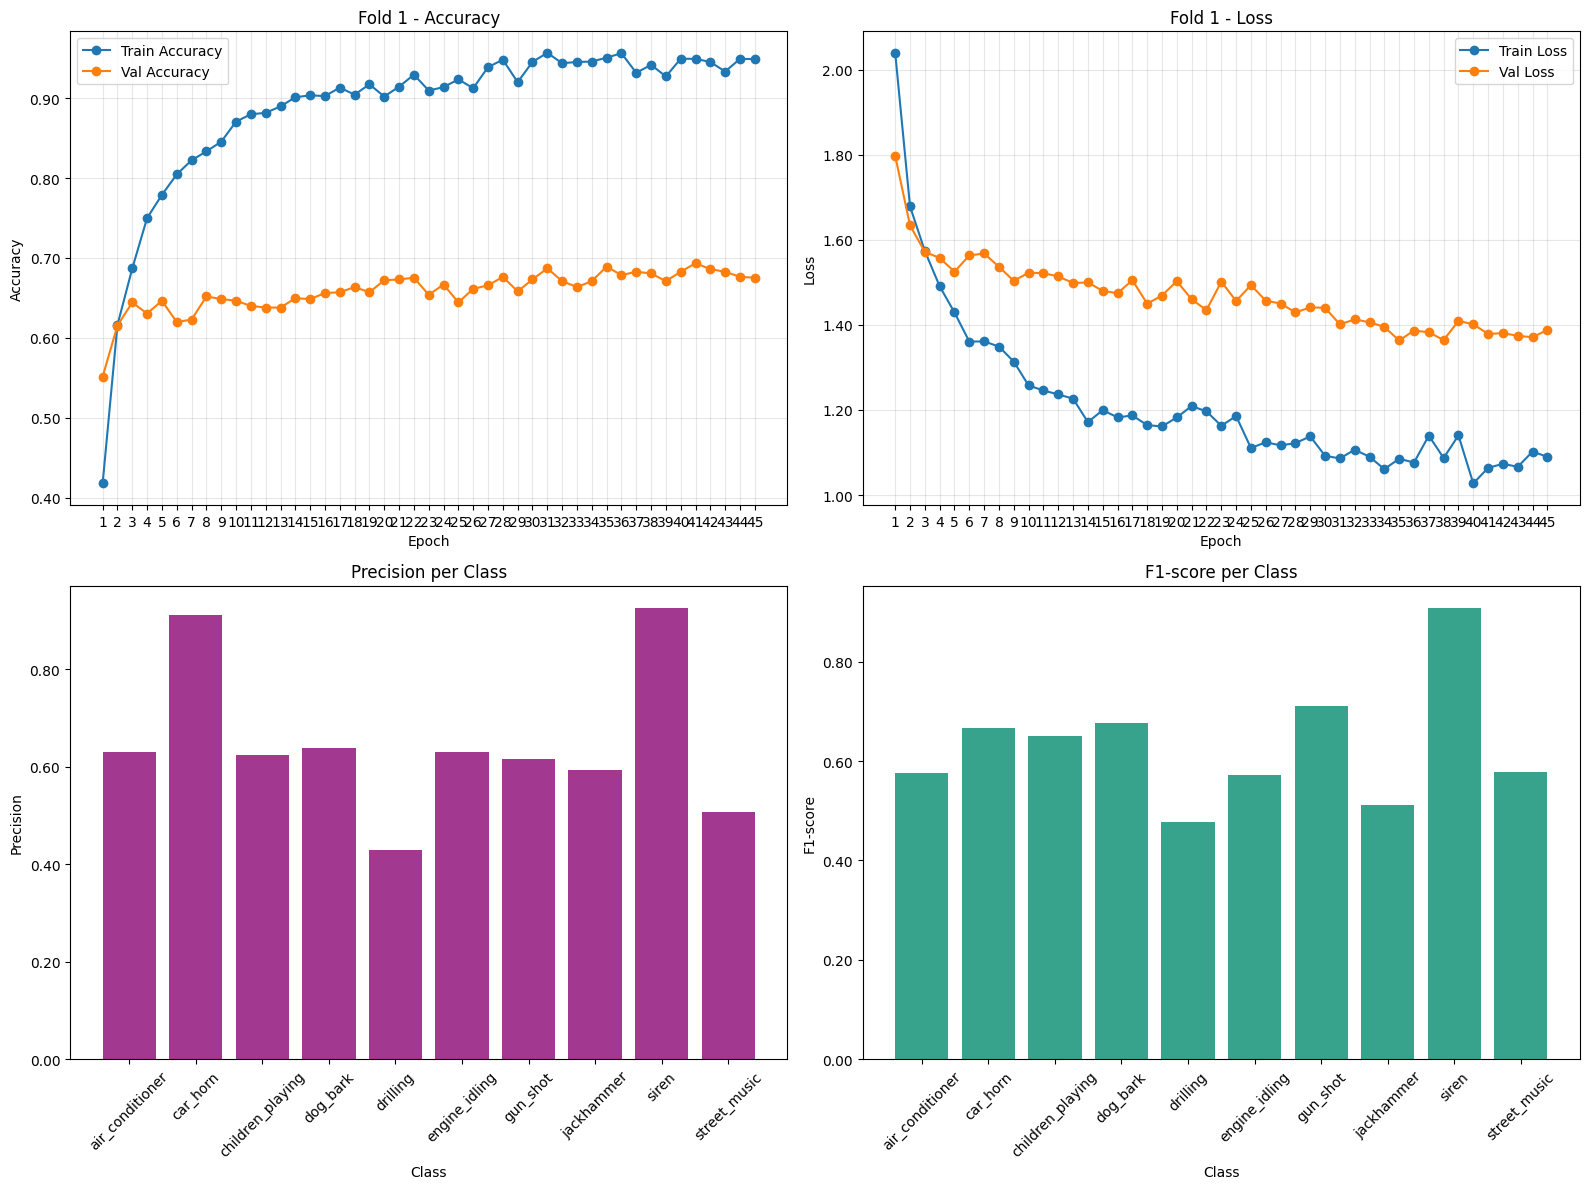

Epoch 1/100
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6769 - loss: 2.9399 - val_accuracy: 0.6455 - val_loss: 0.9398 - learning_rate: 0.0010
Epoch 2/100
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7283 - loss: 0.7413 - val_accuracy: 0.6105 - val_loss: 0.9587 - learning_rate: 0.0010
Epoch 3/100
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7360 - loss: 0.7159 - val_accuracy: 0.6638 - val_loss: 0.9344 - learning_rate: 0.0010
Epoch 4/100
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7409 - loss: 0.7000 - val_accuracy: 0.6545 - val_loss: 0.9575 - learning_rate: 0.0010
Epoch 5/100
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7451 - loss: 0.6887 - val_accuracy: 0.6567 - val_loss: 0.9259 - learning_rate: 0.0010
Epoch 6/100
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.7474 - loss: 0.6849 - val_accuracy: 0.6508 - val_loss: 0.9537 - learning_rate: 0.0010
Epoch 7/100
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accur

KeyboardInterrupt: 

In [96]:
accuracies={}
fold_histories=[]
total_conf_matrix=np.zeros((10,10), dtype=int)
for i in range (10):
    input_dim_lte=60
    embedding_dim=8
    num_meta_classes=6

    fold_test_rnn=(i%10)+1
    test_rnn=df_mfcc[df_mfcc['fold']== fold_test_rnn]
    x_test_rnn=test_rnn.iloc[:,3:]
    y_test_rnn=test_rnn.iloc[:,1]

    fold_val_rnn=((i+1)%10)+1
    val_rnn=df_mfcc[df_mfcc['fold']== fold_val_rnn]
    x_val_rnn=val_rnn.iloc[:,3:]
    y_val_rnn=val_rnn.iloc[:,1]
    
    fold_train_lte = [f for f in range(1, 11) if f not in [fold_test_rnn, fold_val_rnn]]
    train_lte=df_mfcc[df_mfcc['fold'].isin(fold_train_lte)]
    x_train_lte=train_lte.iloc[:,3:]
    y_train_lte=train_lte.iloc[:,1]

    # obtain the meta-classes to train the embedding model
    y_train_lte=get_meta_classes(y_train_lte).astype('int64')

    y_train_lte_one_hot=tf.keras.utils.to_categorical(y_train_lte,num_classes=num_meta_classes)
    LTE_model= build_LTE_model(input_dim=input_dim_lte, embedding_dim=embedding_dim, num_meta_classes=num_meta_classes)
    LTE_model.fit(x_train_lte, y_train_lte_one_hot, epochs=100, batch_size=128, validation_split=0.2,callbacks=[
        EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ])

    embedding_model= tf.keras.models.Model(inputs=LTE_model.input, outputs=LTE_model.layers[1].output)

    #--------------------------------------------------------------Train dataset preparation------------------------------------------------------

    train_rnn=df_mfcc[~df_mfcc['fold'].isin([fold_train_lte, fold_test_rnn, fold_val_rnn])].reset_index(drop=True)
    df_files_names=pd.DataFrame(train_rnn['audio_name'],columns=['audio_name'])
    x_train_rnn=train_rnn.iloc[:,3:]
    y_train_rnn=train_rnn.iloc[:,1]

    #print(f"Shape of LTE features: {x_train_rnn.shape}")  #--------------------------COMMENT THIS LINE TO NOT USE EMBEDDINGS-----------------------
    print(f"Shape of MFCC features: {x_train_rnn.shape}")

    # reshape dataset so that it is compatible with the RNN input
    #x_train_rnn = pd.DataFrame(x_train_rnn, columns=[f"LTE_feature_{i}" for i in range(x_train_rnn.shape[1])]) #----COMMENT THIS LINE TO NOT USE EMBEDDINGS--

    # allow a direct link between x_train_rnn and df_files_names
    x_train_rnn=x_train_rnn.reset_index(drop=True)
    x_train_rnn['audio_name'] = df_files_names['audio_name'].values
    y_train_rnn=y_train_rnn.to_frame(name='classID')

    # allow a direct link between y_train_rnn and df_files_names
    y_train_rnn=y_train_rnn.reset_index(drop=True)
    y_train_rnn['audio_name'] = df_files_names['audio_name'].values
    print(f"Shape of training dataset features: {x_train_rnn.shape}")
    print(f"Shape of training dataset labels: {y_train_rnn.shape}")
    
    # change the shape of y_train_rnn so that it is training-compatible
    y_train_rnn=y_train_rnn.groupby('audio_name', as_index=False)['classID'].first()
    y_train_rnn=y_train_rnn['classID']
    
    # change the shape of x_train_rnn to be compatible with training input
    feature_columns = [col for col in x_train_rnn.columns if col != 'audio_name']
    grouped = x_train_rnn.groupby('audio_name')
    
    reshaped_data=[]
    
    for name, group in grouped:
        features=group[feature_columns].values
        
        # 33 is the number of time_steps used to extract MFCC features for a 4-second audio
        if(features.shape[0]!=33):
            raise ValueError(f"The number of time_steps for audio {name} is not equal to the expected value. Expected 33 time_steps per audio, received {features.shape[0]}")
        
        reshaped_data.append(features)
    
    x_train_rnn=np.stack(reshaped_data, axis=0)
    
    print(f"Shape of training dataset features after reshaping: {x_train_rnn.shape}")

    x_train_rnn_aug = []
    for spec in x_train_rnn:
        x_train_rnn_aug.append(spec_augment_numpy(spec))
    x_train_rnn = np.stack(x_train_rnn_aug, axis=0)
    print("Data augmentation completed!")
    
    y_train_rnn_one_hot=tf.keras.utils.to_categorical(y_train_rnn,num_classes=10)
    print(f"Shape of training dataset labels after reshaping {y_train_rnn_one_hot.shape}")

    #--------------------------------------------------------------Test dataset preparation------------------------------------------------------

    df_files_names=pd.DataFrame(test_rnn['audio_name'],columns=['audio_name']).reset_index(drop=True)

    #x_test_rnn = embedding_model.predict(x_test_rnn) #------------COMMENT THIS LINE TO NOT USE EMBEDDINGS----------
    print(f"Shape of MFCC features : {x_test_rnn.shape}")

    #x_test_rnn = pd.DataFrame(x_test_rnn, columns=[f"LTE_feature_{i}" for i in range(x_test_rnn.shape[1])]) #---COMMENT TO NOT USE EMBEDDINGS----
    x_test_rnn=x_test_rnn.reset_index(drop=True)
    x_test_rnn['audio_name'] = df_files_names['audio_name'].values
    
    y_test_rnn=y_test_rnn.to_frame(name='classID')

    # allow a direct link between y_test_rnn and df_files_names
    y_test_rnn=y_test_rnn.reset_index(drop=True)
    y_test_rnn['audio_name'] = df_files_names['audio_name'].values
    print(f"Shape of test dataset features: {x_test_rnn.shape}")
    print(f"Shape of test dataset labels: {y_test_rnn.shape}")
    
    # change the shape of y_test_rnn to be compatible with evaluation
    y_test_rnn=y_test_rnn.groupby('audio_name', as_index=False)['classID'].first()
    y_test_rnn=y_test_rnn['classID']
    
    # reshape test features
    feature_columns = [col for col in x_test_rnn.columns if col != 'audio_name']
    grouped = x_test_rnn.groupby('audio_name')
    
    reshaped_data=[]
    
    for name, group in grouped:
        features=group[feature_columns].values
        if(features.shape[0]!=33):
            raise ValueError(f"The number of time_steps for audio {name} is not equal to expected. Expected 33, got {features.shape[0]}")
        
        reshaped_data.append(features)
    
    x_test_rnn=np.stack(reshaped_data, axis=0)
    
    print(f"Shape of test dataset features after reshaping: {x_test_rnn.shape}")
    
    y_test_rnn_one_hot=tf.keras.utils.to_categorical(y_test_rnn,num_classes=10)
    print(f"Shape of test dataset labels after reshaping {y_test_rnn_one_hot.shape}")

    #--------------------------------------------------------------Validation dataset preparation------------------------------------------------------

    df_files_names=pd.DataFrame(val_rnn['audio_name'],columns=['audio_name']).reset_index(drop=True)

    #x_val_rnn = embedding_model.predict(x_val_rnn) 
    print(f"Shape of MFCC features : {x_val_rnn.shape}")

    x_val_rnn=x_val_rnn.reset_index(drop=True)
    x_val_rnn['audio_name'] = df_files_names['audio_name'].values

    y_val_rnn=y_val_rnn.to_frame(name='classID')

    y_val_rnn=y_val_rnn.reset_index(drop=True)
    y_val_rnn['audio_name'] = df_files_names['audio_name'].values
    print(f"Shape of validation dataset features: {x_val_rnn.shape}")
    print(f"Shape of validation dataset labels: {y_val_rnn.shape}")

    # reorganize y
    y_val_rnn=y_val_rnn.groupby('audio_name', as_index=False)['classID'].first()
    y_val_rnn=y_val_rnn['classID']

    # reshape validation features
    feature_columns = [col for col in x_val_rnn.columns if col != 'audio_name']
    grouped = x_val_rnn.groupby('audio_name')

    reshaped_data=[]

    for name, group in grouped:
        features=group[feature_columns].values
        if(features.shape[0]!=33):
            raise ValueError(f"The number of time_steps for audio {name} is not equal to expected. Expected 33, got {features.shape[0]}")

        reshaped_data.append(features)

    x_val_rnn=np.stack(reshaped_data, axis=0)

    print(f"Shape of validation dataset features after reshaping: {x_val_rnn.shape}")

    y_val_rnn_one_hot=tf.keras.utils.to_categorical(y_val_rnn,num_classes=10)
    print(f"Shape of validation dataset labels after reshaping {y_val_rnn_one_hot.shape}")

    #--------------------------------------------------------------------------------------------------------------------

    # -------------------------
    # Compile with AdamW and label smoothing
    # -------------------------
    rnn_model = create_improved_rnn(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        l2_reg=l2_reg
    )

    optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)

    rnn_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

    # -------------------------
    # Prepare tf.data datasets
    # -------------------------
    train_steps = int(np.ceil(len(x_train_rnn) / batch_size))
    val_steps = int(np.ceil(len(x_val_rnn) / batch_size))

    train_ds = tf.data.Dataset.from_generator(
        lambda: train_generator(x_train_rnn, y_train_rnn_one_hot, batch_size),
        output_signature=(
            tf.TensorSpec(shape=(None, None, input_dim), dtype=tf.float32),
            tf.TensorSpec(shape=(None, output_dim), dtype=tf.float32),
        )
    ).prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_generator(
        lambda: val_generator(x_val_rnn, y_val_rnn_one_hot, batch_size),
        output_signature=(
            tf.TensorSpec(shape=(None, None, input_dim), dtype=tf.float32),
            tf.TensorSpec(shape=(None, output_dim), dtype=tf.float32),
        )
    ).prefetch(tf.data.AUTOTUNE)

    # -------------------------
    # Callbacks
    # -------------------------
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.75, patience=5, min_lr=1e-6)
    ]

    # -------------------------
    # Fit
    # -------------------------
    history = rnn_model.fit(
        train_ds,
        steps_per_epoch=train_steps,
        epochs=max_epochs,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks
    )

    #--------------------------------------------------------------------------------------------------------------------

    # Normalize each spectrogram (T=33, F=60)
    x_test_norm = np.zeros_like(x_test_rnn, dtype=np.float32)

    for i in range(len(x_test_rnn)):
        x_test_norm[i] = per_feature_normalize(x_test_rnn[i])

    y_pred=rnn_model.predict(x_test_norm)

    y_pred_labels=np.argmax(y_pred, axis=1)
    y_test_labels=np.argmax(y_test_rnn_one_hot,axis=1)
    
    conf_matrix= confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)
    total_conf_matrix=np.add(total_conf_matrix,conf_matrix)

    # Total correct predictions are the diagonal elements of the confusion matrix
    correct_predictions = np.trace(conf_matrix)
    total_predictions = np.sum(conf_matrix)  
    accuracy = correct_predictions / total_predictions
    print(f"Accuracy: {accuracy:.4f}")
    accuracies[f'Fold{i+1}']=accuracy
    
    conf_matrix = confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)

    original_labels = {
        0: 'air_conditioner',
        1: 'car_horn',
        2: 'children_playing',
        3: 'dog_bark',
        4: 'drilling',
        5: 'engine_idling',
        6: 'gun_shot',
        7: 'jackhammer',
        8: 'siren',
        9: 'street_music'
    }

    class_names = [original_labels[i] for i in range(len(conf_matrix))]
    
    plt.figure(figsize=(10, 8))

    ax = sns.heatmap(
        conf_matrix,
        cmap='Blues',
        cbar=True,
        xticklabels=class_names,
        yticklabels=class_names
    )

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            value = conf_matrix[i, j]
            ax.text(
                j + 0.5,
                i + 0.5,
                str(value),
                ha='center',
                va='center',
                fontsize=12,
            )

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    print("\nClassification Report")
    print(classification_report(y_true=y_test_labels, y_pred=y_pred_labels))
    
    plot_fold_results(history, y_test_labels, y_pred_labels, class_names, fold_number=1)

In [97]:
conf_matrix = confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)

original_labels = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music'
}

class_names = [original_labels[i] for i in range(len(conf_matrix))]

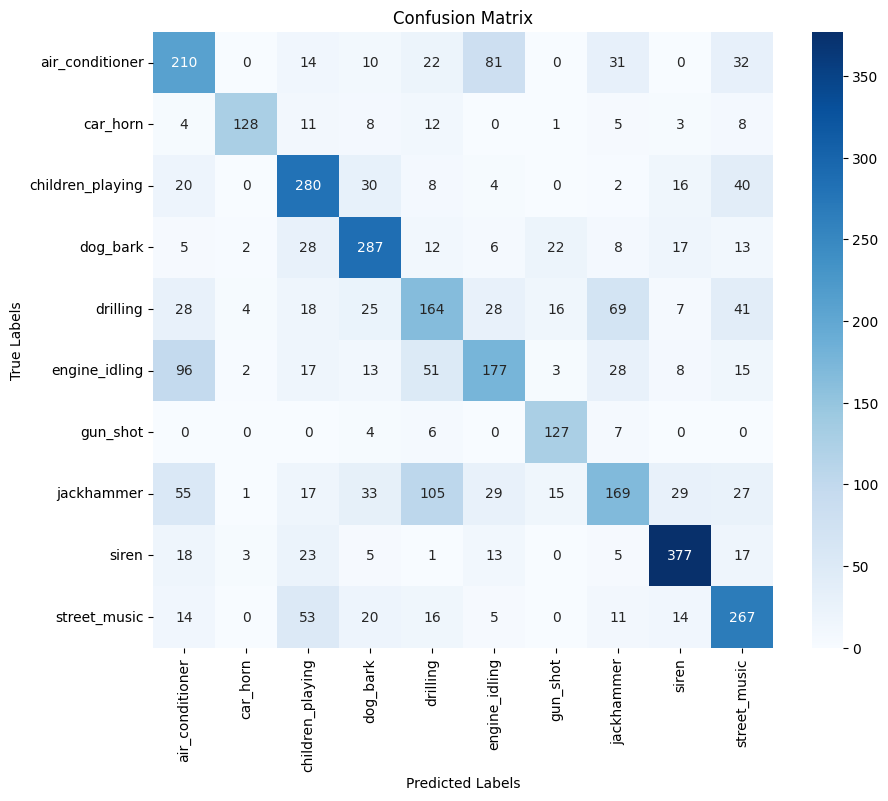

In [98]:
# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(total_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [99]:
def visualize_metrics_rnn(results_df, mean_accuracy, std_accuracy, fold_histories):

    # Fold-wise Accuracy
    plt.figure(figsize=(10, 6))

    x = results_df['fold'].astype(int)
    y = results_df['accuracy'].astype(float)

    plt.plot(x, y, marker='o', label="Fold Accuracy")
    plt.axhline(y=mean_accuracy, color='r', linestyle='--',
                label=f"Mean Accuracy ({mean_accuracy:.4f})")

    plt.fill_between(
        x,
        mean_accuracy - std_accuracy,
        mean_accuracy + std_accuracy,
        color='r', alpha=0.2,
        label=f"± Std Dev ({std_accuracy:.4f})"
    )

    plt.title("Fold-wise Accuracy")
    plt.xlabel("Fold")
    plt.ylabel("Accuracy")
    plt.xticks(x)
    plt.legend()
    plt.grid(True)
    plt.savefig("./results_images/fold_accuracy_rnn_2.png")
    plt.show()

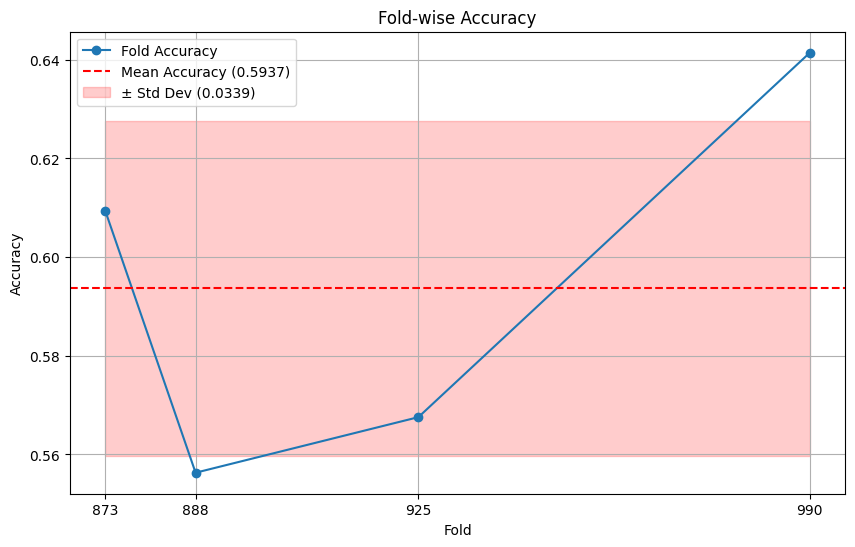

In [100]:
results_df = pd.DataFrame({
    "fold": list(accuracies.keys()),
    "accuracy": list(accuracies.values())
})

results_df['fold'] = results_df['fold'].str.extract(r'(\d+)').astype(int)

mean_accuracy = np.mean(list(accuracies.values()))
std_accuracy = np.std(list(accuracies.values()))

visualize_metrics_rnn(
    results_df=results_df,
    mean_accuracy=mean_accuracy,
    std_accuracy=std_accuracy,
    fold_histories=fold_histories,
)

**Note:** Due to limited time and computational resources, we were unable to complete the 10-fold cross-validation for the improvement implemented in this notebook. However, we executed the full procedure in a separate environment, and the corresponding results can be found here: [RNN - appendix](results_analysis/RNN-results-10-fold-cross-validation.ipynb)

#### Results Analysis <a name = "rnn_ar2"></a>
[[back to Improvements Implemented - RNN]](#rnn_mi)

##### Comparative Table — Improvement 1 vs. Improvement 2
| **Component**           | **Improvement 1**                                            | **Improvement 2**                                                                      |
| ----------------------- | ------------------------------------------------------------ | -------------------------------------------------------------------------------------- |
| **Base Architecture**   | 2 × Bidirectional GRU                                        | 2 × Bidirectional GRU (optimized dropout + L2)                                         |
| **Normalization**       | Layer Normalization after each GRU                           | Same Layer Normalization + feature-wise normalization in preprocessing                 |
| **Attention**           | Simple attention (Keras Attention)                           | Multi-Head Attention (4 heads) + residual connection                                   |
| **Pooling**             | GlobalAveragePooling1D                                        | GlobalAveragePooling1D                                                     |
| **Regularization**      | Final dropout + moderate L2                                   | Optimized dropout, L2 + AdamW weight decay                                             |
| **Data Augmentation**   | Basic SpecAugment (1 mask per axis, moderate probability)     | Strong SpecAugment (multiple masks, time-shift, higher probability)                    |
| **Mixup**               | Not included                                                  | Included in the training pipeline                                                      |
| **Preprocessing**       | Only reshaping                                                | Feature-wise normalization (per MFCC)                                                  |
| **Optimizer**           | Standard Adam                                                 | AdamW with weight decay                                                                |
| **Loss Function**       | Categorical Crossentropy (logits)                             | Categorical Crossentropy + label smoothing (0.1)                                       |
| **Training Pipeline**   | Direct NumPy training                                         | `tf.data` with on-the-fly generation (SpecAugment + Mixup)                             |
| **Main Goal**           | Improve model representational capacity                       | Improve robustness, generalization, and training stability                             |
| **Observed Result**     | Slight improvement over baseline                              | Additional, more consistent improvement over Improvement 1                              |


The evolution observed across the three models demonstrates a progressive improvement in the ability of RNNs to learn and generalize from audio data. 

- The **Base Model** exhibits typical limitations of an initial configuration, showing signs of instability and overfitting, with clear discrepancies between training and validation performance.

- **Improvement 1** introduces adjustments that lead to a more balanced behavior: the learning curves become more stable, the gap between training and validation decreases, and the per-class performance shows clear advances, indicating that the model is beginning to capture relevant patterns more consistently.

- **Improvement 2** achieves the most robust performance, displaying smoother training and validation curves, more efficient convergence, and a more homogeneous distribution of correct predictions across classes. This result demonstrates that the applied optimizations — whether architectural, regularization-based, or hyperparameter adjustments — have a direct impact on the network’s generalization ability.

Taken together, these results confirm that carefully introduced incremental modifications can lead to significant improvements in the performance of recurrent models, especially in demanding tasks such as audio classification, where temporal modeling plays a crucial role.

## DeepFool Implementation <a name = "deepfool"></a>
[[back to index]](#toc)

After training our RNN model, it is necessary to **evaluate the robustness of the classifier**. 

**DeepFool** is an algorithm that identifies the smallest change required in the model's input to trick it into producing a different prediction. By iteratively computing the minimal perturbation needed to alter a model's decision, DeepFool provides insights into a model's vulnerability to adversarial attacks. 

<figure style="text-align: center;">
  <img src="images/deepfool.jpg" alt="RNN Architecture" width=400>
  <figcaption><em>Figure 4 – DeepFool: multi-class case</em></figcaption>
</figure>

In this work, the method was applied to MFCC-based audio representation. This allows us to analyse how minor and often imperceptible, modifications to the input can lead the model to misclassify a sound. A small perturbation norm indicates that the model can be easily deceived, whereas a larger perturbation suggests that the classifier is more resilient to adversarial manipulation.

In [ ]:
def deepfool_mfcc(mfcc, model, num_classes=10, overshoot=0.02, max_iter=50):
    # Ensure the input is a NumpY array and expand dims for batch size
    mfcc = np.expand_dims(mfcc, axis=0)
    perturbed_mfcc = copy.deepcopy(mfcc)

    # Compute initial prediction
    logits = model(tf.convert_to_tensor(mfcc, dtype=tf.float32))
    logits = logits.numpy().flatten()
    top_classes = np.argsort(logits)[-num_classes:] # Top 'num_classes' sorted indices
    original_label = top_classes[0] # Most probable class

    # Initiablize variables
    r_tot = np.zeros_like(mfcc) # Acuumulated perturbation
    loop_i = 0
    current_label = original_label

    while current_label == original_label and loop_i < max_iter:
        pert = np.inf  # Initialize smallest perturbation
        grads_orig = None  # Gradient of the original class

        with tf.GradientTape() as tape:
            # Set tape to wath input tensor
            input_tensor = tf.convert_to_tensor(perturbed_mfcc, dtype=tf.float32)
            tape.watch(input_tensor)

            # Compute logits and focus on original class
            logits = model(input_tensor)
            logits = tf.reshape(logits, [-1])
            score_original = logits[top_classes[0]]  # Original class score

        # Compute gradient for the original class
        grads_orig = tape.gradient(score_original, input_tensor).numpy()

        # Loop through the remaining classes
        for k in range(1, num_classes):
            with tf.GradientTape() as tape:
                tape.watch(input_tensor)
                logits = model(input_tensor)
                logits = tf.reshape(logits, [-1])
                score_k = logits[top_classes[k]] # Score for class 'k'

            # Compute gradient for class 'k'
            grads_k = tape.gradient(score_k, input_tensor).numpy()

            # Compute perturbation direction and magnitude
            w_k = grads_k - grads_orig # Direction
            f_k = (logits[top_classes[k]] - logits[top_classes[0]]).numpy() # Difference in logits
            pert_k = abs(f_k) / (np.linalg.norm(w_k.flatten()) + 1e-4) # Magnitude

            # Select the smallest perturbation
            if pert_k < pert:
                pert = pert_k
                w = w_k
        
        # Update total perturbation
        r_i = (pert + 1e-4) * w /np.linalg.norm(w.flatten())
        r_tot = r_tot + r_i

        # Add perturbation to the original MFCC
        perturbed_mfcc = mfcc + ( 1 + overshoot) * r_tot

        # Check if the pertubed input fools the model
        logits = model(tf.convert_to_tensor(perturbed_mfcc, dtype=tf.float32)).numpy().flatten()
        current_label = np.argmax(logits) 

        loop_i += 1

    # Final perturbation (scaled by overshoot factor)
    r_tot = (1 + overshoot) * r_tot

    return r_tot.squeeze(), loop_i, original_label, current_label, perturbed_mfcc.squeeze()           


In [ ]:
count=0
percentage=0
total_pertubations=0
for mfcc_example in x_test_rnn:
    r_tot, loop_i, original_label, pert_label, perturbed_mfcc = deepfool_mfcc(
        mfcc = mfcc_example,
        model = rnn_model,
        num_classes = 10,
        overshoot = 0.02,
        max_iter = 50
    )
    count+=1
    if(count>=percentage*len(x_test_rnn)):
        percentage+=0.01
        print(f"Currently in part {int(percentage*100)}/100")

    perturbation_magnitude=np.linalg.norm(r_tot)
    mfcc_example_magnitude=np.linalg.norm(mfcc_example)

    total_pertubations+=perturbation_magnitude/mfcc_example_magnitude
    
avg_robustness=total_pertubations/count

print(f"The average roboustness is {avg_robustness}")

Currently in part 1/100
Currently in part 2/100
Currently in part 3/100
Currently in part 4/100
Currently in part 5/100
Currently in part 6/100
Currently in part 7/100
Currently in part 8/100
Currently in part 9/100
Currently in part 10/100
Currently in part 10/100
Currently in part 11/100
Currently in part 12/100
Currently in part 13/100
Currently in part 15/100
Currently in part 16/100
Currently in part 17/100
Currently in part 18/100
Currently in part 19/100
Currently in part 20/100
Currently in part 21/100
Currently in part 22/100
Currently in part 23/100
Currently in part 24/100
Currently in part 25/100
Currently in part 26/100
Currently in part 27/100
Currently in part 28/100
Currently in part 29/100
Currently in part 30/100
Currently in part 31/100
Currently in part 32/100
Currently in part 33/100
Currently in part 34/100
Currently in part 35/100
Currently in part 36/100
Currently in part 37/100
Currently in part 38/100
Currently in part 39/100
Currently in part 40/100
Currently

In [ ]:
avg_robustness

0.009636506147334299

When applied to the RNN, DeepFool revealed that **the model is highly sensitive to small perturbations** in the input features, confirming that recurrent architectures — although effective at capturing temporal patterns — can still be vulnerable to adversarial manipulations. The generated adversarial examples led the RNN to misclassify certain urban sound samples with only subtle modifications, highlighting the importance of incorporating robustness evaluations into audio classification pipelines.

These observations reinforce the need for future work to explore defensive strategies such as adversarial training, regularization techniques, or more robust architectures that reduce vulnerability without compromising model performance.

## Conclusion <a name = "conc"></a>
[[back to index]](#toc)

The implementation of the RNN model made it possible to explore the ability of recurrent networks to capture the sequential nature of audio. Despite the **limitations in computational resources and available time** — two of the main challenges of this work — it was possible to introduce small improvements in the architecture and preprocessing, which contributed to a more stable performance. Overall, the RNN proved effective in learning the temporal patterns present in urban sounds, reinforcing the relevance of this type of network for audio classification tasks, even though its computational cost is significantly higher.

### Future Work

For future work, it would be important to test more advanced architectures, such as hybrid CNN–RNN models, and apply more refined and efficient techniques. The use of more powerful hardware (such as dedicated GPUs) would allow training deeper models and better exploring the full potential of this approach.


## References

- Barua, S., Akter, T., Musa, M. A. S., & Azim, M. A. (2023). A Deep Learning Approach for Urban Sound Classification. International Journal of Computer Applications, 185(24), 8–14. https://doi.org/10.5120/ijca2023922991 

- Mienye, I. D., Swart, T. G., Obaido, G., Mienye, I. D., Swart, T. G., & Obaido, G. (2024). Recurrent Neural Networks: A Comprehensive Review of Architectures, Variants, and Applications. Information 2024, Vol. 15, 15(9). https://doi.org/10.3390/INFO15090517

- Phan, H., Koch, P., Katzberg, F., Maass, M., Mazur, R., & Mertins, A. (n.d.). Audio Scene Classification with Deep Recurrent Neural Networks.
